# *import*

In [1]:
# from collections import OrderedDict
from typing import List, Tuple, Callable
import matplotlib.pyplot as plt
from datasets.utils.logging import enable_progress_bar
enable_progress_bar()
import time
import threading
import random
import os
import torch


import flwr
from flwr.client import Client, ClientApp
from flwr.common import ndarrays_to_parameters, Context, Metrics
from flwr.server import ServerApp, ServerConfig, ServerAppComponents

from flwr.simulation import run_simulation

from utils.model_CNN import Net
from utils.model_CNN import SVHNNet
from utils.model_CNN import ConvNet
from utils.train_test import test
from utils.loaddata import get_cached_datasets
from utils.others import get_parameters, set_parameters, evaluate_and_plot_confusion_matrix, weighted_average


from utils.history import history
from utils.client import FlowerClient
from utils.clientmanger import DynamicClientManager
from utils.HRFA_strategy import HRFA
from utils.other_strategy import AdaFedAdamStrategy, MyFedAvg
from utils.dynamic_controll import background_online_offline_simulator


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
# disable_progress_bar()

Training on cuda
Flower 1.17.0 / PyTorch 2.5.1+cu124


# **Load Data**

In [2]:
NUM_CLIENTS = 200
NUM_ROUNDS = 500
NUM_EPOCHS = 5
ATTACK_TYPE = "UPA"
DFL = False
STRATEGY = "HRFA"  # 可選 "FedAvg", "AdaFedAdam", "HRFA"

DATASET = "mnist" #"mnist", "cifar10", "svhn", "fashion_mnist"

# 攻擊者模式設定
ATTACK_MODE = "progressive"  # "fixed": 固定攻擊者數量, "progressive": 攻擊者漸漸變多
ATTACK_INCREASE_ROUNDS = 100  # 僅在 progressive 模式下使用：在前多少輪中逐漸增加攻擊者

#dynamic experiment
if DATASET == "cifar10":
    FRACTION = 0.6
    Q = 0.7
    ATTACK_NUMS = NUM_CLIENTS*0.28
    # ATTACK_NUMS = 0
    Net = ConvNet
elif DATASET == "fashion_mnist":
    FRACTION = 0.5
    Q = 0.8
    ATTACK_NUMS = NUM_CLIENTS*0.28
    # ATTACK_NUMS = 0
    Net = ConvNet
#static experiment
elif DATASET == "mnist":
    FRACTION = 1.0
    Q = 0.5
    ATTACK_NUMS = (NUM_CLIENTS//2)-1
    # ATTACK_NUMS = 0
    Net = Net
else :
    FRACTION = 1.0
    Q = 0.9
    ATTACK_NUMS = (NUM_CLIENTS//2)-1
    # ATTACK_NUMS = 0
    Net = SVHNNet


In [3]:
# trainloader, _, _ = get_cached_datasets(partition_id=0, dataset_name=DATASET, num_partitions=NUM_CLIENTS, q=Q)
# batch = next(iter(trainloader))
# images, labels = batch["img"], batch["label"]

# # Reshape and convert images to a NumPy array
# # matplotlib requires images with the shape (height, width, 3)
# images = images.permute(0, 2, 3, 1).numpy()

# # Denormalize
# images = images / 2 + 0.5

# # Create a figure and a grid of subplots
# fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# # Loop over the images and plot them
# for i, ax in enumerate(axs.flat):
#     ax.imshow(images[i])
#     ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    
#     ax.axis("off")

# # Show the plot
# fig.tight_layout()
# plt.show()

In [4]:
current_server_round = 0
new_round_event = threading.Event()

def get_current_round() -> int:
    return current_server_round

# **Client**

In [5]:
def client_fn(context: Context) -> Client:
    # Load model
    net = Net().to(DEVICE, memory_format=torch.channels_last)
    
	# Read the node_config to fetch data partition associated to this node
    partition_id = str(context.node_config["partition-id"])  # 強制轉換為字串
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = get_cached_datasets(partition_id, dataset_name=DATASET, num_partitions=NUM_CLIENTS, q=Q)

    if int(partition_id) < ATTACK_NUMS:
        return FlowerClient(partition_id, net, trainloader, valloader, ATTACK_TYPE, ATTACK_NUMS, ATTACK_MODE, ATTACK_INCREASE_ROUNDS).to_client()
    else:
        return FlowerClient(partition_id, net, trainloader, valloader).to_client()

# Create the ClientApp
client = ClientApp(client_fn=client_fn)

# **Server**

### setting

In [6]:
def server_evaluate(server_round, parameters, config):
    global current_server_round
    # 更新全域變數，讓背景執行緒知道目前是第幾個 round
    current_server_round = server_round
    """Evaluate the global model after each round (不再畫 confusion matrix)."""
    start_time = time.time()  # 記錄開始時間
    net = Net().to(DEVICE)
    set_parameters(net, parameters)

    # 加載測試集
    _, _, testloader = get_cached_datasets(0, dataset_name=DATASET, num_partitions=NUM_CLIENTS, q=Q)

    # 測試
    loss, accuracy = test(net, testloader)
    
    end_time = time.time()  # 記錄結束時間
    round_time = end_time - start_time  # 計算 round 時間
    
    history.add_loss_centralized(server_round, loss)
    history.add_metrics_centralized(server_round, {"accuracy": accuracy})

    # 只記錄最終模型，不畫 confusion matrix
    if server_round == NUM_ROUNDS:  # 最後一輪才返回模型
        evaluate_and_plot_confusion_matrix(net, testloader, DEVICE)
        return loss, {"accuracy": accuracy}
    new_round_event.set()
    return loss, {"accuracy": accuracy}


In [7]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        # "local_epochs": 1 if server_round < 2 else NUM_EPOCHS,
        "local_epochs": NUM_EPOCHS,
        "train_mode": "lookahead", #no use
    }
    return config

In [8]:
params = get_parameters(Net())
param_count = sum(p.numel() for p in Net().parameters() if p.requires_grad)
print(f"Trainable Parameters: {param_count:,d}")

if STRATEGY == "AdaFedAdam":
    print("Using AdaFedAdam strategy")
    strategy = AdaFedAdamStrategy(
        fraction_fit=FRACTION,
        fraction_evaluate=FRACTION,
        
        min_fit_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_evaluate_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_available_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數

        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=server_evaluate,
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=fit_config,
        net=Net().to(DEVICE),
    )
elif STRATEGY == "FedAvg":
    print("Using FedAvg strategy")
    strategy = MyFedAvg(
        fraction_fit=FRACTION,
        fraction_evaluate=FRACTION,
        
        min_fit_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_evaluate_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_available_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數

        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=server_evaluate,
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=fit_config,
    )
else:
    print("Using HRFA strategy")
    strategy = HRFA(
        fraction_fit=FRACTION,  # Sample 100% of available clients for training
        fraction_evaluate=FRACTION,  # Sample 50% of available clients for evaluation
        
        min_fit_clients=2,  # Never sample less than 10 clients for training
        min_evaluate_clients=2,  # Never sample less than 5 clients for evaluation
        min_available_clients=2,  # Wait until all 10 clients are available
        
        initial_parameters=ndarrays_to_parameters(params),  # Pass initial model parameters
        evaluate_fn=server_evaluate,  # 設定 evaluate_fn
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
        on_fit_config_fn=fit_config,  # Pass the fit_config function
        on_evaluate_config_fn=fit_config,
        net=Net().to(DEVICE),
        # testloader = testloader,
    )


Trainable Parameters: 620,810
Using HRFA strategy


### Define Server

In [9]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour."""
    global testloader

    # 設定 ServerConfig，如同你的程式碼
    config = ServerConfig(num_rounds=NUM_ROUNDS)

    # 建立動態管理器
    client_manager = DynamicClientManager()
        
    # 建立並啟動背景執行緒，模擬客戶端動態上/下線
    simulator_thread = threading.Thread(
        target=background_online_offline_simulator,
        args=(client_manager, get_current_round, new_round_event, 0.5, 0.5, DFL),  # interval=30秒, toggle_rate=0.3
        daemon=True  # 設 daemon=True 可以在主程式結束時自動退出
    )
    simulator_thread.start()

    return ServerAppComponents(
        strategy=strategy,
        config=config,
        client_manager=client_manager,
    )


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# *Run simulation*

### Run setting

In [10]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 2 , 
                                           "num_gpus": 0.2 #if (NUM_CLIENTS*FRACTION)>40 else 2/(NUM_CLIENTS*FRACTION)
                                          }}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

INFO :      Starting Flower ServerApp, config: num_rounds=500, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


[Status] Client 7928218201321432064 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 7680394725759450626 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 383374875312070408 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 10275617455462604040 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 5612057738268061458 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 18081103020518421007 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 3037342200302357015 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 7477367030630213142 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 5594604453746784792 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 12556478478172793370 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 6406972410679739165 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 12955638088575688221 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 5250511065490325539 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 9397325301857720610 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓

INFO :      initial parameters (loss, other metrics): 0.03615416870117188, {'accuracy': 0.0984}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0
(ClientAppActor pid=2132865) [Mon Jul  7 22:39:28 2025] 初始化聯邦數據集: mnist, 分區數=200, q=0.5
(ClientAppActor pid=2132865) Round 1, Client 0: 攻擊者
(ClientAppActor pid=2132860) [Mon Jul  7 22:39:29 2025] 初始化聯邦數據集: mnist, 分區數=200, q=0.5 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (1, 0.03610584106445312, {'accuracy': 0.1028}, 87.37298838800052)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132866) Round 2, Client 0: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (2, 0.03591450653076172, {'accuracy': 0.098}, 157.87802699899476)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132866) Round 3, Client 1: 攻擊者
(ClientAppActor pid=2132861) Round 3, Client 0: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (3, 0.036526495361328126, {'accuracy': 0.0989}, 231.9444385789975)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 4, Client 1: 攻擊者
(ClientAppActor pid=2132862) Round 4, Client 2: 攻擊者
(ClientAppActor pid=2132861) Round 4, Client 0: 攻擊者


(ClientAppActor pid=2132861) Traceback (most recent call last):
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132861)     finalizer()
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132861)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132861)     rmtree(tempdir)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/shutil.py", line 731, in rmtree
(ClientAppActor pid=2132861)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree
(ClientAppActor pid=2132861)     os.rmdir(path)
(ClientAppActor pid=2132861) OSError: [Errno 39] Directory not empty: '/tmp/pymp-77belp7n'
INFO :      aggregate_fit: received 200

user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 5, Client 3: 攻擊者
(ClientAppActor pid=2132861) Round 5, Client 0: 攻擊者
(ClientAppActor pid=2132862) Round 5, Client 2: 攻擊者
(ClientAppActor pid=2132860) Round 5, Client 1: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (5, 0.030675819396972656, {'accuracy': 0.5136}, 393.78147490899573)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 6, Client 3: 攻擊者
(ClientAppActor pid=2132860) Round 6, Client 2: 攻擊者
(ClientAppActor pid=2132860) Round 6, Client 4: 攻擊者
(ClientAppActor pid=2132866) Round 6, Client 1: 攻擊者
(ClientAppActor pid=2132860) Round 6, Client 0: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (6, 0.02663900146484375, {'accuracy': 0.5413}, 479.64630748099444)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132866) Round 7, Client 5: 攻擊者
(ClientAppActor pid=2132861) Round 7, Client 0: 攻擊者
(ClientAppActor pid=2132865) Round 7, Client 3: 攻擊者
(ClientAppActor pid=2132866) Round 7, Client 1: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 7, Client 2: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (7, 0.02297959656715393, {'accuracy': 0.5104}, 565.7127457649985)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 8, Client 1: 攻擊者
(ClientAppActor pid=2132861) Round 8, Client 6: 攻擊者
(ClientAppActor pid=2132862) Round 8, Client 5: 攻擊者
(ClientAppActor pid=2132862) Round 8, Client 3: 攻擊者
(ClientAppActor pid=2132866) Round 8, Client 0: 攻擊者
(ClientAppActor pid=2132861) Round 8, Client 2: 攻擊者
(ClientAppActor pid=2132865) Round 8, Client 4: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (8, 0.01886604831814766, {'accuracy': 0.5867}, 651.679811050999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 9, Client 5: 攻擊者
(ClientAppActor pid=2132866) Round 9, Client 1: 攻擊者
(ClientAppActor pid=2132862) Round 9, Client 4: 攻擊者
(ClientAppActor pid=2132862) Round 9, Client 0: 攻擊者
(ClientAppActor pid=2132861) Round 9, Client 2: 攻擊者
(ClientAppActor pid=2132865) Round 9, Client 7: 攻擊者
(ClientAppActor pid=2132862) Round 9, Client 6: 攻擊者
(ClientAppActor pid=2132862) Round 9, Client 3: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (9, 0.020832535284757613, {'accuracy': 0.5613}, 738.5775536969959)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 10, Client 1: 攻擊者
(ClientAppActor pid=2132860) Round 10, Client 0: 攻擊者
(ClientAppActor pid=2132861) Round 10, Client 5: 攻擊者
(ClientAppActor pid=2132861) Round 10, Client 6: 攻擊者
(ClientAppActor pid=2132860) Round 10, Client 2: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 10, Client 7: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 10, Client 4: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (10, 0.021491353648900986, {'accuracy': 0.5436}, 824.5980024379969)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132866) Round 11, Client 7: 攻擊者
(ClientAppActor pid=2132860) Round 11, Client 1: 攻擊者
(ClientAppActor pid=2132866) Round 11, Client 6: 攻擊者


(ClientAppActor pid=2132866) Traceback (most recent call last):
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132866)     finalizer()
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132866)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132866)     rmtree(tempdir)
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]
(ClientAppActor pid=2132866)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132866)     os.rmdir(path)
(ClientAppActor pid=2132866) OSError: [Errno 39] Directory not empty: '/tmp/pymp-1xdpnmlx'


(ClientAppActor pid=2132862) Round 11, Client 2: 攻擊者


(ClientAppActor pid=2132860) Traceback (most recent call last):
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132860)     finalizer()
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132860)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132860)     rmtree(tempdir)
(ClientAppActor pid=2132860)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132860)     os.rmdir(path)
(ClientAppActor pid=2132860) OSError: [Errno 39] Directory not empty: '/tmp/pymp-fprkbefy'
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132861) Round 11, Client 8: 攻擊者
(ClientAppActor pid=2132865) Round 11, Client 0: 攻擊者
(ClientAppActor pid=2132865) Round 11, Client 5: 攻擊者
(ClientAppActor pid=2132865) Round 11, Client 3: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (11, 0.015231375306844711, {'accuracy': 0.6836}, 911.5188186909945)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 12, Client 3: 攻擊者
(ClientAppActor pid=2132861) Round 12, Client 5: 攻擊者
(ClientAppActor pid=2132865) Round 12, Client 7: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 12, Client 1: 攻擊者
(ClientAppActor pid=2132866) Round 12, Client 2: 攻擊者
(ClientAppActor pid=2132862) Round 12, Client 9: 攻擊者
(ClientAppActor pid=2132861) Round 12, Client 0: 攻擊者
(ClientAppActor pid=2132861) Round 12, Client 10: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (12, 0.010744191911816596, {'accuracy': 0.7803}, 998.185458973996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 13, Client 4: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 13, Client 11: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 13, Client 8: 攻擊者
(ClientAppActor pid=2132862) Round 13, Client 1: 攻擊者
(ClientAppActor pid=2132861) Round 13, Client 10: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 13, Client 7: 攻擊者
(ClientAppActor pid=2132862) Round 13, Client 5: 攻擊者
(ClientAppActor pid=2132866) Round 13, Client 9: 攻擊者
(ClientAppActor pid=2132866) Round 13, Client 3: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (13, 0.00948308174610138, {'accuracy': 0.7914}, 1085.2156679990003)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 14, Client 3: 攻擊者
(ClientAppActor pid=2132861) Round 14, Client 8: 攻擊者
(ClientAppActor pid=2132861) Round 14, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 14, Client 1: 攻擊者
(ClientAppActor pid=2132866) Round 14, Client 11: 攻擊者
(ClientAppActor pid=2132866) Round 14, Client 10: 攻擊者
(ClientAppActor pid=2132865) Round 14, Client 4: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (14, 0.00811191974580288, {'accuracy': 0.8338}, 1172.0836425309972)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 15, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 15, Client 0: 攻擊者
(ClientAppActor pid=2132866) Round 15, Client 10: 攻擊者


(ClientAppActor pid=2132862) OSError: [Errno 39] Directory not empty: '/tmp/pymp-wnpb3p8d'
(ClientAppActor pid=2132862) Traceback (most recent call last):
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132862)     finalizer()
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132862)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132862)     rmtree(tempdir)
(ClientAppActor pid=2132862)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132862)     os.rmdir(path)
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132861) Round 15, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 15, Client 7: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 15, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 15, Client 8: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 15, Client 1: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (15, 0.0074257367610931395, {'accuracy': 0.8374}, 1259.4170731319973)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132866) Round 16, Client 5: 攻擊者
(ClientAppActor pid=2132860) Round 16, Client 8: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 16, Client 7: 攻擊者
(ClientAppActor pid=2132865) Round 16, Client 9: 攻擊者
(ClientAppActor pid=2132865) Round 16, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 16, Client 0: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 16, Client 2: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (16, 0.006447443822026252, {'accuracy': 0.8665}, 1346.386578351994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132866) Round 17, Client 1: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 17, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 17, Client 7: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 17, Client 11: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 17, Client 6: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 17, Client 3: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 17, Client 10: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (17, 0.0058519975692033765, {'accuracy': 0.8781}, 1434.0844995939988)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 18, Client 7: 攻擊者
(ClientAppActor pid=2132860) Round 18, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 18, Client 0: 攻擊者
(ClientAppActor pid=2132861) Round 18, Client 4: 攻擊者
(ClientAppActor pid=2132862) Round 18, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 18, Client 1: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 18, Client 9: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 18, Client 16: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (18, 0.006239054995775223, {'accuracy': 0.8748}, 1521.7799320969934)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 19, Client 0: 攻擊者
(ClientAppActor pid=2132861) Round 19, Client 13: 攻擊者
(ClientAppActor pid=2132860) Round 19, Client 10: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 19, Client 14: 攻擊者
(ClientAppActor pid=2132861) Round 19, Client 3: 攻擊者
(ClientAppActor pid=2132860) Round 19, Client 6: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 19, Client 5: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 19, Client 8: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 19, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 19, Client 17: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 19, Client 1: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (19, 0.007404198737442493, {'accuracy': 0.8384}, 1609.2085459739974)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 20, Client 10: 攻擊者
(ClientAppActor pid=2132861) Round 20, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 20, Client 11: 攻擊者
(ClientAppActor pid=2132866) Round 20, Client 17: 攻擊者
(ClientAppActor pid=2132865) Round 20, Client 12: 攻擊者
(ClientAppActor pid=2132861) Round 20, Client 8: 攻擊者
(ClientAppActor pid=2132862) Round 20, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 20, Client 5: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 20, Client 6: 攻擊者
(ClientAppActor pid=2132866) Round 20, Client 15: 攻擊者
(ClientAppActor pid=2132861) Round 20, Client 2: 攻擊者
(ClientAppActor pid=2132866) Round 20, Client 16: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (20, 0.006860122013092041, {'accuracy': 0.858}, 1697.2739624369933)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 21, Client 8: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 21, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 21, Client 18: 攻擊者
(ClientAppActor pid=2132862) Round 21, Client 15: 攻擊者
(ClientAppActor pid=2132860) Round 21, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 21, Client 3: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 21, Client 10: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 21, Client 5: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 21, Client 4: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 21, Client 17: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (21, 0.005171703770756721, {'accuracy': 0.8907}, 1785.3945640969978)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 22, Client 9: 攻擊者
(ClientAppActor pid=2132866) Round 22, Client 2: 攻擊者
(ClientAppActor pid=2132860) Round 22, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 22, Client 14: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 22, Client 19: 攻擊者
(ClientAppActor pid=2132860) Round 22, Client 15: 攻擊者
(ClientAppActor pid=2132862) Round 22, Client 0: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 22, Client 4: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 22, Client 18: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 22, Client 12: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (22, 0.0032673826538026332, {'accuracy': 0.9359}, 1873.351098991996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 23, Client 4: 攻擊者
(ClientAppActor pid=2132861) Round 23, Client 0: 攻擊者
(ClientAppActor pid=2132865) Round 23, Client 8: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 23, Client 2: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 23, Client 7: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 23, Client 14: 攻擊者
(ClientAppActor pid=2132860) Round 23, Client 21: 攻擊者
(ClientAppActor pid=2132862) Round 23, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 23, Client 12: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 23, Client 17: 攻擊者
(ClientAppActor pid=2132860) Round 23, Client 13: 攻擊者
(ClientAppActor pid=2132860) Round 23, Client 15: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (23, 0.002836974429897964, {'accuracy': 0.9441}, 1961.7042990599948)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132860) Round 24, Client 22: 攻擊者
(ClientAppActor pid=2132866) Round 24, Client 11: 攻擊者
(ClientAppActor pid=2132866) Round 24, Client 2: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 24, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 24, Client 5: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 24, Client 15: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 24, Client 1: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 24, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 24, Client 9: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (24, 0.0026335774682462215, {'accuracy': 0.9489}, 2050.061241807998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 25, Client 2: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 25, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 25, Client 14: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 25, Client 4: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 25, Client 12: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 25, Client 3: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 25, Client 13: 攻擊者
(ClientAppActor pid=2132862) Round 25, Client 15: 攻擊者
(ClientAppActor pid=2132860) Round 25, Client 7: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (25, 0.0024983432194218037, {'accuracy': 0.9482}, 2138.852457205998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 26, Client 8: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 26, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 26, Client 14: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 26, Client 7: 攻擊者
(ClientAppActor pid=2132862) Round 26, Client 18: 攻擊者
(ClientAppActor pid=2132866) Round 26, Client 9: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 26, Client 2: 攻擊者


(ClientAppActor pid=2132861) Traceback (most recent call last):
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132861)     finalizer()
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132861)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132861)     rmtree(tempdir)
(ClientAppActor pid=2132861)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132861)     os.rmdir(path)
(ClientAppActor pid=2132861) OSError: [Errno 39] Directory not empty: '/tmp/pymp-8e9gsei0'
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132860) Round 26, Client 6: 攻擊者
(ClientAppActor pid=2132866) Round 26, Client 20: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 26, Client 17: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 26, Client 19: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (26, 0.0023987619131803513, {'accuracy': 0.9531}, 2227.537346000994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 27, Client 1: 攻擊者
(ClientAppActor pid=2132861) Round 27, Client 4: 攻擊者
(ClientAppActor pid=2132861) Round 27, Client 3: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 27, Client 6: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 27, Client 24: 攻擊者
(ClientAppActor pid=2132865) Round 27, Client 20: 攻擊者
(ClientAppActor pid=2132862) Round 27, Client 22: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 27, Client 12: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 27, Client 0: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 27, Client 25: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (27, 0.002242632168903947, {'accuracy': 0.9537}, 2316.2018485399967)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 28, Client 3: 攻擊者
(ClientAppActor pid=2132861) Round 28, Client 12: 攻擊者
(ClientAppActor pid=2132861) Round 28, Client 9: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 28, Client 19: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 28, Client 7: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 28, Client 20: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 28, Client 24: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 28, Client 1: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 28, Client 15: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 28, Client 16: 攻擊者
(ClientAppActor pid=2132862) Round 28, Client 18: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (28, 0.00219175529666245, {'accuracy': 0.957}, 2405.2676486779965)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 29, Client 3: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 29, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 29, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 29, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 29, Client 8: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 29, Client 0: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 29, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 29, Client 26: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 29, Client 6: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (29, 0.002252448325417936, {'accuracy': 0.9518}, 2494.4426720979973)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 30, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 30, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 30, Client 13: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 30, Client 5: 攻擊者
(ClientAppActor pid=2132860) Round 30, Client 15: 攻擊者
(ClientAppActor pid=2132860) Round 30, Client 1: 攻擊者
(ClientAppActor pid=2132862) Round 30, Client 27: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 30, Client 4: 攻擊者
(ClientAppActor pid=2132866) Round 30, Client 7: 攻擊者
(ClientAppActor pid=2132861) Round 30, Client 10: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 30, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 30, Client 28: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (30, 0.0023592050274834036, {'accuracy': 0.9562}, 2582.895834776995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 31, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 31, Client 2: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 31, Client 3: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 31, Client 21: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 31, Client 25: 攻擊者
(ClientAppActor pid=2132862) Round 31, Client 20: 攻擊者
(ClientAppActor pid=2132866) Round 31, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 31, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 31, Client 22: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 31, Client 4: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 31, Client 10: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 31, Client 15: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (31, 0.0024525437390431762, {'accuracy': 0.9483}, 2672.535328578)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 32, Client 11: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 32, Client 7: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 32, Client 29: 攻擊者
(ClientAppActor pid=2132860) Round 32, Client 28: 攻擊者
(ClientAppActor pid=2132866) Round 32, Client 30: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 32, Client 13: 攻擊者
(ClientAppActor pid=2132860) Round 32, Client 26: 攻擊者
(ClientAppActor pid=2132861) Round 32, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 32, Client 19: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 32, Client 21: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 32, Client 9: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (32, 0.002505177005007863, {'accuracy': 0.9517}, 2762.690717575999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 33, Client 15: 攻擊者
(ClientAppActor pid=2132861) Round 33, Client 24: 攻擊者
(ClientAppActor pid=2132861) Round 33, Client 3: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 33, Client 28: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 33, Client 11: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 33, Client 31: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 33, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 33, Client 5: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 33, Client 20: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 33, Client 21: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 33, Client 17: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (33, 0.002147320994734764, {'accuracy': 0.9541}, 2852.409815154999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 34, Client 24: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 34, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 34, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 34, Client 31: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 34, Client 30: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 34, Client 28: 攻擊者
(ClientAppActor pid=2132862) Round 34, Client 17: 攻擊者
(ClientAppActor pid=2132861) Round 34, Client 2: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 34, Client 23: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 34, Client 21: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (34, 0.0018351523533463479, {'accuracy': 0.9634}, 2942.303602683998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 35, Client 26: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 35, Client 27: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 35, Client 2: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 35, Client 7: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 35, Client 15: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 35, Client 21: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 35, Client 10: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 35, Client 13: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 35, Client 16: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 35, Client 22: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (35, 0.0016535492910072207, {'accuracy': 0.9661}, 3032.237906602997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 36, Client 19: 攻擊者
(ClientAppActor pid=2132861) Round 36, Client 34: 攻擊者
(ClientAppActor pid=2132862) Round 36, Client 22: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 36, Client 3: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 36, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 36, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 36, Client 26: 攻擊者
(ClientAppActor pid=2132865) Round 36, Client 7: 攻擊者
(ClientAppActor pid=2132860) Round 36, Client 32: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 36, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 36, Client 10: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 36, Client 28: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 36, Client 17: 攻擊者 [repeated 5x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (36, 0.001611913051456213, {'accuracy': 0.9667}, 3122.6980994609985)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 37, Client 23: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 37, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 37, Client 14: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 37, Client 27: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 37, Client 25: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 37, Client 20: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 37, Client 19: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 37, Client 30: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 37, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 37, Client 9: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 37, Client 4: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (37, 0.001739037838205695, {'accuracy': 0.9656}, 3212.5645123929935)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 38, Client 13: 攻擊者
(ClientAppActor pid=2132861) Round 38, Client 19: 攻擊者
(ClientAppActor pid=2132861) Round 38, Client 28: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 38, Client 34: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 38, Client 29: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 38, Client 27: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 38, Client 31: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 38, Client 9: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 38, Client 2: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 38, Client 1: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 38, Client 30: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 38, Client 33: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (38, 0.002025062150508165, {'accuracy': 0.9575}, 3302.4820122269957)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 39, Client 10: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 39, Client 17: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 39, Client 24: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 39, Client 31: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 39, Client 22: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 39, Client 33: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 39, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 39, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 39, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 39, Client 34: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (39, 0.0028914527682587505, {'accuracy': 0.9394}, 3392.5894927929985)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 40, Client 32: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 40, Client 22: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 40, Client 16: 攻擊者
(ClientAppActor pid=2132865) Round 40, Client 9: 攻擊者
(ClientAppActor pid=2132861) Round 40, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 40, Client 20: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 40, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 40, Client 4: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 40, Client 23: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 40, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 40, Client 14: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 40, Client 26: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (40, 0.004020875138044357, {'accuracy': 0.914}, 3482.663934725999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 41, Client 3: 攻擊者
(ClientAppActor pid=2132861) Round 41, Client 12: 攻擊者
(ClientAppActor pid=2132865) Round 41, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 41, Client 24: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 41, Client 34: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 41, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 41, Client 10: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 41, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 41, Client 33: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 41, Client 20: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 41, Client 22: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 41, Client 18: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (41, 0.006484670527279377, {'accuracy': 0.8815}, 3573.7026798409934)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 42, Client 15: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 42, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 42, Client 11: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 42, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 42, Client 13: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 42, Client 5: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 42, Client 9: 攻擊者 [repeated 4x across cluster]


(ClientAppActor pid=2132862) OSError: [Errno 39] Directory not empty: '/tmp/pymp-mfo96ka8'
(ClientAppActor pid=2132862) Traceback (most recent call last):
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132862)     finalizer()
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132862)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132862)     rmtree(tempdir)
(ClientAppActor pid=2132862)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132862)     os.rmdir(path)
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132862) Round 42, Client 3: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 42, Client 31: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 42, Client 8: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 42, Client 6: 攻擊者 [repeated 5x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (42, 0.006061794309318066, {'accuracy': 0.869}, 3664.150687647998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 43, Client 23: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 43, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 43, Client 34: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 43, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 43, Client 0: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 43, Client 20: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 43, Client 24: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 43, Client 21: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 43, Client 1: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 43, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 43, Client 8: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (43, 0.0037664491303265094, {'accuracy': 0.9243}, 3754.720742202)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 44, Client 27: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 44, Client 19: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 44, Client 10: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 44, Client 23: 攻擊者
(ClientAppActor pid=2132866) Round 44, Client 20: 攻擊者
(ClientAppActor pid=2132862) Round 44, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 44, Client 8: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 44, Client 42: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 44, Client 29: 攻擊者
(ClientAppActor pid=2132866) Round 44, Client 30: 攻擊者
(ClientAppActor pid=2132860) Round 44, Client 5: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 44, Client 26: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 44, Client 37: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 44, 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (44, 0.0015870501656085254, {'accuracy': 0.9682}, 3845.374769392998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 45, Client 40: 攻擊者
(ClientAppActor pid=2132861) Round 45, Client 41: 攻擊者
(ClientAppActor pid=2132861) Round 45, Client 25: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 45, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 45, Client 10: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 45, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 45, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 45, Client 14: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 45, Client 18: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 45, Client 7: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 45, Client 31: 攻擊者 [repeated 7x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (45, 0.0014861697308719158, {'accuracy': 0.9702}, 3936.7885904389987)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 46, Client 7: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 46, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 46, Client 30: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 46, Client 25: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 46, Client 34: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 46, Client 18: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 46, Client 6: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 46, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 46, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 46, Client 1: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 46, Client 31: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (46, 0.0013768093626946212, {'accuracy': 0.9725}, 4028.2064018210003)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 47, Client 28: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 47, Client 33: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 47, Client 9: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 47, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 47, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 47, Client 2: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 47, Client 39: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 47, Client 14: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 47, Client 5: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 47, Client 41: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 47, Client 17: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (47, 0.0012715453999117016, {'accuracy': 0.9744}, 4119.595669337999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 48, Client 1: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 48, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 48, Client 44: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 48, Client 16: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 48, Client 28: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 48, Client 8: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 48, Client 31: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 48, Client 6: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 48, Client 41: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 48, Client 7: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 48, Client 12: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (48, 0.0012275213919579983, {'accuracy': 0.9747}, 4211.231431819993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 49, Client 2: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 49, Client 11: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 49, Client 4: 攻擊者 [repeated 2x across cluster]


(ClientAppActor pid=2132865) Traceback (most recent call last):
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132865)     finalizer()
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132865)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132865)     rmtree(tempdir)
(ClientAppActor pid=2132865)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132865)     os.rmdir(path)
(ClientAppActor pid=2132865) OSError: [Errno 39] Directory not empty: '/tmp/pymp-a1803y53'
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132865) Round 49, Client 12: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 49, Client 29: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 49, Client 35: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 49, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 49, Client 38: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 49, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 49, Client 28: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 49, Client 7: 攻擊者
(ClientAppActor pid=2132860) Round 49, Client 43: 攻擊者


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (49, 0.0011644580077379942, {'accuracy': 0.9766}, 4302.850630563)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 50, Client 23: 攻擊者
(ClientAppActor pid=2132861) Round 50, Client 39: 攻擊者
(ClientAppActor pid=2132866) Round 50, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 50, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 50, Client 0: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 50, Client 41: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 50, Client 6: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 50, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 50, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 50, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 50, Client 45: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 50, Client 16: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (50, 0.001059338033758104, {'accuracy': 0.9783}, 4394.930499098999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 51, Client 27: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 51, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 51, Client 15: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 51, Client 45: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 51, Client 43: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 51, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 51, Client 9: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 51, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 51, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 51, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 51, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 51, Client 38: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (51, 0.001058187577687204, {'accuracy': 0.977}, 4486.754147394997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 52, Client 4: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 52, Client 13: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132862) Round 52, Client 38: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 52, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 52, Client 21: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 52, Client 22: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 52, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 52, Client 42: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 52, Client 39: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 52, Client 11: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 52, Client 31: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (52, 0.0009861284157261251, {'accuracy': 0.9788}, 4579.042997534998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 53, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 53, Client 29: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 53, Client 47: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 53, Client 51: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 53, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 53, Client 17: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 53, Client 16: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 53, Client 10: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 53, Client 9: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 53, Client 43: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 53, Client 26: 攻擊者 [repeated 7x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (53, 0.0009176148682832718, {'accuracy': 0.9809}, 4671.073298736999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 54, Client 23: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 54, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 54, Client 33: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 54, Client 50: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 54, Client 11: 攻擊者
(ClientAppActor pid=2132862) Round 54, Client 8: 攻擊者
(ClientAppActor pid=2132861) Round 54, Client 32: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 54, Client 16: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 54, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 54, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 54, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 54, Client 47: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 54, Client 52: 攻擊者 [repeated

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (54, 0.0009096036396920681, {'accuracy': 0.9801}, 4763.275123599)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 55, Client 7: 攻擊者
(ClientAppActor pid=2132861) Round 55, Client 25: 攻擊者
(ClientAppActor pid=2132861) Round 55, Client 35: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 55, Client 20: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 55, Client 53: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 55, Client 19: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 55, Client 42: 攻擊者
(ClientAppActor pid=2132860) Round 55, Client 1: 攻擊者
(ClientAppActor pid=2132862) Round 55, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 55, Client 5: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 55, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 55, Client 47: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 55, Client 31: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (55, 0.0009561614045873285, {'accuracy': 0.9807}, 4855.529109986994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 56, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 56, Client 53: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 56, Client 29: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 56, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 56, Client 44: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 56, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 56, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 56, Client 16: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 56, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 56, Client 19: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 56, Client 41: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (56, 0.0009097297897562385, {'accuracy': 0.9805}, 4947.946979485998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 57, Client 0: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 57, Client 23: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 57, Client 27: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 57, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 57, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 57, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 57, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 57, Client 40: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 57, Client 5: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 57, Client 25: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 57, Client 46: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (57, 0.0009093886466696858, {'accuracy': 0.9807}, 5040.821128698)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 58, Client 7: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 58, Client 8: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132866) Round 58, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 58, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 58, Client 31: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 58, Client 0: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 58, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 58, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 58, Client 29: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 58, Client 50: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 58, Client 38: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (58, 0.0009293259168043732, {'accuracy': 0.9806}, 5133.832592567)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 59, Client 15: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 59, Client 23: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 59, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 59, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 59, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 59, Client 39: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 59, Client 2: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 59, Client 0: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 59, Client 18: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 59, Client 49: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 59, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 59, Client 52: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (59, 0.0009588854128494859, {'accuracy': 0.9808}, 5226.843984870997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 60, Client 15: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 60, Client 53: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132865) Round 60, Client 45: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 60, Client 49: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 60, Client 55: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 60, Client 35: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 60, Client 9: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 60, Client 33: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 60, Client 54: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 60, Client 32: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 60, Client 37: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 60, Client 13: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (60, 0.0010618323650211097, {'accuracy': 0.9787}, 5319.830185756997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 61, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 61, Client 4: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132860) Round 61, Client 19: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 61, Client 22: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 61, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 61, Client 36: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 61, Client 3: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 61, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 61, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 61, Client 16: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 61, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 61, Client 45: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (61, 0.0011170970030128955, {'accuracy': 0.9764}, 5413.301070775)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 62, Client 9: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 62, Client 36: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 62, Client 39: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 62, Client 22: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 62, Client 37: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 62, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 62, Client 47: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 62, Client 49: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 62, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 62, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 62, Client 38: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (62, 0.0011111026223748922, {'accuracy': 0.9773}, 5506.422284016)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 63, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 63, Client 55: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 63, Client 48: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 63, Client 24: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 63, Client 23: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 63, Client 49: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 63, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 63, Client 29: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 63, Client 50: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 63, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 63, Client 42: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 63, Client 14: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (63, 0.0009083032732829452, {'accuracy': 0.9803}, 5599.736153307)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 64, Client 8: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 64, Client 12: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132865) Round 64, Client 17: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 64, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 64, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 64, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 64, Client 9: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 64, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 64, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 64, Client 55: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 64, Client 58: 攻擊者 [repeated 2x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (64, 0.000853433784097433, {'accuracy': 0.9819}, 5693.4404040459995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 65, Client 31: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 65, Client 13: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 65, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 65, Client 59: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 65, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 65, Client 38: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 65, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 65, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 65, Client 22: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 65, Client 23: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 65, Client 37: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 65, Client 19: 攻擊者 [repeated 7x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (65, 0.0007209912501275539, {'accuracy': 0.9846}, 5787.528633362999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 66, Client 8: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 66, Client 37: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 66, Client 17: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 66, Client 55: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 66, Client 5: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 66, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 66, Client 21: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 66, Client 32: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 66, Client 62: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 66, Client 7: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 66, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 66, Client 26: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (66, 0.0006971011511981487, {'accuracy': 0.9845}, 5881.164056896996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 67, Client 42: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 67, Client 58: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 67, Client 19: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 67, Client 4: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 67, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 67, Client 39: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 67, Client 31: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 67, Client 0: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 67, Client 3: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 67, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 67, Client 14: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 67, Client 40: 攻擊者 [repeated 6x across cluster]
(Client

(ClientAppActor pid=2132860) OSError: [Errno 39] Directory not empty: '/tmp/pymp-p110g0u6'
(ClientAppActor pid=2132860) Traceback (most recent call last):
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132860)     finalizer()
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132860)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132860)     rmtree(tempdir)
(ClientAppActor pid=2132860)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132860)     os.rmdir(path)
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]
INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (67, 0.000

user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 68, Client 22: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 68, Client 48: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 68, Client 64: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 68, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 68, Client 41: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 68, Client 59: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 68, Client 54: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 68, Client 33: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 68, Client 44: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 68, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 68, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 68, Client 5: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (68, 0.0006490059055387974, {'accuracy': 0.9863}, 6069.931095288994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 69, Client 17: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 69, Client 9: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132865) Round 69, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 69, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 69, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 69, Client 13: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 69, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 69, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 69, Client 55: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 69, Client 10: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 69, Client 43: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 69, Client 35: 攻擊者 [repeated 5x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (69, 0.0007071388175711035, {'accuracy': 0.9853}, 6164.532969082)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 70, Client 21: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 70, Client 58: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 70, Client 9: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 70, Client 24: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 70, Client 61: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 70, Client 49: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 70, Client 52: 攻擊者 [repeated 7x across cluster]


(ClientAppActor pid=2132862) Traceback (most recent call last):
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132862)     finalizer()
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132862)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132862)     rmtree(tempdir)
(ClientAppActor pid=2132862)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132862)     os.rmdir(path)
(ClientAppActor pid=2132862) OSError: [Errno 39] Directory not empty: '/tmp/pymp-u09effjv'
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132861) Round 70, Client 63: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 70, Client 27: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 70, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 70, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 70, Client 33: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 70, Client 11: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 70, Client 4: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (70, 0.0005969715727493167, {'accuracy': 0.9867}, 6259.032085416999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 71, Client 7: 攻擊者
(ClientAppActor pid=2132861) Round 71, Client 25: 攻擊者
(ClientAppActor pid=2132865) Round 71, Client 24: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 71, Client 2: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 71, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 71, Client 43: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 71, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 71, Client 55: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 71, Client 9: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 71, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 71, Client 3: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 71, Client 58: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 71, Client 35: 攻擊者 [repeated 7x

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (71, 0.0006858995262533427, {'accuracy': 0.9865}, 6353.8281397030005)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 72, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 72, Client 59: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132865) Round 72, Client 61: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 72, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 72, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 72, Client 67: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 72, Client 57: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 72, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 72, Client 53: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 72, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 72, Client 19: 攻擊者 [repeated 5x across cluster]


(ClientAppActor pid=2132861) OSError: [Errno 39] Directory not empty: '/tmp/pymp-8glexh4p'
(ClientAppActor pid=2132861) Traceback (most recent call last):
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132861)     finalizer()
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132861)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132861)     rmtree(tempdir)
(ClientAppActor pid=2132861)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132861)     os.rmdir(path)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132865) Round 72, Client 38: 攻擊者 [repeated 7x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (72, 0.0006487818485125899, {'accuracy': 0.9862}, 6448.85565836)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 73, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 73, Client 35: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 73, Client 68: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 73, Client 44: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 73, Client 1: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 73, Client 69: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 73, Client 25: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 73, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 73, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 73, Client 33: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 73, Client 5: 攻擊者 [repeated 6x across cluster]


(ClientAppActor pid=2132861) Traceback (most recent call last):
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132861)     finalizer()
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132861)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132861)     rmtree(tempdir)
(ClientAppActor pid=2132861)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132861)     os.rmdir(path)
(ClientAppActor pid=2132861) OSError: [Errno 39] Directory not empty: '/tmp/pymp-0fl91rfc'
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132860) Round 73, Client 24: 攻擊者 [repeated 7x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (73, 0.0006542857512831688, {'accuracy': 0.986}, 6543.446391538993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 74, Client 9: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 74, Client 10: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 74, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 74, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 74, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 74, Client 34: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 74, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 74, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 74, Client 30: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 74, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 74, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 74, Client 33: 攻擊者 [repeated 4x across cluster]
(Clie

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (74, 0.000631453943811357, {'accuracy': 0.9871}, 6638.941457695997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 75, Client 37: 攻擊者
(ClientAppActor pid=2132861) Round 75, Client 29: 攻擊者
(ClientAppActor pid=2132866) Round 75, Client 19: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 75, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 75, Client 23: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 75, Client 46: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 75, Client 71: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 75, Client 60: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 75, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 75, Client 28: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 75, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 75, Client 65: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 75, Client 61: 攻擊者 [repeated

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (75, 0.0006170868791639805, {'accuracy': 0.987}, 6734.252516020999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 76, Client 15: 攻擊者 [repeated 6x across cluster]


(ClientAppActor pid=2132860) OSError: [Errno 39] Directory not empty: '/tmp/pymp-rwqb2xek'
(ClientAppActor pid=2132860) Traceback (most recent call last):
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132860)     finalizer()
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132860)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132860)     rmtree(tempdir)
(ClientAppActor pid=2132860)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132860)     os.rmdir(path)
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132866) Round 76, Client 24: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 76, Client 74: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 76, Client 36: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 76, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 76, Client 37: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 76, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 76, Client 21: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 76, Client 53: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 76, Client 62: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 76, Client 45: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 76, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 76, Client 70: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (76, 0.0006245280405506492, {'accuracy': 0.9864}, 6829.608656628996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 77, Client 12: 攻擊者
(ClientAppActor pid=2132861) Round 77, Client 33: 攻擊者
(ClientAppActor pid=2132866) Round 77, Client 3: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 77, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 77, Client 22: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 77, Client 56: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 77, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 77, Client 66: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 77, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 77, Client 19: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 77, Client 24: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 77, Client 72: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 77, Client 55: 攻擊者 [repeat

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (77, 0.0006005310501903295, {'accuracy': 0.9873}, 6925.610032593999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 78, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 78, Client 9: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 78, Client 62: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 78, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 78, Client 75: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 78, Client 12: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 78, Client 66: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 78, Client 20: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 78, Client 39: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 78, Client 15: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 78, Client 4: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 78, Client 44: 攻擊者 [repeated 8x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (78, 0.0006333996271714568, {'accuracy': 0.9872}, 7022.232581318996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 79, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 79, Client 48: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132866) Round 79, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 79, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 79, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 79, Client 32: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 79, Client 47: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 79, Client 10: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 79, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 79, Client 50: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 79, Client 64: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 79, Client 31: 攻擊者 [repeated 7x across cluster]
(C

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (79, 0.0006851214738562703, {'accuracy': 0.9852}, 7118.672476833999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 80, Client 28: 攻擊者
(ClientAppActor pid=2132861) Round 80, Client 17: 攻擊者
(ClientAppActor pid=2132866) Round 80, Client 51: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 80, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 80, Client 65: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 80, Client 78: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 80, Client 9: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 80, Client 72: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 80, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 80, Client 33: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 80, Client 42: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 80, Client 11: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 80, Client 58: 攻擊者 [repeate

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (80, 0.0006602365825325251, {'accuracy': 0.9864}, 7215.270186969996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 81, Client 14: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 81, Client 38: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 81, Client 78: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 81, Client 32: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 81, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 81, Client 72: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 81, Client 51: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 81, Client 31: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 81, Client 45: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 81, Client 60: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 81, Client 42: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 81, Client 47: 攻擊者 [repeated 6x across cluster]
(Cli

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (81, 0.0008677110429853201, {'accuracy': 0.9818}, 7312.392259187)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 82, Client 12: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 82, Client 77: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 82, Client 11: 攻擊者
(ClientAppActor pid=2132860) Round 82, Client 80: 攻擊者
(ClientAppActor pid=2132866) Round 82, Client 75: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 82, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 82, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 82, Client 72: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 82, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 82, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 82, Client 78: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 82, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 82, Client 26: 攻擊者 [repeated

(ClientAppActor pid=2132865) Traceback (most recent call last):
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132865)     finalizer()
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132865)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132865)     rmtree(tempdir)
(ClientAppActor pid=2132865)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132865)     os.rmdir(path)
(ClientAppActor pid=2132865) OSError: [Errno 39] Directory not empty: '/tmp/pymp-f7nxdw11'
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132865) Round 82, Client 32: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (82, 0.000834902854822576, {'accuracy': 0.9814}, 7409.097878601999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 83, Client 28: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 83, Client 71: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 83, Client 67: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 83, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 83, Client 36: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 83, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 83, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 83, Client 35: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 83, Client 10: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 83, Client 61: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 83, Client 29: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 83, Client 12: 攻擊者 [repeated 6x across cluster]
(Cli

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (83, 0.0011788568358868361, {'accuracy': 0.9751}, 7506.610339531995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 84, Client 1: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 84, Client 26: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 84, Client 37: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 84, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 84, Client 74: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 84, Client 58: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 84, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 84, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 84, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 84, Client 10: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 84, Client 67: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 84, Client 8: 攻擊者 [repeated 8x across cluster]
(Clien

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (84, 0.001060345109179616, {'accuracy': 0.9769}, 7604.563576438995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 85, Client 1: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 85, Client 38: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 85, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 85, Client 16: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 85, Client 75: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 85, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 85, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 85, Client 52: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 85, Client 28: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 85, Client 6: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 85, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 85, Client 41: 攻擊者 [repeated 5x across cluster]
(Clie

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (85, 0.0014267560789361596, {'accuracy': 0.9679}, 7701.875787908)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 86, Client 22: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 86, Client 28: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132865) Round 86, Client 74: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 86, Client 41: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 86, Client 0: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 86, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 86, Client 58: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 86, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 86, Client 62: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 86, Client 31: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 86, Client 37: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 86, Client 34: 攻擊者 [repeated 7x across cluster]
(Cli

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (86, 0.0008961388217285276, {'accuracy': 0.9811}, 7799.410625159995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 87, Client 9: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 87, Client 74: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 87, Client 4: 攻擊者
(ClientAppActor pid=2132861) Round 87, Client 32: 攻擊者
(ClientAppActor pid=2132860) Round 87, Client 69: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 87, Client 79: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 87, Client 81: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 87, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 87, Client 68: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 87, Client 75: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 87, Client 70: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 87, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 87, Client 29: 攻擊者 [repeated

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (87, 0.0006944563398137689, {'accuracy': 0.9851}, 7896.903865528999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 88, Client 15: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 88, Client 81: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 88, Client 8: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 88, Client 34: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 88, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 88, Client 47: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 88, Client 32: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 88, Client 23: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 88, Client 5: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 88, Client 28: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 88, Client 67: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 88, Client 40: 攻擊者 [repeated 5x across cluster]
(Clien

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (88, 0.0005574762789532543, {'accuracy': 0.9884}, 7995.485147000996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 89, Client 5: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 89, Client 83: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 89, Client 24: 攻擊者
(ClientAppActor pid=2132866) Round 89, Client 66: 攻擊者
(ClientAppActor pid=2132865) Round 89, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 89, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 89, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 89, Client 86: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 89, Client 63: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 89, Client 17: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 89, Client 26: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 89, Client 2: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 89, Client 61: 攻擊者 [repeated 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (89, 0.0005583927907049656, {'accuracy': 0.9879}, 8092.984077064997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 90, Client 30: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 90, Client 1: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 90, Client 63: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 90, Client 72: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 90, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 90, Client 75: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 90, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 90, Client 48: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 90, Client 51: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 90, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 90, Client 43: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 90, Client 36: 攻擊者 [repeated 6x across cluster]
(Clie

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (90, 0.0004956837872043252, {'accuracy': 0.9891}, 8190.868594781998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 91, Client 27: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 91, Client 71: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 91, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 91, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 91, Client 20: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 91, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 91, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 91, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 91, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 91, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 91, Client 22: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 91, Client 89: 攻擊者 [repeated 7x across cluster]
(Clie

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (91, 0.0005335257975384593, {'accuracy': 0.9881}, 8289.498400521996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 92, Client 8: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 92, Client 88: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 92, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 92, Client 38: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 92, Client 65: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 92, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 92, Client 52: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 92, Client 63: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 92, Client 20: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 92, Client 69: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 92, Client 67: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 92, Client 23: 攻擊者 [repeated 5x across cluster]
(Cli

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (92, 0.0005264070188626647, {'accuracy': 0.9888}, 8387.733746906)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 93, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 93, Client 13: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 93, Client 55: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 93, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 93, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 93, Client 61: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 93, Client 22: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 93, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 93, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 93, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 93, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 93, Client 1: 攻擊者 [repeated 7x across cluster]
(Cli

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (93, 0.0005158083779737353, {'accuracy': 0.9892}, 8486.489007311)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 94, Client 15: 攻擊者
(ClientAppActor pid=2132861) Round 94, Client 11: 攻擊者
(ClientAppActor pid=2132866) Round 94, Client 78: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 94, Client 6: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 94, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 94, Client 71: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 94, Client 47: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 94, Client 90: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 94, Client 25: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 94, Client 33: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 94, Client 54: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 94, Client 81: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 94, Client 56: 攻擊者 [repeate

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (94, 0.000532975403033197, {'accuracy': 0.9877}, 8584.965329505998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 95, Client 31: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 95, Client 36: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 95, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 95, Client 19: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 95, Client 72: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 95, Client 4: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 95, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 95, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 95, Client 92: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 95, Client 32: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 95, Client 28: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 95, Client 65: 攻擊者 [repeated 8x across cluster]
(Cli

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (95, 0.000539001983217895, {'accuracy': 0.9873}, 8684.360309952994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 96, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 96, Client 85: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 96, Client 64: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 96, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 96, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 96, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 96, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 96, Client 81: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 96, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 96, Client 22: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 96, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 96, Client 58: 攻擊者 [repeated 7x across cluster]
(Clie

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (96, 0.000543760541267693, {'accuracy': 0.9891}, 8783.284209812999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 97, Client 29: 攻擊者
(ClientAppActor pid=2132861) Round 97, Client 3: 攻擊者
(ClientAppActor pid=2132860) Round 97, Client 46: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 97, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 97, Client 92: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 97, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 97, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 97, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 97, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 97, Client 91: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 97, Client 47: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 97, Client 60: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 97, Client 63: 攻擊者 [repeated 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (97, 0.00048309053685516117, {'accuracy': 0.9904}, 8882.267086822998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 98, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 98, Client 20: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 98, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 98, Client 68: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 98, Client 95: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 98, Client 63: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 98, Client 45: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 98, Client 0: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 98, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 98, Client 61: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 98, Client 32: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 98, Client 34: 攻擊者 [repeated 4x across cluster]
(Cli

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (98, 0.0004947911681607366, {'accuracy': 0.9892}, 8981.489801213997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 99, Client 23: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 99, Client 95: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 99, Client 47: 攻擊者
(ClientAppActor pid=2132862) Round 99, Client 78: 攻擊者
(ClientAppActor pid=2132861) Round 99, Client 67: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 99, Client 89: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 99, Client 64: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 99, Client 71: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 99, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 99, Client 61: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 99, Client 30: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 99, Client 41: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 99, Client 16: 攻擊者 [repeat

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (99, 0.0004870867200195789, {'accuracy': 0.9902}, 9080.730234401999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 100, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 100, Client 10: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 100, Client 74: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 100, Client 78: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 100, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 100, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 100, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 100, Client 81: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 100, Client 80: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 100, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 100, Client 24: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 100, Client 58: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (100, 0.0004967646041885019, {'accuracy': 0.9894}, 9180.122595071996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 101]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 101, Client 40: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 101, Client 67: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 101, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 101, Client 87: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 101, Client 73: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 101, Client 88: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 101, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 101, Client 90: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 101, Client 38: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 101, Client 76: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 101, Client 21: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 101, Client 34: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (101, 0.00044914693161845207, {'accuracy': 0.9906}, 9279.709915890999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 102]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 102, Client 34: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 102, Client 79: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 102, Client 38: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 102, Client 23: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 102, Client 75: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 102, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 102, Client 52: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 102, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 102, Client 36: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 102, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 102, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 102, Client 94: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (102, 0.0004939287163317203, {'accuracy': 0.9888}, 9379.047673584995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 103]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 103, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 103, Client 50: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 103, Client 70: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 103, Client 1: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 103, Client 91: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 103, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 103, Client 53: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 103, Client 79: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 103, Client 25: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 103, Client 37: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 103, Client 97: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 103, Client 48: 攻擊者 [repeated 10x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (103, 0.0005071261823177337, {'accuracy': 0.9901}, 9478.499159182997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 104]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 104, Client 14: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 104, Client 46: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 104, Client 0: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 104, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 104, Client 13: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 104, Client 35: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 104, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 104, Client 48: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 104, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 104, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 104, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 104, Client 42: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (104, 0.0004623244980350137, {'accuracy': 0.9905}, 9577.697140403994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 105]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 105, Client 21: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 105, Client 27: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 105, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 105, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 105, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 105, Client 34: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 105, Client 67: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 105, Client 37: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 105, Client 0: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 105, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 105, Client 29: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 105, Client 46: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (105, 0.00048650971334427594, {'accuracy': 0.9901}, 9677.079076338996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 106]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 106, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 106, Client 48: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132862) Round 106, Client 65: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 106, Client 55: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 106, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 106, Client 84: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 106, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 106, Client 13: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 106, Client 39: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 106, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 106, Client 69: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 106, Client 7: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (106, 0.0004590120105072856, {'accuracy': 0.991}, 9776.669575155996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 107]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 107, Client 12: 攻擊者
(ClientAppActor pid=2132861) Round 107, Client 8: 攻擊者
(ClientAppActor pid=2132861) Round 107, Client 97: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 107, Client 38: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 107, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 107, Client 22: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 107, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 107, Client 60: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 107, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 107, Client 5: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 107, Client 51: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 107, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 107, Client 9: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (107, 0.0004982683150097728, {'accuracy': 0.9896}, 9875.831186446994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 108]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 108, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 108, Client 72: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132862) Round 108, Client 65: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 108, Client 38: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 108, Client 23: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 108, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 108, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 108, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 108, Client 21: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 108, Client 31: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 108, Client 88: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 108, Client 26: 攻擊者 [repeated 7x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (108, 0.000503259183652699, {'accuracy': 0.9895}, 9975.452219084997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 109]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 109, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 109, Client 61: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 109, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 109, Client 92: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 109, Client 57: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 109, Client 81: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 109, Client 36: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 109, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 109, Client 65: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 109, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 109, Client 89: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 109, Client 51: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (109, 0.0005890954710543155, {'accuracy': 0.988}, 10074.807038546998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 110]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 110, Client 38: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 110, Client 96: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 110, Client 80: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 110, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 110, Client 66: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 110, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 110, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 110, Client 57: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 110, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 110, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 110, Client 42: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 110, Client 63: 攻擊者 [repeated 5x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (110, 0.0006106752352789044, {'accuracy': 0.9871}, 10174.553639952996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 111]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 111, Client 17: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 111, Client 12: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 111, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 111, Client 80: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 111, Client 65: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 111, Client 85: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 111, Client 78: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 111, Client 16: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 111, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 111, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 111, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 111, Client 30: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (111, 0.000925217860378325, {'accuracy': 0.9811}, 10274.984431359997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 112]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 112, Client 3: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 112, Client 96: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 112, Client 88: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 112, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 112, Client 71: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 112, Client 28: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 112, Client 77: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 112, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 112, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 112, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 112, Client 94: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 112, Client 81: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (112, 0.0015163610190153123, {'accuracy': 0.9691}, 10374.518134762999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 113]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 113, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 113, Client 75: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 113, Client 39: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 113, Client 6: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 113, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 113, Client 10: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 113, Client 43: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 113, Client 57: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 113, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 113, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 113, Client 66: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 113, Client 1: 攻擊者 [repeated 9x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (113, 0.004058666362985968, {'accuracy': 0.9233}, 10474.049833309)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 114]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 114, Client 21: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 114, Client 57: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 114, Client 31: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 114, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 114, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 114, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 114, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 114, Client 48: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 114, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 114, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 114, Client 86: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 114, Client 42: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (114, 0.010097512599825859, {'accuracy': 0.8547}, 10574.477349507993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 115]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 115, Client 15: 攻擊者
(ClientAppActor pid=2132861) Round 115, Client 21: 攻擊者
(ClientAppActor pid=2132865) Round 115, Client 5: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 115, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 115, Client 98: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 115, Client 57: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 115, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 115, Client 17: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 115, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 115, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 115, Client 81: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 115, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 115, Client 77:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (115, 0.02289703353345394, {'accuracy': 0.8224}, 10674.300187365996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 116]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 116, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 116, Client 55: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132860) Round 116, Client 71: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 116, Client 59: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 116, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 116, Client 37: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 116, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 116, Client 95: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 116, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 116, Client 38: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 116, Client 2: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 116, Client 23: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (116, 0.019544818156957626, {'accuracy': 0.707}, 10773.865702951996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 117]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 117, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 117, Client 79: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132866) Round 117, Client 41: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 117, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 117, Client 27: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 117, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 117, Client 39: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 117, Client 26: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 117, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 117, Client 5: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 117, Client 32: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 117, Client 92: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (117, 0.0096089619576931, {'accuracy': 0.7834}, 10873.021866256)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 118]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 118, Client 40: 攻擊者
(ClientAppActor pid=2132861) Round 118, Client 27: 攻擊者
(ClientAppActor pid=2132862) Round 118, Client 34: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 118, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 118, Client 82: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 118, Client 74: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 118, Client 66: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 118, Client 78: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 118, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 118, Client 76: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 118, Client 30: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 118, Client 60: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 118, Client 23

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (118, 0.006656557269394398, {'accuracy': 0.8545}, 10972.443700561998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 119]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 119, Client 22: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 119, Client 4: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132860) Round 119, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 119, Client 82: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 119, Client 41: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 119, Client 16: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 119, Client 28: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 119, Client 36: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 119, Client 48: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 119, Client 49: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 119, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 119, Client 56: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (119, 0.003105222851037979, {'accuracy': 0.9526}, 11071.683945033998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 120]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 120, Client 52: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 120, Client 17: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132861) Round 120, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 120, Client 15: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 120, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 120, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 120, Client 2: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 120, Client 24: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 120, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 120, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 120, Client 13: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 120, Client 56: 攻擊者 [repeated 4x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (120, 0.0023227320343255997, {'accuracy': 0.9589}, 11171.628429240998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 121]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 121, Client 14: 攻擊者
(ClientAppActor pid=2132861) Round 121, Client 12: 攻擊者
(ClientAppActor pid=2132860) Round 121, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 121, Client 43: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 121, Client 55: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 121, Client 77: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 121, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 121, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 121, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 121, Client 56: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 121, Client 85: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 121, Client 6: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 121, Client 70: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (121, 0.001792459087446332, {'accuracy': 0.9654}, 11271.422928174994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 122]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 122, Client 14: 攻擊者
(ClientAppActor pid=2132861) Round 122, Client 6: 攻擊者
(ClientAppActor pid=2132862) Round 122, Client 52: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132866) Round 122, Client 36: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 122, Client 68: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 122, Client 0: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 122, Client 82: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 122, Client 34: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 122, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 122, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 122, Client 11: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 122, Client 66: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 122, Client 5: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (122, 0.001511455963551998, {'accuracy': 0.9696}, 11371.227160714)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 123]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 123, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 123, Client 86: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 123, Client 87: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 123, Client 10: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 123, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 123, Client 98: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 123, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 123, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 123, Client 12: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 123, Client 74: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 123, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 123, Client 38: 攻擊者 [repeated 6x across 

(ClientAppActor pid=2132861) OSError: [Errno 39] Directory not empty: '/tmp/pymp-eg0885n0'
(ClientAppActor pid=2132861) Traceback (most recent call last):
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132861)     finalizer()
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132861)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132861)     rmtree(tempdir)
(ClientAppActor pid=2132861)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132861)     os.rmdir(path)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132866) Round 123, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 123, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 123, Client 4: 攻擊者 [repeated 5x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (123, 0.0012693332407623529, {'accuracy': 0.9739}, 11470.789731074998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 124]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 124, Client 1: 攻擊者
(ClientAppActor pid=2132861) Round 124, Client 18: 攻擊者
(ClientAppActor pid=2132860) Round 124, Client 7: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132866) Round 124, Client 96: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 124, Client 16: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 124, Client 33: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 124, Client 71: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 124, Client 45: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 124, Client 62: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 124, Client 88: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 124, Client 21: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 124, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 124, Client 47: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (124, 0.001236178232356906, {'accuracy': 0.9739}, 11570.162597466995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 125]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 125, Client 8: 攻擊者
(ClientAppActor pid=2132862) Round 125, Client 10: 攻擊者
(ClientAppActor pid=2132860) Round 125, Client 6: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132865) Round 125, Client 72: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 125, Client 50: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 125, Client 95: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 125, Client 94: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 125, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 125, Client 86: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 125, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 125, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 125, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 125, Client 67: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (125, 0.0010434887137264013, {'accuracy': 0.9769}, 11669.672713756998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 126]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 126, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 126, Client 80: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 126, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 126, Client 91: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 126, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 126, Client 32: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 126, Client 76: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 126, Client 90: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 126, Client 85: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 126, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 126, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 126, Client 56: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (126, 0.0009783561715856195, {'accuracy': 0.9795}, 11769.057644930996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 127]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 127, Client 0: 攻擊者
(ClientAppActor pid=2132861) Round 127, Client 30: 攻擊者
(ClientAppActor pid=2132862) Round 127, Client 5: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132862) Round 127, Client 93: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 127, Client 53: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 127, Client 33: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 127, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 127, Client 71: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 127, Client 49: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 127, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 127, Client 48: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 127, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 127, Client 29: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (127, 0.000958487093448639, {'accuracy': 0.9798}, 11868.761162486)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 128]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 128, Client 50: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 128, Client 78: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 128, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 128, Client 42: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 128, Client 65: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 128, Client 30: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 128, Client 57: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 128, Client 64: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 128, Client 77: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 128, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 128, Client 3: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 128, Client 44: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (128, 0.0008949640322476626, {'accuracy': 0.9808}, 11968.636825868998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 129]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 129, Client 3: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 129, Client 66: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 129, Client 20: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 129, Client 93: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 129, Client 91: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 129, Client 88: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 129, Client 55: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132860) Round 129, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 129, Client 61: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 129, Client 85: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 129, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 129, Client 30: 攻擊者 [repeated 6x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (129, 0.0008747673887759447, {'accuracy': 0.9825}, 12068.228143210996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 130]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 130, Client 28: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 130, Client 72: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 130, Client 40: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 130, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 130, Client 31: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 130, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 130, Client 25: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 130, Client 33: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 130, Client 64: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 130, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 130, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 130, Client 26: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (130, 0.0007954693894833327, {'accuracy': 0.9834}, 12167.934250033999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 131]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 131, Client 17: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 131, Client 59: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 131, Client 30: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 131, Client 42: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 131, Client 82: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 131, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 131, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 131, Client 6: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 131, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 131, Client 26: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 131, Client 70: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 131, Client 27: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (131, 0.0008095478871837259, {'accuracy': 0.983}, 12267.246510143996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 132]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 132, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 132, Client 23: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 132, Client 98: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 132, Client 7: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 132, Client 86: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 132, Client 54: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 132, Client 10: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 132, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 132, Client 25: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 132, Client 6: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 132, Client 18: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 132, Client 11: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (132, 0.0007902206769213081, {'accuracy': 0.9825}, 12366.685277008997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 133]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 133, Client 10: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 133, Client 74: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 133, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 133, Client 52: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 133, Client 33: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 133, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 133, Client 73: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 133, Client 51: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 133, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 133, Client 80: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 133, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 133, Client 39: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (133, 0.0006744060887023806, {'accuracy': 0.9855}, 12466.516677907995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 134]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 134, Client 74: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 134, Client 51: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132860) Round 134, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 134, Client 28: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 134, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 134, Client 25: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 134, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 134, Client 97: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 134, Client 89: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 134, Client 22: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 134, Client 35: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 134, Client 46: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (134, 0.0007172983391210436, {'accuracy': 0.9861}, 12566.114227842998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 135]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 135, Client 29: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 135, Client 85: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 135, Client 73: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 135, Client 98: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 135, Client 88: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 135, Client 28: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 135, Client 27: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 135, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 135, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 135, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 135, Client 26: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 135, Client 41: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (135, 0.00067925063688308, {'accuracy': 0.9857}, 12665.741428985995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 136]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 136, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 136, Client 92: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 136, Client 28: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 136, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 136, Client 37: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 136, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 136, Client 33: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 136, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 136, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 136, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 136, Client 59: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 136, Client 71: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (136, 0.0006382573591545225, {'accuracy': 0.9862}, 12765.772630731)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 137]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 137, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 137, Client 98: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 137, Client 18: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 137, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 137, Client 88: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 137, Client 57: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 137, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 137, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 137, Client 96: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 137, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 137, Client 26: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 137, Client 55: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (137, 0.0006698913985863328, {'accuracy': 0.986}, 12865.220372710995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 138]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 138, Client 15: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 138, Client 19: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 138, Client 63: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 138, Client 80: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 138, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 138, Client 82: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 138, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 138, Client 89: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 138, Client 28: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 138, Client 31: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 138, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 138, Client 57: 攻擊者 [repeated 8x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (138, 0.0006010453522205353, {'accuracy': 0.9863}, 12965.194965167997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 139]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 139, Client 39: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 139, Client 87: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 139, Client 40: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 139, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 139, Client 53: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 139, Client 83: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 139, Client 37: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 139, Client 71: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 139, Client 92: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 139, Client 69: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 139, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 139, Client 13: 攻擊者 [repeated 5x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (139, 0.0006122944109141827, {'accuracy': 0.9879}, 13064.770825912994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 140]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 140, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 140, Client 89: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132862) Round 140, Client 92: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 140, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 140, Client 53: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 140, Client 49: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 140, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 140, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 140, Client 64: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 140, Client 37: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 140, Client 43: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 140, Client 21: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (140, 0.0005722756342962384, {'accuracy': 0.9869}, 13164.113199937994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 141]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 141, Client 8: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 141, Client 23: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 141, Client 60: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 141, Client 62: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 141, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 141, Client 13: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 141, Client 1: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 141, Client 65: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 141, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 141, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 141, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 141, Client 53: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (141, 0.000565920196287334, {'accuracy': 0.9883}, 13264.227974839996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 142]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 142, Client 34: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 142, Client 83: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 142, Client 77: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 142, Client 23: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 142, Client 75: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 142, Client 9: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 142, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 142, Client 32: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 142, Client 51: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 142, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 142, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 142, Client 65: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (142, 0.0005469705978408455, {'accuracy': 0.9878}, 13364.217343249999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 143]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 143, Client 17: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 143, Client 6: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 143, Client 94: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 143, Client 53: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 143, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 143, Client 51: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 143, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 143, Client 26: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 143, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 143, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 143, Client 85: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 143, Client 18: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (143, 0.0005791698470711708, {'accuracy': 0.9876}, 13463.937381903997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 144]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 144, Client 26: 攻擊者
(ClientAppActor pid=2132861) Round 144, Client 12: 攻擊者
(ClientAppActor pid=2132861) Round 144, Client 94: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 144, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 144, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 144, Client 77: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 144, Client 3: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 144, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 144, Client 13: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 144, Client 92: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 144, Client 18: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 144, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 144, Client 54: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (144, 0.0005433396132662892, {'accuracy': 0.9895}, 13564.314606035994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 145]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 145, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 145, Client 92: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 145, Client 11: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 145, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 145, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 145, Client 29: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 145, Client 52: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 145, Client 89: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 145, Client 31: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 145, Client 5: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 145, Client 53: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 145, Client 73: 攻擊者 [repeated 4x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (145, 0.0005854756649583578, {'accuracy': 0.9879}, 13663.996634562995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 146]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 146, Client 15: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 146, Client 93: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 146, Client 41: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 146, Client 31: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 146, Client 59: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 146, Client 43: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 146, Client 26: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 146, Client 58: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 146, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 146, Client 82: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 146, Client 4: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 146, Client 1: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (146, 0.0005252960907295346, {'accuracy': 0.9886}, 13764.119249143994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 147]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 147, Client 17: 攻擊者
(ClientAppActor pid=2132861) Round 147, Client 19: 攻擊者
(ClientAppActor pid=2132866) Round 147, Client 89: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 147, Client 54: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 147, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 147, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 147, Client 23: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 147, Client 87: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 147, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 147, Client 63: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 147, Client 5: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 147, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 147, Client 25:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (147, 0.0005014117149636149, {'accuracy': 0.9891}, 13863.648296572996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 148]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 148, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 148, Client 84: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 148, Client 37: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 148, Client 25: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 148, Client 73: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 148, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 148, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 148, Client 8: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 148, Client 29: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 148, Client 97: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 148, Client 32: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 148, Client 51: 攻擊者 [repeated 5x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (148, 0.0005314793352037668, {'accuracy': 0.9885}, 13963.345767177998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 149]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 149, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 149, Client 76: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 149, Client 61: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 149, Client 89: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 149, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 149, Client 16: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 149, Client 53: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 149, Client 12: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 149, Client 78: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 149, Client 19: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 149, Client 80: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 149, Client 55: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (149, 0.0005264148754999041, {'accuracy': 0.989}, 14062.809175426999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 150]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 150, Client 2: 攻擊者
(ClientAppActor pid=2132861) Round 150, Client 4: 攻擊者
(ClientAppActor pid=2132866) Round 150, Client 97: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 150, Client 41: 攻擊者
(ClientAppActor pid=2132860) Round 150, Client 40: 攻擊者
(ClientAppActor pid=2132865) Round 150, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 150, Client 19: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 150, Client 89: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 150, Client 26: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 150, Client 57: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 150, Client 30: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 150, Client 53: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 150, Client 58: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (150, 0.0004946953328326345, {'accuracy': 0.9893}, 14163.044737721)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 151]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 151, Client 96: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 151, Client 25: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 151, Client 18: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 151, Client 95: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 151, Client 70: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 151, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 151, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 151, Client 45: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 151, Client 78: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 151, Client 2: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 151, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 151, Client 68: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (151, 0.0005152236804366112, {'accuracy': 0.9892}, 14262.761064531995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 152]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 152, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 152, Client 98: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 152, Client 21: 攻擊者
(ClientAppActor pid=2132865) Round 152, Client 24: 攻擊者
(ClientAppActor pid=2132866) Round 152, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 152, Client 28: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 152, Client 20: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 152, Client 58: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 152, Client 60: 攻擊者 [repeated 5x across cluster]


(ClientAppActor pid=2132861) Traceback (most recent call last):
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132861)     finalizer()
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132861)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132861)     rmtree(tempdir)
(ClientAppActor pid=2132861)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132861)     os.rmdir(path)
(ClientAppActor pid=2132861) OSError: [Errno 39] Directory not empty: '/tmp/pymp-u5xva6lk'
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132866) Round 152, Client 38: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 152, Client 94: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 152, Client 73: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 152, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 152, Client 37: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 152, Client 75: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 152, Client 5: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (152, 0.0004909733122214674, {'accuracy': 0.9899}, 14362.168037052994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 153]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 153, Client 6: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 153, Client 73: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 153, Client 14: 攻擊者 [repeated 4x across cluster]


(ClientAppActor pid=2132865) OSError: [Errno 39] Directory not empty: '/tmp/pymp-2r4p_s1u'
(ClientAppActor pid=2132865) Traceback (most recent call last):
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132865)     finalizer()
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132865)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132865)     rmtree(tempdir)
(ClientAppActor pid=2132865)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132865)     os.rmdir(path)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132861) Round 153, Client 7: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 153, Client 70: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 153, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 153, Client 78: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 153, Client 25: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 153, Client 45: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 153, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 153, Client 39: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 153, Client 98: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 153, Client 0: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 153, Client 51: 攻擊者 [repeated 5x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (153, 0.0004837484845891595, {'accuracy': 0.9896}, 14461.935232833996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 154]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 154, Client 38: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 154, Client 19: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 154, Client 78: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 154, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 154, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 154, Client 33: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 154, Client 50: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 154, Client 58: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 154, Client 73: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 154, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 154, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 154, Client 12: 攻擊者 [repeated 9x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (154, 0.00046990701593458653, {'accuracy': 0.9899}, 14562.024800111998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 155]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 155, Client 17: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 155, Client 97: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 155, Client 91: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 155, Client 83: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 155, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 155, Client 49: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 155, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 155, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 155, Client 57: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 155, Client 21: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 155, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 155, Client 16: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (155, 0.0004767419558018446, {'accuracy': 0.99}, 14661.784069438)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 156]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 156, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 156, Client 94: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 156, Client 86: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 156, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 156, Client 19: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 156, Client 82: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 156, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 156, Client 69: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 156, Client 84: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 156, Client 80: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 156, Client 38: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 156, Client 2: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (156, 0.00047193482350558043, {'accuracy': 0.99}, 14761.275911341)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 157]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 157, Client 24: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 157, Client 47: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 157, Client 82: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 157, Client 83: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 157, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 157, Client 68: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 157, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 157, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 157, Client 58: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 157, Client 37: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 157, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 157, Client 84: 攻擊者 [repeated 11x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (157, 0.00044097211621701716, {'accuracy': 0.991}, 14860.625589495998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 158]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 158, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 158, Client 94: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 158, Client 76: 攻擊者
(ClientAppActor pid=2132860) Round 158, Client 65: 攻擊者
(ClientAppActor pid=2132866) Round 158, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 158, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 158, Client 83: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 158, Client 24: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 158, Client 59: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 158, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 158, Client 75: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 158, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 158, Client 96

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (158, 0.0004475641917437315, {'accuracy': 0.9902}, 14960.583042699996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 159]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 159, Client 18: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 159, Client 71: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 159, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 159, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 159, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 159, Client 25: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 159, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 159, Client 79: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 159, Client 61: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 159, Client 63: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 159, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 159, Client 57: 攻擊者 [repeated 6x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (159, 0.00047316134814172985, {'accuracy': 0.99}, 15060.541375961999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 160]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 160, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 160, Client 64: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 160, Client 31: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 160, Client 18: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 160, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 160, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 160, Client 72: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 160, Client 67: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 160, Client 19: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 160, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 160, Client 94: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 160, Client 15: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (160, 0.0004285874268040061, {'accuracy': 0.9898}, 15160.386355568)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 161]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 161, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 161, Client 85: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 161, Client 53: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 161, Client 16: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 161, Client 81: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 161, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 161, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 161, Client 65: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 161, Client 54: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 161, Client 79: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 161, Client 91: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 161, Client 60: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (161, 0.0004561973186209798, {'accuracy': 0.9902}, 15260.205163888997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 162]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 162, Client 3: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 162, Client 84: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 162, Client 30: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 162, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 162, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 162, Client 38: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 162, Client 64: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 162, Client 98: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 162, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 162, Client 57: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 162, Client 80: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 162, Client 94: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (162, 0.0004960423829033971, {'accuracy': 0.9898}, 15359.574183548)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 163]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 163, Client 7: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 163, Client 94: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 163, Client 19: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 163, Client 62: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 163, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 163, Client 50: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 163, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 163, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 163, Client 31: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 163, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 163, Client 52: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 163, Client 68: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (163, 0.0004598697319626808, {'accuracy': 0.9902}, 15459.814211002995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 164]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 164, Client 31: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 164, Client 98: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 164, Client 4: 攻擊者
(ClientAppActor pid=2132860) Round 164, Client 77: 攻擊者
(ClientAppActor pid=2132862) Round 164, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 164, Client 94: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 164, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 164, Client 66: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 164, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 164, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 164, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 164, Client 51: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 164, Client 80

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (164, 0.000465085281804204, {'accuracy': 0.9899}, 15559.470982713)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 165]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 165, Client 48: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 165, Client 35: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 165, Client 4: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 165, Client 61: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 165, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 165, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 165, Client 71: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 165, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 165, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 165, Client 32: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 165, Client 91: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 165, Client 45: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (165, 0.0004389184145256877, {'accuracy': 0.9898}, 15659.121230307996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 166]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 166, Client 34: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 166, Client 90: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132866) Round 166, Client 92: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 166, Client 51: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 166, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 166, Client 52: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 166, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 166, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 166, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 166, Client 36: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 166, Client 25: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 166, Client 21: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (166, 0.0004553804276511073, {'accuracy': 0.9902}, 15758.90889644)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 167]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 167, Client 11: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 167, Client 69: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 167, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 167, Client 84: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 167, Client 33: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 167, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 167, Client 61: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 167, Client 67: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 167, Client 78: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 167, Client 98: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 167, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 167, Client 79: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (167, 0.00042838693000376226, {'accuracy': 0.9906}, 15858.29558251)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 168]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 168, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 168, Client 29: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 168, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 168, Client 95: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 168, Client 4: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 168, Client 8: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 168, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 168, Client 67: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 168, Client 96: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 168, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 168, Client 53: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 168, Client 57: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (168, 0.00044669666942209003, {'accuracy': 0.9918}, 15958.308009264998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 169]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 169, Client 10: 攻擊者
(ClientAppActor pid=2132861) Round 169, Client 12: 攻擊者
(ClientAppActor pid=2132866) Round 169, Client 90: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 169, Client 58: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 169, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 169, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 169, Client 17: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 169, Client 54: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 169, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 169, Client 56: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 169, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 169, Client 38: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 169, Client 74

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (169, 0.00043241202756762507, {'accuracy': 0.9905}, 16057.994643324993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 170]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 170, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 170, Client 78: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 170, Client 45: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 170, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 170, Client 38: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 170, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 170, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 170, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 170, Client 1: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 170, Client 79: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 170, Client 39: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 170, Client 54: 攻擊者 [repeated 9x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (170, 0.0003917578348889947, {'accuracy': 0.9908}, 16157.950202036998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 171]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 171, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 171, Client 78: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 171, Client 59: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 171, Client 46: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 171, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 171, Client 31: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 171, Client 38: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 171, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 171, Client 68: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 171, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 171, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 171, Client 40: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (171, 0.0004084924271330237, {'accuracy': 0.9912}, 16257.779770445995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 172]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 172, Client 45: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 172, Client 63: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 172, Client 39: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 172, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 172, Client 97: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 172, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 172, Client 47: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 172, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 172, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 172, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 172, Client 30: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 172, Client 82: 攻擊者 [repeated 7x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (172, 0.0004514793237671256, {'accuracy': 0.9902}, 16358.015691379995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 173]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 173, Client 23: 攻擊者
(ClientAppActor pid=2132861) Round 173, Client 11: 攻擊者
(ClientAppActor pid=2132862) Round 173, Client 53: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 173, Client 65: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 173, Client 77: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 173, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 173, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 173, Client 95: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 173, Client 94: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 173, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 173, Client 57: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 173, Client 39: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 173, Client 41:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (173, 0.0004194044003263116, {'accuracy': 0.9919}, 16458.144415739996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 174]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 174, Client 3: 攻擊者
(ClientAppActor pid=2132861) Round 174, Client 27: 攻擊者
(ClientAppActor pid=2132866) Round 174, Client 90: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 174, Client 15: 攻擊者
(ClientAppActor pid=2132865) Round 174, Client 26: 攻擊者
(ClientAppActor pid=2132861) Round 174, Client 81: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 174, Client 11: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 174, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 174, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 174, Client 2: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 174, Client 67: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 174, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 174, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (174, 0.0004729465680196881, {'accuracy': 0.99}, 16557.673018987996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 175]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 175, Client 9: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 175, Client 40: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 175, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 175, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 175, Client 16: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 175, Client 39: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 175, Client 71: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 175, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 175, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 175, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 175, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 175, Client 52: 攻擊者 [repeated 9x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (175, 0.0004059257248416543, {'accuracy': 0.9904}, 16657.800524788996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 176]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 176, Client 29: 攻擊者
(ClientAppActor pid=2132861) Round 176, Client 24: 攻擊者
(ClientAppActor pid=2132866) Round 176, Client 77: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 176, Client 88: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 176, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 176, Client 44: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 176, Client 65: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 176, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 176, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 176, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 176, Client 3: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 176, Client 81: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 176, Client 49:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (176, 0.0004621978811919689, {'accuracy': 0.9903}, 16757.641302380995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 177]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 177, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 177, Client 0: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 177, Client 98: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 177, Client 62: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 177, Client 74: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 177, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 177, Client 83: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 177, Client 31: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 177, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 177, Client 69: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 177, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 177, Client 81: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (177, 0.00039355966672301293, {'accuracy': 0.9917}, 16857.991884078998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 178]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 178, Client 31: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 178, Client 33: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 178, Client 34: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 178, Client 82: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 178, Client 86: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 178, Client 23: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 178, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 178, Client 95: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 178, Client 72: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 178, Client 87: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 178, Client 62: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 178, Client 26: 攻擊者 [repeated 8x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (178, 0.0004053678050637245, {'accuracy': 0.9901}, 16957.995489590998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 179]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 179, Client 29: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 179, Client 53: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 179, Client 59: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 179, Client 49: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 179, Client 47: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 179, Client 86: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 179, Client 72: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 179, Client 75: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 179, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 179, Client 31: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 179, Client 24: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 179, Client 51: 攻擊者 [repeated 9x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (179, 0.00040980643033981324, {'accuracy': 0.9911}, 17057.656855140995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 180]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 180, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 180, Client 78: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 180, Client 88: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 180, Client 96: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 180, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 180, Client 64: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 180, Client 31: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 180, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 180, Client 81: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 180, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 180, Client 93: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 180, Client 55: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (180, 0.0003770353104919195, {'accuracy': 0.9908}, 17157.079645383994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 181]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 181, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 181, Client 93: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 181, Client 4: 攻擊者
(ClientAppActor pid=2132860) Round 181, Client 68: 攻擊者
(ClientAppActor pid=2132866) Round 181, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 181, Client 90: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 181, Client 39: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 181, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 181, Client 74: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 181, Client 48: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 181, Client 81: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 181, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 181, Client 86: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (181, 0.0004041953783482313, {'accuracy': 0.9914}, 17257.332069849996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 182]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 182, Client 8: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 182, Client 97: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 182, Client 70: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 182, Client 78: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 182, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 182, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 182, Client 60: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 182, Client 74: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 182, Client 52: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 182, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 182, Client 35: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 182, Client 57: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (182, 0.0004162588208913803, {'accuracy': 0.9912}, 17357.185174066)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 183]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 183, Client 16: 攻擊者
(ClientAppActor pid=2132861) Round 183, Client 48: 攻擊者
(ClientAppActor pid=2132866) Round 183, Client 46: 攻擊者 [repeated 11x across cluster]


(ClientAppActor pid=2132860) Traceback (most recent call last):
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132860)     finalizer()
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132860)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132860)     rmtree(tempdir)
(ClientAppActor pid=2132860)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132860)     os.rmdir(path)
(ClientAppActor pid=2132860) OSError: [Errno 39] Directory not empty: '/tmp/pymp-dar7lswy'
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132865) Round 183, Client 50: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 183, Client 83: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 183, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 183, Client 66: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 183, Client 18: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 183, Client 4: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 183, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 183, Client 76: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 183, Client 28: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 183, Client 26: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 183, Client 20: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 183, Client 84: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (183, 0.0003554187331348658, {'accuracy': 0.9918}, 17457.404287134996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 184]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 184, Client 24: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 184, Client 98: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 184, Client 5: 攻擊者
(ClientAppActor pid=2132860) Round 184, Client 56: 攻擊者
(ClientAppActor pid=2132861) Round 184, Client 3: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 184, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 184, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 184, Client 6: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 184, Client 90: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 184, Client 22: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 184, Client 32: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 184, Client 58: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 184, Client 79: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (184, 0.000402295321598649, {'accuracy': 0.9904}, 17556.925035780994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 185]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 185, Client 10: 攻擊者
(ClientAppActor pid=2132861) Round 185, Client 8: 攻擊者
(ClientAppActor pid=2132866) Round 185, Client 73: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 185, Client 21: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 185, Client 78: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 185, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 185, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 185, Client 38: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 185, Client 46: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 185, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 185, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 185, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 185, Client 62:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (185, 0.00036452502887696027, {'accuracy': 0.9919}, 17656.674037660996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 186]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 186, Client 19: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 186, Client 88: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 186, Client 76: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 186, Client 74: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 186, Client 33: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 186, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 186, Client 77: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 186, Client 59: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 186, Client 56: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 186, Client 45: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 186, Client 66: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 186, Client 10: 攻擊者 [repeated 9x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (186, 0.0003949892904609442, {'accuracy': 0.9912}, 17757.175428691)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 187]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 187, Client 43: 攻擊者
(ClientAppActor pid=2132861) Round 187, Client 40: 攻擊者
(ClientAppActor pid=2132865) Round 187, Client 81: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 187, Client 47: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 187, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 187, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 187, Client 95: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 187, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 187, Client 93: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 187, Client 79: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 187, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 187, Client 75: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 187, Client 17

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (187, 0.0003730459986254573, {'accuracy': 0.992}, 17857.521134035)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 188]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 188, Client 15: 攻擊者
(ClientAppActor pid=2132861) Round 188, Client 2: 攻擊者
(ClientAppActor pid=2132866) Round 188, Client 83: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 188, Client 35: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 188, Client 19: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 188, Client 16: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 188, Client 90: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 188, Client 52: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 188, Client 31: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 188, Client 58: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 188, Client 25: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 188, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 188, Client 14:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (188, 0.0003638475142419338, {'accuracy': 0.9919}, 17957.772625317994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 189]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 189, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 189, Client 72: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 189, Client 73: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 189, Client 63: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 189, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 189, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 189, Client 62: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 189, Client 61: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 189, Client 68: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 189, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 189, Client 64: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 189, Client 19: 攻擊者 [repeated 9x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (189, 0.00033729736674577, {'accuracy': 0.9927}, 18057.352817160994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 190]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 190, Client 19: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 190, Client 50: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 190, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 190, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 190, Client 78: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 190, Client 73: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 190, Client 89: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 190, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 190, Client 67: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 190, Client 20: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 190, Client 29: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 190, Client 59: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (190, 0.00037339489590376614, {'accuracy': 0.9913}, 18157.116542915)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 191]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 191, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 191, Client 47: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 191, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 191, Client 81: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 191, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 191, Client 72: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 191, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 191, Client 26: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 191, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 191, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 191, Client 3: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 191, Client 84: 攻擊者 [repeated 6x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (191, 0.000415003139898181, {'accuracy': 0.9909}, 18256.936968522998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 192]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 192, Client 47: 攻擊者
(ClientAppActor pid=2132861) Round 192, Client 32: 攻擊者
(ClientAppActor pid=2132861) Round 192, Client 2: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 192, Client 15: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 192, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 192, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 192, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 192, Client 37: 攻擊者 [repeated 9x across cluster]


(ClientAppActor pid=2132865) OSError: [Errno 39] Directory not empty: '/tmp/pymp-aozls4rd'
(ClientAppActor pid=2132865) Traceback (most recent call last):
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132865)     finalizer()
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132865)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132865)     rmtree(tempdir)
(ClientAppActor pid=2132865)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132865)     os.rmdir(path)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132861) Round 192, Client 33: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 192, Client 45: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 192, Client 51: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 192, Client 91: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 192, Client 80: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 192, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 192, Client 83: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (192, 0.0003947634857147932, {'accuracy': 0.9918}, 18357.342122274997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 193]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 193, Client 16: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 193, Client 86: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 193, Client 52: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 193, Client 56: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 193, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 193, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 193, Client 39: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 193, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 193, Client 42: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 193, Client 7: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 193, Client 66: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 193, Client 62: 攻擊者 [repeated 5x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (193, 0.0004079591589048505, {'accuracy': 0.9912}, 18457.710728359998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 194]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 194, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 194, Client 87: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 194, Client 65: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 194, Client 34: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 194, Client 94: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 194, Client 77: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 194, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 194, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 194, Client 44: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 194, Client 73: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 194, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 194, Client 23: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (194, 0.00036365742813795806, {'accuracy': 0.9921}, 18557.789067453996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 195]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 195, Client 61: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 195, Client 90: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 195, Client 74: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 195, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 195, Client 53: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 195, Client 69: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 195, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 195, Client 57: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 195, Client 96: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 195, Client 88: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 195, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 195, Client 36: 攻擊者 [repeated 5x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (195, 0.0004247859289869666, {'accuracy': 0.9912}, 18658.020356975998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 196]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 196, Client 29: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 196, Client 83: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 196, Client 51: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 196, Client 50: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 196, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 196, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 196, Client 24: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 196, Client 32: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 196, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 196, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 196, Client 88: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 196, Client 20: 攻擊者 [repeated 9x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (196, 0.00040572843812406063, {'accuracy': 0.9913}, 18758.253020726)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 197]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 197, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 197, Client 86: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 197, Client 79: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 197, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 197, Client 31: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 197, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 197, Client 3: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 197, Client 66: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 197, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 197, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 197, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 197, Client 87: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (197, 0.0003758265018463135, {'accuracy': 0.9919}, 18859.045878027)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 198]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 198, Client 7: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 198, Client 80: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 198, Client 68: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 198, Client 81: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 198, Client 86: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 198, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 198, Client 15: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 198, Client 23: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 198, Client 37: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 198, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 198, Client 21: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 198, Client 89: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (198, 0.0003510738676413894, {'accuracy': 0.9925}, 18958.96114896)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 199]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 199, Client 26: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 199, Client 86: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 199, Client 50: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 199, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 199, Client 68: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 199, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 199, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 199, Client 37: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 199, Client 4: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 199, Client 36: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 199, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 199, Client 2: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (199, 0.00038871451057493684, {'accuracy': 0.991}, 19059.106062003993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 200]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 200, Client 17: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 200, Client 83: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 200, Client 64: 攻擊者
(ClientAppActor pid=2132861) Round 200, Client 59: 攻擊者
(ClientAppActor pid=2132862) Round 200, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 200, Client 43: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 200, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 200, Client 95: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 200, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 200, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 200, Client 39: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 200, Client 94: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 200, Client 13: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (200, 0.0003936930710449815, {'accuracy': 0.9905}, 19159.490862565)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 201]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 201, Client 18: 攻擊者
(ClientAppActor pid=2132861) Round 201, Client 20: 攻擊者
(ClientAppActor pid=2132866) Round 201, Client 94: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 201, Client 12: 攻擊者
(ClientAppActor pid=2132865) Round 201, Client 83: 攻擊者
(ClientAppActor pid=2132861) Round 201, Client 71: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 201, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 201, Client 84: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 201, Client 36: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 201, Client 37: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 201, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 201, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 201, Client 22: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=213

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (201, 0.00037484426591545344, {'accuracy': 0.9918}, 19259.619275428)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 202]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 202, Client 8: 攻擊者
(ClientAppActor pid=2132861) Round 202, Client 16: 攻擊者
(ClientAppActor pid=2132866) Round 202, Client 86: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 202, Client 59: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 202, Client 50: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 202, Client 96: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 202, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 202, Client 11: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132860) Round 202, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 202, Client 19: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 202, Client 70: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 202, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 202, Client 3:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (202, 0.0003440355520695448, {'accuracy': 0.9923}, 19359.404206420993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 203]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 203, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 203, Client 88: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 203, Client 41: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 203, Client 91: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 203, Client 59: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 203, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 203, Client 8: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 203, Client 75: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 203, Client 31: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 203, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 203, Client 63: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 203, Client 7: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (203, 0.00035482992362231017, {'accuracy': 0.9926}, 19459.873653163)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 204]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 204, Client 22: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 204, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 204, Client 3: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 204, Client 90: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 204, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 204, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 204, Client 68: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 204, Client 1: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 204, Client 71: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 204, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 204, Client 5: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 204, Client 2: 攻擊者 [repeated 9x across clust

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (204, 0.00032489880807697773, {'accuracy': 0.9929}, 19559.891962973998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 205]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 205, Client 29: 攻擊者
(ClientAppActor pid=2132861) Round 205, Client 11: 攻擊者
(ClientAppActor pid=2132866) Round 205, Client 68: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 205, Client 82: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 205, Client 80: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 205, Client 30: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 205, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 205, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 205, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 205, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 205, Client 22: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 205, Client 66: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 205, Client 55

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (205, 0.0003746419420465827, {'accuracy': 0.9919}, 19660.066593812)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 206]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 206, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 206, Client 13: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 206, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 206, Client 81: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 206, Client 62: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 206, Client 25: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 206, Client 47: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 206, Client 0: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 206, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 206, Client 41: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 206, Client 16: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 206, Client 38: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (206, 0.00041731538865715266, {'accuracy': 0.9913}, 19760.497679902997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 207]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 207, Client 80: 攻擊者
(ClientAppActor pid=2132862) Round 207, Client 54: 攻擊者
(ClientAppActor pid=2132866) Round 207, Client 70: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 207, Client 21: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 207, Client 89: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 207, Client 8: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 207, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 207, Client 41: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 207, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 207, Client 53: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 207, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 207, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 207, Client 47:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (207, 0.00035800716858357194, {'accuracy': 0.992}, 19860.675524792998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 208]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 208, Client 20: 攻擊者
(ClientAppActor pid=2132861) Round 208, Client 5: 攻擊者
(ClientAppActor pid=2132866) Round 208, Client 96: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 208, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 208, Client 22: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 208, Client 32: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 208, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 208, Client 94: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 208, Client 63: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 208, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 208, Client 36: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 208, Client 2: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 208, Client 13: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (208, 0.0003699138907715678, {'accuracy': 0.9923}, 19961.118230606)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 209]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 209, Client 49: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 209, Client 48: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 209, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 209, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 209, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 209, Client 40: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 209, Client 89: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 209, Client 19: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 209, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 209, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 209, Client 17: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 209, Client 70: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (209, 0.00034905547481030227, {'accuracy': 0.9917}, 20061.068189219994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 210]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 210, Client 7: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 210, Client 41: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 210, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 210, Client 84: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 210, Client 76: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 210, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 210, Client 98: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 210, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 210, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 210, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 210, Client 66: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 210, Client 91: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (210, 0.0003431767504662275, {'accuracy': 0.9934}, 20160.774763281996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 211]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 211, Client 40: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 211, Client 92: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 211, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 211, Client 15: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 211, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 211, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 211, Client 25: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 211, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 211, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 211, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 211, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 211, Client 51: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (211, 0.00035186903551220894, {'accuracy': 0.9918}, 20261.460946438994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 212]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 212, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 212, Client 95: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 212, Client 53: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 212, Client 66: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 212, Client 25: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 212, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 212, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 212, Client 49: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 212, Client 89: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 212, Client 94: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 212, Client 10: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 212, Client 9: 攻擊者 [repeated 10x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (212, 0.00036194611582905054, {'accuracy': 0.9915}, 20361.681247346998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 213]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 213, Client 12: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 213, Client 90: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 213, Client 29: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 213, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 213, Client 91: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 213, Client 49: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 213, Client 25: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 213, Client 38: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 213, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 213, Client 46: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 213, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 213, Client 85: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (213, 0.00034747641813009976, {'accuracy': 0.992}, 20461.782215777)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 214]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 214, Client 16: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 214, Client 74: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 214, Client 36: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 214, Client 46: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 214, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 214, Client 30: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 214, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 214, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 214, Client 95: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 214, Client 48: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 214, Client 28: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 214, Client 66: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (214, 0.00035655488185584543, {'accuracy': 0.9929}, 20562.044380768995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 215]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 215, Client 20: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 215, Client 80: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 215, Client 0: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 215, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 215, Client 62: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 215, Client 90: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 215, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 215, Client 79: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 215, Client 50: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 215, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 215, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 215, Client 34: 攻擊者 [repeated 7x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (215, 0.00037648182846605776, {'accuracy': 0.9919}, 20661.950612283)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 216]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 216, Client 9: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 216, Client 58: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 216, Client 0: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 216, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 216, Client 13: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 216, Client 65: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 216, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 216, Client 66: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 216, Client 93: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 216, Client 75: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 216, Client 30: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 216, Client 11: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (216, 0.0003617456326261163, {'accuracy': 0.9925}, 20762.478523777994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 217]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 217, Client 29: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 217, Client 42: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132862) Round 217, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 217, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 217, Client 89: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 217, Client 91: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 217, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 217, Client 90: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 217, Client 63: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 217, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 217, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 217, Client 45: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (217, 0.0003992902025580406, {'accuracy': 0.9909}, 20862.180696070995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 218]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 218, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 218, Client 75: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 218, Client 35: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 218, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 218, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 218, Client 21: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 218, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 218, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 218, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 218, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 218, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 218, Client 29: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (218, 0.0004404065692797303, {'accuracy': 0.9904}, 20962.118277078)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 219]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 219, Client 10: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 219, Client 79: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 219, Client 8: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 219, Client 64: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 219, Client 75: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 219, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 219, Client 97: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 219, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 219, Client 13: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 219, Client 68: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 219, Client 2: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 219, Client 5: 攻擊者 [repeated 7x across clus

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (219, 0.0004338794890791178, {'accuracy': 0.9908}, 21062.188199395998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 220]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 220, Client 6: 攻擊者
(ClientAppActor pid=2132861) Round 220, Client 10: 攻擊者
(ClientAppActor pid=2132866) Round 220, Client 88: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 220, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 220, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 220, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 220, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 220, Client 0: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 220, Client 73: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 220, Client 96: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 220, Client 27: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 220, Client 80: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 220, Client 84: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (220, 0.00047831695061177013, {'accuracy': 0.9904}, 21162.407142801)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 221]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 221, Client 23: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 221, Client 30: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 221, Client 51: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 221, Client 0: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 221, Client 40: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 221, Client 62: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 221, Client 6: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 221, Client 77: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 221, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 221, Client 88: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 221, Client 57: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 221, Client 24: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (221, 0.00038352536372840407, {'accuracy': 0.9919}, 21262.310840881997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 222]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 222, Client 10: 攻擊者
(ClientAppActor pid=2132861) Round 222, Client 16: 攻擊者
(ClientAppActor pid=2132866) Round 222, Client 93: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 222, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 222, Client 78: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 222, Client 48: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 222, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 222, Client 44: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132861) Round 222, Client 42: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 222, Client 96: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 222, Client 84: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 222, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 222, Client 6

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (222, 0.0004123075716197491, {'accuracy': 0.9915}, 21362.738072633998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 223]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 223, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 223, Client 16: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 223, Client 66: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 223, Client 89: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 223, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 223, Client 19: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 223, Client 79: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 223, Client 84: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 223, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 223, Client 57: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 223, Client 25: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 223, Client 63: 攻擊者 [repeated 4x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (223, 0.00035190232917666435, {'accuracy': 0.9931}, 21462.554676005995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 224]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 224, Client 2: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 224, Client 96: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 224, Client 23: 攻擊者
(ClientAppActor pid=2132862) Round 224, Client 63: 攻擊者
(ClientAppActor pid=2132866) Round 224, Client 86: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 224, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 224, Client 3: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 224, Client 64: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 224, Client 93: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 224, Client 28: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 224, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 224, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 224, Client 27

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (224, 0.00032317924574017527, {'accuracy': 0.9936}, 21562.718995584)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 225]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 225, Client 27: 攻擊者
(ClientAppActor pid=2132861) Round 225, Client 1: 攻擊者
(ClientAppActor pid=2132862) Round 225, Client 24: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132866) Round 225, Client 70: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 225, Client 79: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 225, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 225, Client 96: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 225, Client 80: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 225, Client 31: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 225, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 225, Client 65: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 225, Client 40: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 225, Client 7: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (225, 0.0003993300396949053, {'accuracy': 0.9917}, 21662.547472551996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 226]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 226, Client 79: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 226, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 226, Client 5: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 226, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 226, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 226, Client 74: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 226, Client 31: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 226, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 226, Client 35: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 226, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 226, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 226, Client 60: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (226, 0.00040773433335125446, {'accuracy': 0.9923}, 21763.063544138)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 227]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 227, Client 31: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 227, Client 42: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 227, Client 80: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 227, Client 16: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 227, Client 52: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 227, Client 0: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 227, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 227, Client 64: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 227, Client 49: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 227, Client 36: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 227, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 227, Client 94: 攻擊者 [repeated 9x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (227, 0.00033649038188159465, {'accuracy': 0.9929}, 21863.512654601)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 228]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 228, Client 4: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 228, Client 86: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 228, Client 36: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 228, Client 80: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 228, Client 45: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 228, Client 37: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 228, Client 17: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 228, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 228, Client 10: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 228, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 228, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 228, Client 70: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (228, 0.00040813898127526043, {'accuracy': 0.9915}, 21963.205570303)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 229]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 229, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 229, Client 90: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 229, Client 26: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 229, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 229, Client 7: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 229, Client 18: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 229, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 229, Client 65: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 229, Client 5: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 229, Client 86: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 229, Client 97: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 229, Client 55: 攻擊者 [repeated 8x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (229, 0.00035136515833437444, {'accuracy': 0.9924}, 22063.325676800996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 230]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 230, Client 32: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 230, Client 74: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 230, Client 26: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 230, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 230, Client 29: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 230, Client 51: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 230, Client 69: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 230, Client 38: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 230, Client 3: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 230, Client 37: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 230, Client 73: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 230, Client 83: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (230, 0.00034592572767287494, {'accuracy': 0.9923}, 22163.800810461995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 231]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 231, Client 5: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 231, Client 76: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 231, Client 82: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 231, Client 42: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 231, Client 58: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 231, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 231, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 231, Client 6: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 231, Client 67: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 231, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 231, Client 44: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 231, Client 51: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (231, 0.00035331551879644394, {'accuracy': 0.9935}, 22263.978557135997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 232]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 232, Client 5: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 232, Client 94: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 232, Client 55: 攻擊者
(ClientAppActor pid=2132865) Round 232, Client 41: 攻擊者
(ClientAppActor pid=2132866) Round 232, Client 49: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 232, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 232, Client 58: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 232, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 232, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 232, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 232, Client 85: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 232, Client 47: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 232, Client 3:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (232, 0.00038060897439718246, {'accuracy': 0.9917}, 22364.378734218997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 233]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 233, Client 12: 攻擊者
(ClientAppActor pid=2132861) Round 233, Client 1: 攻擊者
(ClientAppActor pid=2132866) Round 233, Client 72: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 233, Client 32: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 233, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 233, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 233, Client 97: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 233, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 233, Client 98: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 233, Client 66: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 233, Client 53: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 233, Client 49: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 233, Client 87:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (233, 0.0003508205350488424, {'accuracy': 0.9929}, 22464.240737716995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 234]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 234, Client 3: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 234, Client 80: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 234, Client 76: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 234, Client 98: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 234, Client 25: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 234, Client 94: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 234, Client 95: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 234, Client 45: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 234, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 234, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 234, Client 16: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 234, Client 84: 攻擊者 [repeated 5x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (234, 0.00034319389816373587, {'accuracy': 0.9926}, 22563.978294882996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 235]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 235, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 235, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 235, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 235, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 235, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 235, Client 91: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 235, Client 43: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 235, Client 97: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 235, Client 94: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 235, Client 88: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 235, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 235, Client 50: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (235, 0.00038362084198743105, {'accuracy': 0.9914}, 22664.301396384995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 236]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 236, Client 15: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 236, Client 94: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 236, Client 6: 攻擊者
(ClientAppActor pid=2132860) Round 236, Client 48: 攻擊者
(ClientAppActor pid=2132865) Round 236, Client 49: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 236, Client 88: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 236, Client 77: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 236, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 236, Client 57: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 236, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 236, Client 59: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 236, Client 42: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 236, Client 0: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (236, 0.00033014441300183536, {'accuracy': 0.9927}, 22764.671229517997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 237]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 237, Client 60: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 237, Client 41: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 237, Client 55: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 237, Client 74: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 237, Client 94: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 237, Client 40: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 237, Client 20: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 237, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 237, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 237, Client 54: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 237, Client 79: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 237, Client 26: 攻擊者 [repeated 5x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (237, 0.0003577657107263803, {'accuracy': 0.992}, 22865.040581074994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 238]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 238, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 238, Client 15: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 238, Client 65: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 238, Client 37: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 238, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 238, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 238, Client 9: 攻擊者 [repeated 6x across cluster]


(ClientAppActor pid=2132860) Traceback (most recent call last):
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132860)     finalizer()
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132860)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132860)     rmtree(tempdir)
(ClientAppActor pid=2132860)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132860)     os.rmdir(path)
(ClientAppActor pid=2132860) OSError: [Errno 39] Directory not empty: '/tmp/pymp-vds9c2uj'
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132860) Round 238, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 238, Client 16: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 238, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 238, Client 76: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 238, Client 80: 攻擊者 [repeated 10x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (238, 0.0003689522737637162, {'accuracy': 0.9922}, 22965.288180881995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 239]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 239, Client 6: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 239, Client 81: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 239, Client 40: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 239, Client 46: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 239, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 239, Client 97: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132860) Round 239, Client 48: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 239, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 239, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 239, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 239, Client 34: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 239, Client 2: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (239, 0.0003677198776975274, {'accuracy': 0.9924}, 23065.792198209994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 240]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 240, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 240, Client 37: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 240, Client 56: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 240, Client 52: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 240, Client 24: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 240, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 240, Client 48: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 240, Client 68: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 240, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 240, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 240, Client 9: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 240, Client 45: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (240, 0.00031271538212895394, {'accuracy': 0.9938}, 23165.874435093996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 241]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 241, Client 34: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 241, Client 98: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 241, Client 36: 攻擊者
(ClientAppActor pid=2132860) Round 241, Client 46: 攻擊者
(ClientAppActor pid=2132866) Round 241, Client 41: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 241, Client 15: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 241, Client 21: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 241, Client 6: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 241, Client 62: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 241, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 241, Client 90: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 241, Client 65: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 241, Client 56:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (241, 0.0003646335061639547, {'accuracy': 0.992}, 23266.191621961)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 242]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 242, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 242, Client 75: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 242, Client 49: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 242, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 242, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 242, Client 36: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 242, Client 21: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 242, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 242, Client 74: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 242, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 242, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 242, Client 76: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (242, 0.0003886031223461032, {'accuracy': 0.9923}, 23366.325620662996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 243]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 243, Client 29: 攻擊者
(ClientAppActor pid=2132861) Round 243, Client 19: 攻擊者
(ClientAppActor pid=2132866) Round 243, Client 92: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 243, Client 27: 攻擊者
(ClientAppActor pid=2132860) Round 243, Client 61: 攻擊者
(ClientAppActor pid=2132862) Round 243, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 243, Client 42: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 243, Client 70: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 243, Client 67: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 243, Client 23: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 243, Client 64: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 243, Client 3: 攻擊者 [repeated 7x across cluster]


(ClientAppActor pid=2132866) OSError: [Errno 39] Directory not empty: '/tmp/pymp-vek98i2o'
(ClientAppActor pid=2132866) Traceback (most recent call last):
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132866)     finalizer()
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132866)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132866)     rmtree(tempdir)
(ClientAppActor pid=2132866)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132866)     os.rmdir(path)
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132862) Round 243, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 243, Client 94: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 243, Client 47: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 243, Client 15: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 243, Client 9: 攻擊者 [repeated 4x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (243, 0.00034766904506832363, {'accuracy': 0.9922}, 23466.967578735996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 244]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 244, Client 1: 攻擊者
(ClientAppActor pid=2132861) Round 244, Client 28: 攻擊者
(ClientAppActor pid=2132866) Round 244, Client 89: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 244, Client 56: 攻擊者
(ClientAppActor pid=2132866) Round 244, Client 92: 攻擊者
(ClientAppActor pid=2132862) Round 244, Client 66: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 244, Client 64: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 244, Client 75: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 244, Client 72: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 244, Client 37: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 244, Client 55: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 244, Client 52: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 244, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=213

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (244, 0.0003687127180397511, {'accuracy': 0.993}, 23566.703466208004)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 245]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 245, Client 0: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 245, Client 79: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 245, Client 27: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 245, Client 83: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 245, Client 98: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 245, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 245, Client 67: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 245, Client 78: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 245, Client 45: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 245, Client 43: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 245, Client 9: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 245, Client 22: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (245, 0.0003788117168471217, {'accuracy': 0.9925}, 23666.735002123)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 246]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 246, Client 78: 攻擊者
(ClientAppActor pid=2132862) Round 246, Client 19: 攻擊者
(ClientAppActor pid=2132861) Round 246, Client 85: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 246, Client 31: 攻擊者
(ClientAppActor pid=2132860) Round 246, Client 87: 攻擊者
(ClientAppActor pid=2132866) Round 246, Client 67: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 246, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 246, Client 55: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 246, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 246, Client 41: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 246, Client 84: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 246, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 246, Client 69: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (246, 0.00035954305715858937, {'accuracy': 0.9918}, 23766.454746708994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 247]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 247, Client 17: 攻擊者
(ClientAppActor pid=2132861) Round 247, Client 12: 攻擊者
(ClientAppActor pid=2132862) Round 247, Client 66: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132866) Round 247, Client 65: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 247, Client 25: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 247, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 247, Client 92: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 247, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 247, Client 94: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 247, Client 90: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 247, Client 67: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 247, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 247, Client 58

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (247, 0.00034868114218115806, {'accuracy': 0.9923}, 23866.645182093)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 248]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 248, Client 10: 攻擊者
(ClientAppActor pid=2132861) Round 248, Client 18: 攻擊者
(ClientAppActor pid=2132866) Round 248, Client 91: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 248, Client 81: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 248, Client 25: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 248, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 248, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 248, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 248, Client 54: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 248, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 248, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 248, Client 28: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 248, Client 0:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (248, 0.0003674091100692749, {'accuracy': 0.9931}, 23967.499441015003)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 249]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 249, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 249, Client 94: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 249, Client 6: 攻擊者
(ClientAppActor pid=2132866) Round 249, Client 39: 攻擊者
(ClientAppActor pid=2132860) Round 249, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 249, Client 89: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 249, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 249, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 249, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 249, Client 57: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 249, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 249, Client 31: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 249, Client 50: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (249, 0.0003679831456393003, {'accuracy': 0.9941}, 24067.898987560002)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 250]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 250, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 250, Client 88: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 250, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 250, Client 67: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 250, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 250, Client 52: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 250, Client 56: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 250, Client 37: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 250, Client 43: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 250, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 250, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 250, Client 48: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (250, 0.00036720653567463157, {'accuracy': 0.9919}, 24168.094734414997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 251]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 251, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 251, Client 17: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 251, Client 97: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 251, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 251, Client 67: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 251, Client 57: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 251, Client 91: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 251, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 251, Client 34: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 251, Client 69: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 251, Client 72: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 251, Client 15: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (251, 0.0003935915179550648, {'accuracy': 0.9924}, 24268.263383641992)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 252]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 252, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 252, Client 32: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132866) Round 252, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 252, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 252, Client 42: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 252, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 252, Client 50: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 252, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 252, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 252, Client 57: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 252, Client 92: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 252, Client 47: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (252, 0.00035324881952255964, {'accuracy': 0.9921}, 24368.565340176)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 253]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 253, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 253, Client 91: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 253, Client 90: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 253, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 253, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 253, Client 46: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 253, Client 74: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 253, Client 37: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 253, Client 6: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 253, Client 51: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 253, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 253, Client 63: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (253, 0.00034024719502776863, {'accuracy': 0.9925}, 24468.281812593)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 254]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 254, Client 9: 攻擊者 [repeated 2x across cluster]


(ClientAppActor pid=2132865) Traceback (most recent call last):
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132865)     finalizer()
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132865)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132865)     rmtree(tempdir)
(ClientAppActor pid=2132865)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132865)     os.rmdir(path)
(ClientAppActor pid=2132865) OSError: [Errno 39] Directory not empty: '/tmp/pymp-7o83pf_c'
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132866) Round 254, Client 67: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 254, Client 7: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 254, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 254, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 254, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 254, Client 66: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 254, Client 91: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 254, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 254, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 254, Client 76: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 254, Client 90: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 254, Client 35: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (254, 0.00034547276105731725, {'accuracy': 0.9925}, 24568.628673712992)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 255]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 255, Client 32: 攻擊者
(ClientAppActor pid=2132861) Round 255, Client 36: 攻擊者
(ClientAppActor pid=2132861) Round 255, Client 48: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132862) Round 255, Client 80: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 255, Client 49: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 255, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 255, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 255, Client 69: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 255, Client 61: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 255, Client 40: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 255, Client 60: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 255, Client 51: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 255, Client 8:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (255, 0.00030580805372446777, {'accuracy': 0.9925}, 24668.448008236992)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 256]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 256, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 256, Client 13: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 256, Client 66: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 256, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 256, Client 24: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132860) Round 256, Client 81: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 256, Client 90: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 256, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 256, Client 20: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 256, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 256, Client 57: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 256, Client 19: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (256, 0.00038308176826685667, {'accuracy': 0.9922}, 24768.685408229)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 257]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 257, Client 1: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 257, Client 70: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 257, Client 49: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 257, Client 73: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 257, Client 38: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 257, Client 85: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 257, Client 88: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 257, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 257, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 257, Client 81: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 257, Client 90: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 257, Client 89: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (257, 0.000359682553447783, {'accuracy': 0.9924}, 24868.588575265)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 258]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 258, Client 7: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 258, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 258, Client 65: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 258, Client 46: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 258, Client 86: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 258, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 258, Client 91: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 258, Client 19: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 258, Client 95: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 258, Client 79: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 258, Client 75: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 258, Client 39: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (258, 0.00033361584041267635, {'accuracy': 0.9932}, 24968.415918938997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 259]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 259, Client 23: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 259, Client 75: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 259, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 259, Client 71: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 259, Client 9: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 259, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 259, Client 52: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 259, Client 53: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 259, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 259, Client 85: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 259, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 259, Client 40: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (259, 0.00037112505696713927, {'accuracy': 0.9912}, 25069.133687361995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 260]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 260, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 260, Client 93: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 260, Client 22: 攻擊者
(ClientAppActor pid=2132860) Round 260, Client 56: 攻擊者
(ClientAppActor pid=2132865) Round 260, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 260, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 260, Client 25: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 260, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 260, Client 23: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 260, Client 83: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 260, Client 77: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 260, Client 62: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 260, Client 46:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (260, 0.00035756790582090617, {'accuracy': 0.9927}, 25169.15774007199)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 261]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 261, Client 11: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 261, Client 87: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 261, Client 4: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 261, Client 2: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 261, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 261, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 261, Client 66: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 261, Client 55: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 261, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 261, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 261, Client 36: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 261, Client 81: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (261, 0.00035686309430748225, {'accuracy': 0.9929}, 25269.165301217996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 262]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 262, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 262, Client 65: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 262, Client 18: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 262, Client 95: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 262, Client 86: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 262, Client 6: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 262, Client 17: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 262, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 262, Client 78: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 262, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 262, Client 43: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 262, Client 63: 攻擊者 [repeated 5x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (262, 0.00037084906026721003, {'accuracy': 0.9926}, 25370.002165503996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 263]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 263, Client 36: 攻擊者
(ClientAppActor pid=2132861) Round 263, Client 9: 攻擊者
(ClientAppActor pid=2132861) Round 263, Client 44: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 263, Client 10: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 263, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 263, Client 88: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 263, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 263, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 263, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 263, Client 1: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 263, Client 63: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 263, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 263, Client 25: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (263, 0.0003791719460859895, {'accuracy': 0.9928}, 25470.077809538)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 264]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 264, Client 5: 攻擊者
(ClientAppActor pid=2132861) Round 264, Client 16: 攻擊者
(ClientAppActor pid=2132866) Round 264, Client 92: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 264, Client 57: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 264, Client 13: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 264, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 264, Client 68: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 264, Client 20: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 264, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 264, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 264, Client 30: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 264, Client 35: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 264, Client 85: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (264, 0.0003622182220220566, {'accuracy': 0.9927}, 25570.321947163997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 265]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 265, Client 15: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 265, Client 18: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 265, Client 88: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 265, Client 34: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 265, Client 71: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 265, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 265, Client 41: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 265, Client 37: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 265, Client 16: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 265, Client 7: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 265, Client 47: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 265, Client 38: 攻擊者 [repeated 8x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (265, 0.0003267289353534579, {'accuracy': 0.993}, 25670.736145543)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 266]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 266, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 266, Client 97: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 266, Client 5: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 266, Client 62: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 266, Client 61: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 266, Client 57: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 266, Client 70: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 266, Client 92: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 266, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 266, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 266, Client 73: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 266, Client 89: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (266, 0.0003588616363704205, {'accuracy': 0.9924}, 25771.059212867003)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 267]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 267, Client 18: 攻擊者
(ClientAppActor pid=2132861) Round 267, Client 3: 攻擊者
(ClientAppActor pid=2132862) Round 267, Client 73: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 267, Client 66: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 267, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 267, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 267, Client 92: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 267, Client 22: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 267, Client 47: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 267, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 267, Client 53: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 267, Client 48: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 267, Client 62: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (267, 0.0003388281626626849, {'accuracy': 0.9933}, 25870.781626845994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 268]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 268, Client 44: 攻擊者
(ClientAppActor pid=2132861) Round 268, Client 26: 攻擊者
(ClientAppActor pid=2132862) Round 268, Client 7: 攻擊者 [repeated 13x across cluster]


(ClientAppActor pid=2132861) OSError: [Errno 39] Directory not empty: '/tmp/pymp-p5t_qvoi'
(ClientAppActor pid=2132861) Traceback (most recent call last):
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132861)     finalizer()
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132861)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132861)     rmtree(tempdir)
(ClientAppActor pid=2132861)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132861)     os.rmdir(path)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132860) Round 268, Client 80: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 268, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 268, Client 67: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 268, Client 27: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 268, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 268, Client 73: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 268, Client 23: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 268, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 268, Client 95: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 268, Client 71: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 268, Client 36: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 268, Client 79: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (268, 0.0003281446322798729, {'accuracy': 0.993}, 25970.703301991998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 269]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 269, Client 10: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 269, Client 72: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 269, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 269, Client 62: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 269, Client 40: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 269, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 269, Client 31: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 269, Client 75: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 269, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 269, Client 71: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 269, Client 50: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 269, Client 46: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (269, 0.0003141003424301744, {'accuracy': 0.9933}, 26070.952835433993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 270]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 270, Client 5: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 270, Client 97: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 270, Client 84: 攻擊者
(ClientAppActor pid=2132860) Round 270, Client 70: 攻擊者
(ClientAppActor pid=2132866) Round 270, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 270, Client 37: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 270, Client 60: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 270, Client 96: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 270, Client 59: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 270, Client 73: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 270, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 270, Client 2: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 270, Client 6: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (270, 0.00035866636205464603, {'accuracy': 0.9921}, 26171.24711329799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 271]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 271, Client 38: 攻擊者
(ClientAppActor pid=2132861) Round 271, Client 4: 攻擊者
(ClientAppActor pid=2132866) Round 271, Client 96: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 271, Client 82: 攻擊者
(ClientAppActor pid=2132866) Round 271, Client 73: 攻擊者
(ClientAppActor pid=2132865) Round 271, Client 49: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 271, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 271, Client 89: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 271, Client 98: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 271, Client 78: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 271, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 271, Client 84: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 271, Client 13: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (271, 0.0003436014672741294, {'accuracy': 0.993}, 26270.840418168)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 272]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 272, Client 7: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 272, Client 81: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 272, Client 62: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 272, Client 56: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 272, Client 5: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 272, Client 4: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 272, Client 78: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 272, Client 92: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 272, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 272, Client 22: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 272, Client 32: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 272, Client 73: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (272, 0.0003690987005829811, {'accuracy': 0.9925}, 26370.557057496997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 273]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 273, Client 18: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 273, Client 28: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 273, Client 48: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 273, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 273, Client 80: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 273, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 273, Client 26: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 273, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 273, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 273, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 273, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 273, Client 49: 攻擊者 [repeated 4x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (273, 0.0003733642652630806, {'accuracy': 0.9928}, 26470.382278693993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 274]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 274, Client 1: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 274, Client 40: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 274, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 274, Client 59: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 274, Client 80: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 274, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 274, Client 47: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 274, Client 68: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 274, Client 51: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 274, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 274, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 274, Client 70: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (274, 0.0003388506814837456, {'accuracy': 0.9934}, 26570.179548649998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 275]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 275, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 275, Client 79: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 275, Client 24: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 275, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 275, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 275, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 275, Client 33: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 275, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 275, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 275, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 275, Client 6: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 275, Client 29: 攻擊者 [repeated 5x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (275, 0.0003489634418860078, {'accuracy': 0.993}, 26669.536765510995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 276]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 276, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 276, Client 25: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 276, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 276, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 276, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 276, Client 74: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 276, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 276, Client 84: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 276, Client 59: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 276, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 276, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 276, Client 81: 攻擊者 [repeated 4x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (276, 0.00036720008067786693, {'accuracy': 0.9933}, 26769.577887656)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 277]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 277, Client 22: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 277, Client 69: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 277, Client 59: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 277, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 277, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 277, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 277, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 277, Client 21: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 277, Client 98: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 277, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 277, Client 20: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 277, Client 97: 攻擊者 [repeated 4x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (277, 0.00032833262495696544, {'accuracy': 0.9921}, 26869.910822241996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 278]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 278, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 278, Client 76: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 278, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 278, Client 96: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 278, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 278, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 278, Client 21: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 278, Client 1: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 278, Client 64: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 278, Client 69: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 278, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 278, Client 26: 攻擊者 [repeated 8x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (278, 0.0003611432608217001, {'accuracy': 0.9927}, 26969.667942674998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 279]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 279, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 279, Client 35: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 279, Client 65: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 279, Client 5: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 279, Client 43: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 279, Client 90: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 279, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 279, Client 94: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 279, Client 33: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 279, Client 57: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 279, Client 88: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 279, Client 18: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (279, 0.00034271823670715094, {'accuracy': 0.9921}, 27069.306557986994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 280]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 280, Client 13: 攻擊者
(ClientAppActor pid=2132861) Round 280, Client 14: 攻擊者
(ClientAppActor pid=2132866) Round 280, Client 67: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 280, Client 90: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 280, Client 56: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 280, Client 32: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 280, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 280, Client 75: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 280, Client 69: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 280, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 280, Client 48: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 280, Client 18: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 280, Client 8

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (280, 0.0003049452941864729, {'accuracy': 0.9933}, 27169.085759692003)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 281]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 281, Client 6: 攻擊者
(ClientAppActor pid=2132861) Round 281, Client 29: 攻擊者
(ClientAppActor pid=2132861) Round 281, Client 83: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 281, Client 50: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 281, Client 55: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 281, Client 13: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 281, Client 16: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 281, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 281, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 281, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 281, Client 15: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 281, Client 17: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 281, Client 22: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (281, 0.0003206051893532276, {'accuracy': 0.9928}, 27269.424380329998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 282]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 282, Client 52: 攻擊者
(ClientAppActor pid=2132861) Round 282, Client 30: 攻擊者
(ClientAppActor pid=2132866) Round 282, Client 39: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 282, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 282, Client 47: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 282, Client 40: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 282, Client 0: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 282, Client 61: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 282, Client 78: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 282, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 282, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 282, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 282, Client 37:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (282, 0.00033138863369822503, {'accuracy': 0.993}, 27369.203825212004)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 283]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 283, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 283, Client 6: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132866) Round 283, Client 79: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 283, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 283, Client 55: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 283, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 283, Client 75: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 283, Client 87: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 283, Client 52: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 283, Client 74: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 283, Client 28: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 283, Client 45: 攻擊者 [repeated 5x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (283, 0.0003648920983076096, {'accuracy': 0.9927}, 27469.17006144199)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 284]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 284, Client 5: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 284, Client 95: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 284, Client 4: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 284, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 284, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 284, Client 33: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 284, Client 64: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 284, Client 57: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 284, Client 31: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 284, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 284, Client 9: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 284, Client 62: 攻擊者 [repeated 8x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (284, 0.0003165156651288271, {'accuracy': 0.9933}, 27568.836853961002)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 285]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 285, Client 15: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 285, Client 23: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 285, Client 3: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 285, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 285, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 285, Client 79: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 285, Client 7: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 285, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 285, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 285, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 285, Client 46: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 285, Client 19: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (285, 0.0003949063092470169, {'accuracy': 0.993}, 27668.978816587995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 286]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 286, Client 1: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 286, Client 77: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 286, Client 26: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 286, Client 45: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 286, Client 73: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 286, Client 40: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 286, Client 54: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 286, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 286, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 286, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 286, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 286, Client 47: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (286, 0.00036140302028506995, {'accuracy': 0.9927}, 27768.955023463997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 287]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 287, Client 19: 攻擊者
(ClientAppActor pid=2132861) Round 287, Client 28: 攻擊者
(ClientAppActor pid=2132865) Round 287, Client 84: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132860) Round 287, Client 15: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 287, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 287, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 287, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 287, Client 32: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 287, Client 0: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 287, Client 21: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 287, Client 57: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 287, Client 50: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 287, Client 3

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (287, 0.0003330949306488037, {'accuracy': 0.994}, 27868.946816106)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 288]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 288, Client 13: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 288, Client 37: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 288, Client 42: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 288, Client 88: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 288, Client 41: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 288, Client 97: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 288, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 288, Client 52: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 288, Client 25: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 288, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 288, Client 15: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 288, Client 75: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (288, 0.00033255680426955223, {'accuracy': 0.9923}, 27968.807451309003)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 289]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 289, Client 16: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 289, Client 74: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 289, Client 9: 攻擊者
(ClientAppActor pid=2132865) Round 289, Client 57: 攻擊者
(ClientAppActor pid=2132860) Round 289, Client 43: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 289, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 289, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 289, Client 86: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 289, Client 31: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 289, Client 80: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 289, Client 47: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 289, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 289, Client 28:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (289, 0.0003617942279204726, {'accuracy': 0.9922}, 28068.909786502998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 290]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 290, Client 16: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 290, Client 31: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 290, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 290, Client 26: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 290, Client 27: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 290, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 290, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 290, Client 29: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 290, Client 78: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 290, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 290, Client 3: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 290, Client 35: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (290, 0.00035573679376393555, {'accuracy': 0.9933}, 28169.710161375995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 291]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 291, Client 44: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 291, Client 45: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132861) Round 291, Client 65: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 291, Client 98: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 291, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 291, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 291, Client 73: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 291, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 291, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 291, Client 39: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 291, Client 97: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 291, Client 35: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (291, 0.00035513474568724633, {'accuracy': 0.9932}, 28269.94184073399)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 292]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 292, Client 25: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 292, Client 83: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 292, Client 14: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 292, Client 43: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 292, Client 29: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 292, Client 38: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 292, Client 53: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 292, Client 35: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 292, Client 64: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 292, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 292, Client 67: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 292, Client 54: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (292, 0.0003574204787611961, {'accuracy': 0.9932}, 28369.453700933)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 293]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 293, Client 35: 攻擊者
(ClientAppActor pid=2132861) Round 293, Client 36: 攻擊者
(ClientAppActor pid=2132866) Round 293, Client 70: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 293, Client 3: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 293, Client 34: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 293, Client 49: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 293, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 293, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 293, Client 60: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 293, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 293, Client 76: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 293, Client 64: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 293, Client 94: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (293, 0.0003387015933170915, {'accuracy': 0.9936}, 28469.373908935995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 294]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 294, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 294, Client 96: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 294, Client 1: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 294, Client 89: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 294, Client 43: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 294, Client 81: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 294, Client 69: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 294, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 294, Client 66: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 294, Client 28: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 294, Client 86: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 294, Client 75: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (294, 0.00035129777062684297, {'accuracy': 0.9926}, 28569.358358307996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 295]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 295, Client 21: 攻擊者
(ClientAppActor pid=2132861) Round 295, Client 33: 攻擊者
(ClientAppActor pid=2132865) Round 295, Client 34: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 295, Client 78: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 295, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 295, Client 10: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 295, Client 20: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 295, Client 93: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 295, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 295, Client 63: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 295, Client 53: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 295, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 295, Client 22

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (295, 0.00035892766267061233, {'accuracy': 0.9931}, 28669.433718034)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 296]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 296, Client 7: 攻擊者
(ClientAppActor pid=2132861) Round 296, Client 12: 攻擊者
(ClientAppActor pid=2132866) Round 296, Client 83: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 296, Client 88: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 296, Client 69: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 296, Client 60: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 296, Client 19: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 296, Client 86: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 296, Client 65: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 296, Client 51: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 296, Client 48: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 296, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 296, Client 62

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (296, 0.0003515570307150483, {'accuracy': 0.9936}, 28769.383539548995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 297]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 297, Client 36: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 297, Client 91: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 297, Client 18: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 297, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 297, Client 32: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 297, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 297, Client 77: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 297, Client 4: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 297, Client 66: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 297, Client 33: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 297, Client 64: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 297, Client 40: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (297, 0.00042556790262460707, {'accuracy': 0.992}, 28868.847339748994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 298]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 298, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 298, Client 78: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132865) Round 298, Client 38: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 298, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 298, Client 21: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 298, Client 65: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 298, Client 36: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 298, Client 72: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 298, Client 10: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 298, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 298, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 298, Client 37: 攻擊者 [repeated 3x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (298, 0.00035014936197549104, {'accuracy': 0.9926}, 28969.277421934)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 299]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 299, Client 20: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 299, Client 38: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 299, Client 65: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 299, Client 6: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 299, Client 18: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 299, Client 30: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 299, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 299, Client 22: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 299, Client 25: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 299, Client 23: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 299, Client 44: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 299, Client 13: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (299, 0.0003838044306263328, {'accuracy': 0.9927}, 29070.020128073993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 300]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 300, Client 20: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 300, Client 95: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 300, Client 48: 攻擊者
(ClientAppActor pid=2132860) Round 300, Client 70: 攻擊者
(ClientAppActor pid=2132866) Round 300, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 300, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 300, Client 9: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 300, Client 19: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 300, Client 74: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 300, Client 72: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 300, Client 57: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 300, Client 94: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 300, Client 39: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (300, 0.0004041291842237115, {'accuracy': 0.9923}, 29169.954107769)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 301]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 301, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 301, Client 81: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 301, Client 45: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 301, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 301, Client 43: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 301, Client 94: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 301, Client 18: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 301, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 301, Client 67: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 301, Client 74: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 301, Client 64: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 301, Client 15: 攻擊者 [repeated 3x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (301, 0.0003765696233138442, {'accuracy': 0.9925}, 29269.791338792995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 302]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 302, Client 42: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 302, Client 8: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132865) Round 302, Client 76: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 302, Client 61: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 302, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 302, Client 92: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 302, Client 75: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 302, Client 54: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 302, Client 32: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 302, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 302, Client 83: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 302, Client 14: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (302, 0.0003729421889409423, {'accuracy': 0.9918}, 29369.943101702993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 303]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 303, Client 11: 攻擊者
(ClientAppActor pid=2132861) Round 303, Client 7: 攻擊者
(ClientAppActor pid=2132866) Round 303, Client 81: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 303, Client 77: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 303, Client 39: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 303, Client 56: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 303, Client 51: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 303, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 303, Client 28: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 303, Client 44: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 303, Client 24: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 303, Client 84: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 303, Client 69

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (303, 0.0003613049825653434, {'accuracy': 0.9933}, 29469.771508585)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 304]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 304, Client 16: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 304, Client 96: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 304, Client 12: 攻擊者
(ClientAppActor pid=2132865) Round 304, Client 60: 攻擊者
(ClientAppActor pid=2132866) Round 304, Client 97: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 304, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 304, Client 88: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 304, Client 21: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 304, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 304, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 304, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 304, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 304, Client 19

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (304, 0.00032561551611870525, {'accuracy': 0.9936}, 29570.345050224998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 305]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 305, Client 29: 攻擊者
(ClientAppActor pid=2132861) Round 305, Client 8: 攻擊者
(ClientAppActor pid=2132866) Round 305, Client 97: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 305, Client 74: 攻擊者
(ClientAppActor pid=2132866) Round 305, Client 31: 攻擊者
(ClientAppActor pid=2132862) Round 305, Client 81: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 305, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 305, Client 69: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 305, Client 65: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 305, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 305, Client 40: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 305, Client 5: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 305, Client 38: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=213286

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (305, 0.00036394567117094994, {'accuracy': 0.9924}, 29670.877343301)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 306]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 306, Client 8: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 306, Client 78: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 306, Client 75: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 306, Client 94: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 306, Client 3: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 306, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 306, Client 31: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 306, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 306, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 306, Client 38: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 306, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 306, Client 32: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (306, 0.0003657350154593587, {'accuracy': 0.9927}, 29771.620546386002)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 307]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 307, Client 11: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 307, Client 23: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 307, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 307, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 307, Client 97: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 307, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 307, Client 89: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 307, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 307, Client 51: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 307, Client 81: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 307, Client 42: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 307, Client 34: 攻擊者 [repeated 6x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (307, 0.00032190020438283684, {'accuracy': 0.9934}, 29871.468178657997)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 308]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 308, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 308, Client 74: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 308, Client 41: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 308, Client 77: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 308, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 308, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 308, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 308, Client 53: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 308, Client 7: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 308, Client 83: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 308, Client 37: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 308, Client 38: 攻擊者 [repeated 3x across clu

(ClientAppActor pid=2132862) Traceback (most recent call last):
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132862)     finalizer()
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132862)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132862)     rmtree(tempdir)
(ClientAppActor pid=2132862)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132862)     os.rmdir(path)
(ClientAppActor pid=2132862) OSError: [Errno 39] Directory not empty: '/tmp/pymp-vk4zy5zr'
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]
INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (308, 0.00

user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 309]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 309, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 309, Client 98: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 309, Client 81: 攻擊者
(ClientAppActor pid=2132866) Round 309, Client 17: 攻擊者
(ClientAppActor pid=2132860) Round 309, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 309, Client 97: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 309, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 309, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 309, Client 43: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 309, Client 35: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 309, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 309, Client 92: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 309, Client 74

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (309, 0.00037871782574802637, {'accuracy': 0.9928}, 30072.663183346995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 310]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 310, Client 15: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 310, Client 93: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 310, Client 18: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 310, Client 60: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 310, Client 90: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132860) Round 310, Client 30: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 310, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 310, Client 28: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 310, Client 37: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 310, Client 81: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 310, Client 98: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 310, Client 65: 攻擊者 [repeated 5x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (310, 0.0003609993577003479, {'accuracy': 0.9928}, 30172.625808366)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 311]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 311, Client 16: 攻擊者
(ClientAppActor pid=2132861) Round 311, Client 18: 攻擊者
(ClientAppActor pid=2132866) Round 311, Client 77: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 311, Client 34: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 311, Client 25: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 311, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 311, Client 97: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 311, Client 81: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 311, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 311, Client 89: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 311, Client 76: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 311, Client 46: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 311, Client 8

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (311, 0.0003705680437386036, {'accuracy': 0.9923}, 30273.021931995994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 312]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 312, Client 58: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 312, Client 36: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 312, Client 4: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 312, Client 74: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 312, Client 48: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 312, Client 65: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 312, Client 97: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 312, Client 28: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 312, Client 59: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 312, Client 96: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 312, Client 23: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 312, Client 18: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (312, 0.00036315365582704546, {'accuracy': 0.9929}, 30373.083028201996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 313]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 313, Client 12: 攻擊者
(ClientAppActor pid=2132861) Round 313, Client 15: 攻擊者
(ClientAppActor pid=2132860) Round 313, Client 85: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 313, Client 42: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 313, Client 82: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 313, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 313, Client 21: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 313, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 313, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 313, Client 75: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 313, Client 8: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 313, Client 96: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 313, Client 72:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (313, 0.0003666993658989668, {'accuracy': 0.9924}, 30473.205157747994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 314]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 314, Client 23: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 314, Client 56: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 314, Client 89: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 314, Client 27: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 314, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 314, Client 64: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 314, Client 98: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 314, Client 55: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132860) Round 314, Client 63: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 314, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 314, Client 32: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 314, Client 97: 攻擊者 [repeated 5x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (314, 0.0003948223041370511, {'accuracy': 0.9925}, 30573.120011868996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 315]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 315, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 315, Client 70: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 315, Client 91: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 315, Client 96: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 315, Client 72: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 315, Client 37: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 315, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 315, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 315, Client 69: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 315, Client 0: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 315, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 315, Client 95: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (315, 0.00036388859488070013, {'accuracy': 0.9925}, 30673.398827089004)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 316]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 316, Client 30: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 316, Client 89: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 316, Client 95: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 316, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 316, Client 60: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 316, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 316, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 316, Client 57: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 316, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 316, Client 81: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 316, Client 59: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 316, Client 86: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (316, 0.00041702167596668004, {'accuracy': 0.9925}, 30773.26207093799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 317]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 317, Client 19: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 317, Client 95: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 317, Client 94: 攻擊者
(ClientAppActor pid=2132865) Round 317, Client 7: 攻擊者
(ClientAppActor pid=2132861) Round 317, Client 64: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 317, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 317, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 317, Client 63: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 317, Client 58: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 317, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 317, Client 91: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 317, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 317, Client 17: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (317, 0.00033181201722472904, {'accuracy': 0.9933}, 30873.402959787993)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 318]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 318, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 318, Client 94: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 318, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 318, Client 53: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 318, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 318, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 318, Client 36: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 318, Client 27: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 318, Client 52: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 318, Client 46: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 318, Client 59: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 318, Client 30: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (318, 0.00044668893832713365, {'accuracy': 0.9918}, 30973.337191268998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 319]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 319, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 319, Client 4: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132866) Round 319, Client 95: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 319, Client 26: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 319, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 319, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 319, Client 66: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 319, Client 43: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 319, Client 68: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 319, Client 91: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 319, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 319, Client 20: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (319, 0.0003385853411629796, {'accuracy': 0.994}, 31073.512820395998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 320]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 320, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 320, Client 76: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 320, Client 34: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 320, Client 70: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 320, Client 88: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 320, Client 50: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 320, Client 42: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 320, Client 25: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 320, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 320, Client 64: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 320, Client 13: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 320, Client 2: 攻擊者 [repeated 9x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (320, 0.00039006165284663437, {'accuracy': 0.9919}, 31173.88661362099)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 321]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 321, Client 4: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 321, Client 86: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 321, Client 17: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 321, Client 89: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 321, Client 26: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 321, Client 50: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 321, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 321, Client 9: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 321, Client 29: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 321, Client 6: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 321, Client 5: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 321, Client 59: 攻擊者 [repeated 4x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (321, 0.00039629714228212834, {'accuracy': 0.9922}, 31273.820766643992)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 322]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 322, Client 26: 攻擊者
(ClientAppActor pid=2132861) Round 322, Client 18: 攻擊者
(ClientAppActor pid=2132866) Round 322, Client 92: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 322, Client 78: 攻擊者
(ClientAppActor pid=2132865) Round 322, Client 85: 攻擊者
(ClientAppActor pid=2132860) Round 322, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 322, Client 50: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 322, Client 41: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 322, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 322, Client 36: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 322, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 322, Client 44: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 322, Client 71: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=21

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (322, 0.0004068689590319991, {'accuracy': 0.9918}, 31373.690442781)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 323]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 323, Client 31: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 323, Client 95: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 323, Client 13: 攻擊者
(ClientAppActor pid=2132860) Round 323, Client 77: 攻擊者
(ClientAppActor pid=2132866) Round 323, Client 70: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 323, Client 32: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 323, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 323, Client 0: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 323, Client 33: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 323, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 323, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 323, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 323, Client 23: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (323, 0.0003733360268175602, {'accuracy': 0.9919}, 31474.233824591)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 324]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 324, Client 22: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 324, Client 87: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 324, Client 35: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 324, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 324, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 324, Client 50: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 324, Client 74: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 324, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 324, Client 28: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 324, Client 83: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 324, Client 55: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 324, Client 52: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (324, 0.00041951692495495083, {'accuracy': 0.9919}, 31574.988411031)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 325]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 325, Client 0: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 325, Client 84: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 325, Client 26: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 325, Client 6: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 325, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 325, Client 91: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 325, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 325, Client 28: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 325, Client 81: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 325, Client 89: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 325, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 325, Client 52: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (325, 0.00035398096684366464, {'accuracy': 0.9934}, 31674.964999176)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 326]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 326, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 326, Client 81: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 326, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 326, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 326, Client 69: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 326, Client 47: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 326, Client 7: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 326, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 326, Client 83: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 326, Client 38: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 326, Client 90: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 326, Client 11: 攻擊者 [repeated 8x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (326, 0.0003995438138023019, {'accuracy': 0.9926}, 31775.22891458599)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 327]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 327, Client 14: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 327, Client 89: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 327, Client 21: 攻擊者
(ClientAppActor pid=2132865) Round 327, Client 46: 攻擊者
(ClientAppActor pid=2132862) Round 327, Client 24: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 327, Client 74: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 327, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 327, Client 55: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 327, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 327, Client 39: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 327, Client 77: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 327, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 327, Client 81

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (327, 0.0003596974026411772, {'accuracy': 0.9935}, 31875.686793062)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 328]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 328, Client 16: 攻擊者
(ClientAppActor pid=2132861) Round 328, Client 22: 攻擊者
(ClientAppActor pid=2132865) Round 328, Client 41: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 328, Client 18: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 328, Client 37: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 328, Client 60: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 328, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 328, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 328, Client 63: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 328, Client 87: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 328, Client 28: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 328, Client 30: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 328, Client 64

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (328, 0.00041333471667021515, {'accuracy': 0.9931}, 31975.689177968998)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 329]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 329, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 329, Client 50: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 329, Client 80: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 329, Client 6: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 329, Client 89: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 329, Client 67: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 329, Client 88: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 329, Client 31: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 329, Client 98: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 329, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 329, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 329, Client 7: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (329, 0.0003859224501997232, {'accuracy': 0.9928}, 32076.03015709199)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 330]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 330, Client 50: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 330, Client 88: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 330, Client 54: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 330, Client 70: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 330, Client 6: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 330, Client 42: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 330, Client 98: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 330, Client 5: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 330, Client 46: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132862) Round 330, Client 82: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 330, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 330, Client 39: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (330, 0.000349820732884109, {'accuracy': 0.9927}, 32176.376275247)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 331]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 331, Client 42: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 331, Client 95: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 331, Client 57: 攻擊者
(ClientAppActor pid=2132865) Round 331, Client 79: 攻擊者
(ClientAppActor pid=2132861) Round 331, Client 5: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 331, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 331, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 331, Client 37: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 331, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 331, Client 90: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 331, Client 46: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 331, Client 39: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 331, Client 15: 

(ClientAppActor pid=2132865) OSError: [Errno 39] Directory not empty: '/tmp/pymp-yz1xteb1'
(ClientAppActor pid=2132865) Traceback (most recent call last):
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132865)     finalizer()
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132865)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132865)     rmtree(tempdir)
(ClientAppActor pid=2132865)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132865)     os.rmdir(path)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132861) Round 331, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 331, Client 97: 攻擊者 [repeated 5x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (331, 0.00038026373237371445, {'accuracy': 0.9928}, 32276.516847221)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 332]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 332, Client 23: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 332, Client 92: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 332, Client 0: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 332, Client 38: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 332, Client 57: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 332, Client 66: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 332, Client 46: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 332, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 332, Client 82: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 332, Client 7: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 332, Client 26: 攻擊者 [repeated 5x across cluster]


(ClientAppActor pid=2132866) Traceback (most recent call last):
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132866)     finalizer()
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132866)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132866)     rmtree(tempdir)
(ClientAppActor pid=2132866)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132866)     os.rmdir(path)
(ClientAppActor pid=2132866) OSError: [Errno 39] Directory not empty: '/tmp/pymp-4ykj9zb_'
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132866) Round 332, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 332, Client 63: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 332, Client 83: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 332, Client 78: 攻擊者 [repeated 3x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (332, 0.0003753937523812056, {'accuracy': 0.9924}, 32376.976307422992)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 333]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 333, Client 20: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 333, Client 91: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 333, Client 47: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 333, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 333, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 333, Client 0: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 333, Client 44: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 333, Client 62: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 333, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 333, Client 39: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 333, Client 76: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 333, Client 87: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (333, 0.00038961693849414586, {'accuracy': 0.9928}, 32476.680633976)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 334]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 334, Client 24: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 334, Client 7: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 334, Client 30: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 334, Client 77: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 334, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 334, Client 44: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 334, Client 25: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 334, Client 84: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 334, Client 37: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 334, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 334, Client 34: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 334, Client 16: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (334, 0.00035626508053392174, {'accuracy': 0.9924}, 32576.809977316)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 335]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 335, Client 4: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 335, Client 64: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 335, Client 89: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 335, Client 49: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 335, Client 80: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 335, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 335, Client 0: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 335, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 335, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 335, Client 78: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 335, Client 27: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 335, Client 83: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (335, 0.00039844113532453774, {'accuracy': 0.9923}, 32676.639864674995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 336]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 336, Client 13: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 336, Client 23: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 336, Client 42: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 336, Client 3: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 336, Client 46: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 336, Client 8: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 336, Client 57: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 336, Client 16: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 336, Client 81: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 336, Client 62: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 336, Client 78: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 336, Client 43: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (336, 0.0003858603360131383, {'accuracy': 0.9919}, 32776.444275012)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 337]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 337, Client 50: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 337, Client 7: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 337, Client 48: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 337, Client 59: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 337, Client 35: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 337, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 337, Client 6: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 337, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 337, Client 41: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 337, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 337, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 337, Client 71: 攻擊者 [repeated 10x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (337, 0.000381080936267972, {'accuracy': 0.9929}, 32876.601174267)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 338]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 338, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 338, Client 93: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 338, Client 59: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 338, Client 34: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 338, Client 24: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 338, Client 31: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 338, Client 7: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 338, Client 3: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 338, Client 33: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 338, Client 77: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 338, Client 74: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 338, Client 28: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (338, 0.00039998319912701845, {'accuracy': 0.9925}, 32976.93202908099)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 339]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 339, Client 21: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 339, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 339, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 339, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 339, Client 71: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 339, Client 6: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 339, Client 97: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 339, Client 94: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 339, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 339, Client 73: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 339, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 339, Client 33: 攻擊者 [repeated 4x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (339, 0.00035370139200240373, {'accuracy': 0.9927}, 33077.633486012004)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 340]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 340, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 340, Client 10: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 340, Client 63: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 340, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 340, Client 55: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 340, Client 79: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 340, Client 97: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 340, Client 13: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 340, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 340, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 340, Client 49: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 340, Client 6: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (340, 0.00034700832646340134, {'accuracy': 0.9931}, 33177.679777416)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 341]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 341, Client 21: 攻擊者
(ClientAppActor pid=2132861) Round 341, Client 6: 攻擊者
(ClientAppActor pid=2132866) Round 341, Client 92: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 341, Client 57: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 341, Client 47: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 341, Client 42: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 341, Client 69: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 341, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 341, Client 54: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 341, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 341, Client 41: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 341, Client 59: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 341, Client 77:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (341, 0.0003768003696575761, {'accuracy': 0.9924}, 33278.19440120599)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 342]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 342, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 342, Client 96: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 342, Client 70: 攻擊者
(ClientAppActor pid=2132860) Round 342, Client 95: 攻擊者
(ClientAppActor pid=2132861) Round 342, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 342, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 342, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 342, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 342, Client 17: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 342, Client 89: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 342, Client 83: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 342, Client 68: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 342, Client 41:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (342, 0.00035170136988162994, {'accuracy': 0.993}, 33378.6707136)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 343]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 343, Client 2: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 343, Client 73: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 343, Client 61: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 343, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 343, Client 16: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 343, Client 28: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 343, Client 21: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 343, Client 19: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 343, Client 77: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 343, Client 31: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 343, Client 75: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 343, Client 3: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (343, 0.0003601508079096675, {'accuracy': 0.9927}, 33478.774594029)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 344]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 344, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 344, Client 23: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 344, Client 74: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 344, Client 21: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 344, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 344, Client 83: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 344, Client 51: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 344, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 344, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 344, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 344, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 344, Client 63: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (344, 0.0004164183918386698, {'accuracy': 0.9925}, 33578.96609550299)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 345]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 345, Client 37: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 345, Client 44: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 345, Client 90: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 345, Client 20: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 345, Client 19: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 345, Client 49: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 345, Client 65: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 345, Client 36: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 345, Client 33: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 345, Client 27: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 345, Client 61: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 345, Client 14: 攻擊者 [repeated 8x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (345, 0.0003562869975343347, {'accuracy': 0.9933}, 33679.28565882499)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 346]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132860) Round 346, Client 16: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 346, Client 50: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 346, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 346, Client 59: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 346, Client 68: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 346, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 346, Client 54: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 346, Client 25: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 346, Client 31: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 346, Client 44: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 346, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 346, Client 67: 攻擊者 [repeated 4x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (346, 0.00034727169666439297, {'accuracy': 0.9926}, 33779.62411479699)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 347]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 347, Client 42: 攻擊者
(ClientAppActor pid=2132861) Round 347, Client 22: 攻擊者
(ClientAppActor pid=2132866) Round 347, Client 10: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 347, Client 48: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 347, Client 32: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 347, Client 56: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 347, Client 76: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 347, Client 97: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 347, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 347, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 347, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 347, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 347, Client 69:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (347, 0.00038936480935662985, {'accuracy': 0.9932}, 33880.053771994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 348]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 348, Client 21: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 348, Client 83: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 348, Client 39: 攻擊者
(ClientAppActor pid=2132866) Round 348, Client 45: 攻擊者
(ClientAppActor pid=2132865) Round 348, Client 44: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 348, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 348, Client 84: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 348, Client 56: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 348, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 348, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 348, Client 70: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 348, Client 92: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 348, Client 66

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (348, 0.0003654351169243455, {'accuracy': 0.9932}, 33980.491272522)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 349]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 349, Client 31: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 349, Client 33: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 349, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 349, Client 96: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 349, Client 16: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 349, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 349, Client 64: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 349, Client 32: 攻擊者 [repeated 8x across cluster]


(ClientAppActor pid=2132866) Traceback (most recent call last):
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132866)     finalizer()
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132866)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132866)     rmtree(tempdir)
(ClientAppActor pid=2132866)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132866)     os.rmdir(path)
(ClientAppActor pid=2132866) OSError: [Errno 39] Directory not empty: '/tmp/pymp-a2y6_wev'
(ClientAppActor pid=2132866)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132860) Round 349, Client 71: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 349, Client 19: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 349, Client 53: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 349, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 349, Client 72: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 349, Client 29: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (349, 0.0003670411854982376, {'accuracy': 0.9934}, 34081.416638753995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 350]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 350, Client 39: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 350, Client 8: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 350, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 350, Client 66: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 350, Client 54: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 350, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 350, Client 49: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 350, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 350, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 350, Client 81: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 350, Client 20: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 350, Client 80: 攻擊者 [repeated 10x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (350, 0.00043597263935953376, {'accuracy': 0.9926}, 34181.598065132996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 351]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 351, Client 13: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 351, Client 97: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 351, Client 94: 攻擊者
(ClientAppActor pid=2132860) Round 351, Client 50: 攻擊者
(ClientAppActor pid=2132865) Round 351, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 351, Client 48: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 351, Client 4: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 351, Client 63: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 351, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 351, Client 67: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 351, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 351, Client 98: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 351, Client 70:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (351, 0.000382112992554903, {'accuracy': 0.9927}, 34281.681597389)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 352]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 352, Client 6: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 352, Client 78: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 352, Client 89: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 352, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 352, Client 4: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 352, Client 30: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 352, Client 70: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 352, Client 94: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 352, Client 97: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 352, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 352, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 352, Client 40: 攻擊者 [repeated 4x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (352, 0.0003753720562905073, {'accuracy': 0.9927}, 34381.86992034599)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 353]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 353, Client 5: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 353, Client 98: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 353, Client 78: 攻擊者
(ClientAppActor pid=2132862) Round 353, Client 58: 攻擊者
(ClientAppActor pid=2132862) Round 353, Client 45: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 353, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 353, Client 26: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 353, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 353, Client 2: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 353, Client 82: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 353, Client 48: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 353, Client 59: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 353, Client 67: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (353, 0.00041628161314874885, {'accuracy': 0.9927}, 34482.227256128994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 354]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 354, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 354, Client 80: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 354, Client 87: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 354, Client 48: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 354, Client 24: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 354, Client 22: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 354, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 354, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 354, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 354, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 354, Client 88: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 354, Client 96: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (354, 0.00034964915793389085, {'accuracy': 0.9928}, 34582.837770776)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 355]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 355, Client 68: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 355, Client 56: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 355, Client 15: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 355, Client 4: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 355, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 355, Client 74: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 355, Client 75: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 355, Client 92: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 355, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 355, Client 26: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 355, Client 53: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 355, Client 16: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (355, 0.0003940751193091273, {'accuracy': 0.9923}, 34682.857565037)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 356]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 356, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 356, Client 74: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 356, Client 69: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 356, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 356, Client 77: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 356, Client 15: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 356, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 356, Client 89: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 356, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 356, Client 80: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 356, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 356, Client 6: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (356, 0.0003892925014719367, {'accuracy': 0.9926}, 34783.165549744)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 357]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 357, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 357, Client 74: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 357, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 357, Client 41: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 357, Client 59: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 357, Client 10: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 357, Client 46: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 357, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 357, Client 13: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 357, Client 34: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 357, Client 86: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 357, Client 1: 攻擊者 [repeated 4x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (357, 0.00038493627086281775, {'accuracy': 0.9933}, 34882.784908971)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 358]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 358, Client 15: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 358, Client 80: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 358, Client 52: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 358, Client 48: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 358, Client 61: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 358, Client 79: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 358, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 358, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 358, Client 3: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 358, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 358, Client 17: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 358, Client 76: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (358, 0.0003691809818148613, {'accuracy': 0.9925}, 34982.744428803)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 359]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 359, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 359, Client 84: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 359, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 359, Client 55: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 359, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 359, Client 80: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 359, Client 82: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 359, Client 35: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 359, Client 92: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 359, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 359, Client 63: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 359, Client 86: 攻擊者 [repeated 5x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (359, 0.00040414672307670114, {'accuracy': 0.992}, 35083.14902178599)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 360]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 360, Client 16: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 360, Client 80: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 360, Client 59: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 360, Client 61: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 360, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 360, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 360, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 360, Client 35: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 360, Client 48: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 360, Client 37: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 360, Client 64: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 360, Client 97: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (360, 0.0004146607546135783, {'accuracy': 0.992}, 35183.24680415099)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 361]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 361, Client 22: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 361, Client 24: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 361, Client 31: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 361, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 361, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 361, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 361, Client 92: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 361, Client 73: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 361, Client 4: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 361, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 361, Client 2: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 361, Client 47: 攻擊者 [repeated 8x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (361, 0.0003902973935008049, {'accuracy': 0.9923}, 35283.255917452996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 362]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 362, Client 32: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 362, Client 35: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 362, Client 18: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 362, Client 13: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 362, Client 97: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 362, Client 61: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 362, Client 7: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 362, Client 5: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 362, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 362, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 362, Client 79: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 362, Client 73: 攻擊者 [repeated 3x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (362, 0.00039780941009521484, {'accuracy': 0.9924}, 35383.32522383199)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 363]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 363, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 363, Client 46: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 363, Client 49: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 363, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 363, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 363, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 363, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 363, Client 25: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 363, Client 84: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 363, Client 86: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 363, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 363, Client 50: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (363, 0.00040853379741311074, {'accuracy': 0.9923}, 35483.227823474)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 364]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 364, Client 30: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 364, Client 68: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 364, Client 53: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 364, Client 48: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 364, Client 72: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 364, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 364, Client 54: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 364, Client 44: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 364, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 364, Client 69: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 364, Client 6: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 364, Client 78: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (364, 0.0003799943387508392, {'accuracy': 0.9938}, 35583.540796270994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 365]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 365, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 365, Client 98: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 365, Client 1: 攻擊者
(ClientAppActor pid=2132860) Round 365, Client 23: 攻擊者
(ClientAppActor pid=2132862) Round 365, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 365, Client 32: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 365, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 365, Client 43: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 365, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 365, Client 60: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 365, Client 56: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 365, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 365, Client 68:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (365, 0.0003966210490092635, {'accuracy': 0.9921}, 35683.936319565)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 366]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 366, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 366, Client 16: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 366, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 366, Client 28: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 366, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 366, Client 49: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 366, Client 68: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 366, Client 46: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 366, Client 5: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 366, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 366, Client 70: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 366, Client 41: 攻擊者 [repeated 10x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (366, 0.0003549233537167311, {'accuracy': 0.9937}, 35783.840745525995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 367]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 367, Client 14: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 367, Client 47: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 367, Client 71: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 367, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 367, Client 69: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 367, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 367, Client 97: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 367, Client 93: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 367, Client 44: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 367, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 367, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 367, Client 39: 攻擊者 [repeated 5x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (367, 0.00037016451060771944, {'accuracy': 0.9924}, 35883.721917751995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 368]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 368, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 368, Client 5: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 368, Client 71: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 368, Client 1: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 368, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 368, Client 79: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 368, Client 48: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 368, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 368, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 368, Client 14: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 368, Client 90: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 368, Client 41: 攻擊者 [repeated 2x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (368, 0.00039374401159584523, {'accuracy': 0.9923}, 35983.719302096004)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 369]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 369, Client 1: 攻擊者
(ClientAppActor pid=2132866) Round 369, Client 9: 攻擊者
(ClientAppActor pid=2132866) Round 369, Client 77: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 369, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 369, Client 48: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 369, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 369, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 369, Client 80: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 369, Client 74: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 369, Client 62: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 369, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 369, Client 57: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 369, Client 95: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (369, 0.00040884511992335317, {'accuracy': 0.9925}, 36083.525909911994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 370]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 370, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 370, Client 96: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 370, Client 67: 攻擊者
(ClientAppActor pid=2132860) Round 370, Client 33: 攻擊者
(ClientAppActor pid=2132866) Round 370, Client 24: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 370, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 370, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 370, Client 88: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 370, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 370, Client 57: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 370, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 370, Client 78: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 370, Client 87: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (370, 0.00041642291750758884, {'accuracy': 0.993}, 36183.88526505899)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 371]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 371, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 371, Client 15: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 371, Client 96: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 371, Client 70: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 371, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 371, Client 13: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 371, Client 79: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 371, Client 50: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 371, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 371, Client 64: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 371, Client 48: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 371, Client 10: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (371, 0.0004424132473766804, {'accuracy': 0.9913}, 36284.376333981)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 372]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 372, Client 30: 攻擊者
(ClientAppActor pid=2132861) Round 372, Client 27: 攻擊者
(ClientAppActor pid=2132866) Round 372, Client 94: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 372, Client 5: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 372, Client 48: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 372, Client 79: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 372, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 372, Client 61: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 372, Client 0: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 372, Client 90: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 372, Client 58: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 372, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 372, Client 49: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (372, 0.00042292217239737513, {'accuracy': 0.9918}, 36384.81068775799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 373]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 373, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 373, Client 82: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 373, Client 87: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 373, Client 53: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 373, Client 68: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 373, Client 90: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 373, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 373, Client 74: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 373, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 373, Client 89: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 373, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 373, Client 71: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (373, 0.00042623558212071655, {'accuracy': 0.9924}, 36484.844737396)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 374]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 374, Client 75: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 374, Client 60: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132860) Round 374, Client 92: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 374, Client 83: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 374, Client 90: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 374, Client 7: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 374, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 374, Client 32: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 374, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 374, Client 38: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 374, Client 66: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 374, Client 67: 攻擊者 [repeated 4x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (374, 0.000382347165979445, {'accuracy': 0.9927}, 36585.363258825)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 375]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 375, Client 6: 攻擊者
(ClientAppActor pid=2132861) Round 375, Client 18: 攻擊者
(ClientAppActor pid=2132866) Round 375, Client 93: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 375, Client 64: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 375, Client 34: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 375, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 375, Client 1: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 375, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 375, Client 72: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 375, Client 29: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 375, Client 79: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 375, Client 98: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 375, Client 57: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (375, 0.00037290873248130085, {'accuracy': 0.9933}, 36685.208960055)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 376]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 376, Client 37: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 376, Client 58: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 376, Client 71: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 376, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 376, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 376, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 376, Client 83: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132862) Round 376, Client 44: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 376, Client 52: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 376, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 376, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 376, Client 50: 攻擊者 [repeated 7x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (376, 0.00033592231664806606, {'accuracy': 0.9936}, 36785.857006239)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 377]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 377, Client 9: 攻擊者
(ClientAppActor pid=2132861) Round 377, Client 4: 攻擊者
(ClientAppActor pid=2132866) Round 377, Client 77: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 377, Client 84: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 377, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 377, Client 29: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 377, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 377, Client 97: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 377, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 377, Client 87: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 377, Client 43: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 377, Client 46: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 377, Client 73: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (377, 0.0003608085963875055, {'accuracy': 0.9929}, 36886.111318115996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 378]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 378, Client 8: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 378, Client 48: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132866) Round 378, Client 89: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 378, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 378, Client 58: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 378, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 378, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 378, Client 6: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 378, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 378, Client 80: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 378, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 378, Client 7: 攻擊者 [repeated 7x across clust

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (378, 0.00036310429461300375, {'accuracy': 0.9934}, 36986.81303190899)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 379]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 379, Client 20: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 379, Client 67: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 379, Client 57: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 379, Client 2: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 379, Client 45: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 379, Client 92: 攻擊者 [repeated 9x across cluster]


(ClientAppActor pid=2132862) Traceback (most recent call last):
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132862)     finalizer()
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132862)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132862)     rmtree(tempdir)
(ClientAppActor pid=2132862)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132862)     os.rmdir(path)
(ClientAppActor pid=2132862) OSError: [Errno 39] Directory not empty: '/tmp/pymp-x1krirfm'
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132862) Round 379, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 379, Client 41: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 379, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 379, Client 60: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 379, Client 79: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 379, Client 65: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 379, Client 43: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 379, Client 15: 攻擊者 [repeated 5x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (379, 0.00045421966295689344, {'accuracy': 0.9922}, 37087.461504233994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 380]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 380, Client 1: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 380, Client 38: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 380, Client 73: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 380, Client 96: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 380, Client 16: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 380, Client 76: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 380, Client 78: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 380, Client 20: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 380, Client 13: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 380, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 380, Client 58: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 380, Client 83: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (380, 0.0003430345442146063, {'accuracy': 0.9935}, 37187.63059589199)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 381]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 381, Client 35: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 381, Client 92: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 381, Client 90: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 381, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 381, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 381, Client 24: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 381, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 381, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 381, Client 53: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 381, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 381, Client 69: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 381, Client 43: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (381, 0.0004077090604230762, {'accuracy': 0.9931}, 37287.952306418)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 382]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 382, Client 4: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 382, Client 72: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 382, Client 88: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 382, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 382, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 382, Client 89: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 382, Client 64: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 382, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 382, Client 1: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 382, Client 67: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 382, Client 36: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 382, Client 85: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (382, 0.00041305896397680046, {'accuracy': 0.9915}, 37388.333325670996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 383]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 383, Client 7: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 383, Client 83: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 383, Client 82: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 383, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 383, Client 9: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 383, Client 42: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 383, Client 31: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 383, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 383, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 383, Client 63: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 383, Client 62: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 383, Client 30: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (383, 0.0003948258273303509, {'accuracy': 0.9924}, 37488.57863503599)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 384]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 384, Client 46: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 384, Client 2: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132866) Round 384, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 384, Client 1: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 384, Client 44: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 384, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 384, Client 83: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 384, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 384, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 384, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 384, Client 68: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 384, Client 51: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (384, 0.00040383965987712144, {'accuracy': 0.9927}, 37588.971757595)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 385]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 385, Client 12: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 385, Client 84: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 385, Client 51: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 385, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 385, Client 96: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 385, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 385, Client 68: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 385, Client 71: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 385, Client 0: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 385, Client 1: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 385, Client 95: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 385, Client 60: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (385, 0.0003681116323918104, {'accuracy': 0.9926}, 37689.53861509699)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 386]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 386, Client 17: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 386, Client 95: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 386, Client 10: 攻擊者
(ClientAppActor pid=2132865) Round 386, Client 53: 攻擊者
(ClientAppActor pid=2132866) Round 386, Client 29: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 386, Client 89: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 386, Client 97: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 386, Client 92: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 386, Client 23: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 386, Client 80: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 386, Client 94: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 386, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 386, Client 50

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (386, 0.00039031967502087354, {'accuracy': 0.9924}, 37789.851421991996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 387]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 387, Client 28: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 387, Client 93: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 387, Client 69: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 387, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 387, Client 90: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 387, Client 54: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 387, Client 42: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 387, Client 66: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 387, Client 35: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 387, Client 25: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 387, Client 78: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 387, Client 98: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (387, 0.00034283214174211024, {'accuracy': 0.9924}, 37889.597120785)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 388]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 388, Client 7: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 388, Client 9: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132866) Round 388, Client 82: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 388, Client 28: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 388, Client 15: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 388, Client 46: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 388, Client 61: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 388, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 388, Client 75: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 388, Client 36: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 388, Client 93: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 388, Client 94: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (388, 0.0004305541396141052, {'accuracy': 0.9928}, 37990.324606669)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 389]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 389, Client 13: 攻擊者
(ClientAppActor pid=2132861) Round 389, Client 16: 攻擊者
(ClientAppActor pid=2132866) Round 389, Client 79: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 389, Client 92: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 389, Client 6: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 389, Client 29: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 389, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 389, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 389, Client 45: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 389, Client 84: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 389, Client 42: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 389, Client 32: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 389, Client 90:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (389, 0.00036196125764399766, {'accuracy': 0.9922}, 38090.62309443199)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 390]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 390, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 390, Client 71: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 390, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 390, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 390, Client 66: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 390, Client 90: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 390, Client 94: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 390, Client 98: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 390, Client 86: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 390, Client 63: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 390, Client 93: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 390, Client 89: 攻擊者 [repeated 9x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (390, 0.0003989356899634004, {'accuracy': 0.9927}, 38191.264515333)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 391]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 391, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 391, Client 79: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 391, Client 98: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 391, Client 37: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 391, Client 46: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 391, Client 38: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 391, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 391, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 391, Client 89: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 391, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 391, Client 25: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 391, Client 68: 攻擊者 [repeated 8x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (391, 0.00036661326587200167, {'accuracy': 0.9936}, 38291.321536131996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 392]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 392, Client 26: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 392, Client 73: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 392, Client 57: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 392, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 392, Client 93: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 392, Client 71: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 392, Client 46: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 392, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 392, Client 66: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 392, Client 69: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 392, Client 38: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 392, Client 55: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (392, 0.00044971611984074113, {'accuracy': 0.9913}, 38391.596268478)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 393]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 393, Client 33: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 393, Client 94: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 393, Client 62: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 393, Client 74: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 393, Client 22: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 393, Client 83: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 393, Client 39: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 393, Client 92: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132860) Round 393, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 393, Client 54: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 393, Client 30: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 393, Client 0: 攻擊者 [repeated 8x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (393, 0.0003779091460630298, {'accuracy': 0.9926}, 38492.24630443799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 394]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132860) Round 394, Client 1: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 394, Client 33: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 394, Client 34: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 394, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 394, Client 24: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 394, Client 39: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 394, Client 91: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 394, Client 44: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 394, Client 31: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 394, Client 90: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 394, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 394, Client 58: 攻擊者 [repeated 9x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (394, 0.00041331949084997177, {'accuracy': 0.9928}, 38592.661581254004)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 395]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 395, Client 12: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 395, Client 22: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 395, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 395, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 395, Client 79: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 395, Client 9: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 395, Client 81: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 395, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 395, Client 16: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 395, Client 42: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 395, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 395, Client 3: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (395, 0.00039206549543887377, {'accuracy': 0.9928}, 38692.81984775799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 396]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 396, Client 7: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 396, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 396, Client 44: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 396, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 396, Client 2: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 396, Client 32: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 396, Client 12: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 396, Client 19: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 396, Client 91: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 396, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 396, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 396, Client 98: 攻擊者 [repeated 8x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (396, 0.00041158969160169363, {'accuracy': 0.9929}, 38793.542863452)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 397]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 397, Client 19: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 397, Client 93: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 397, Client 27: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 397, Client 43: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 397, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 397, Client 55: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 397, Client 49: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 397, Client 52: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 397, Client 60: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 397, Client 98: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 397, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 397, Client 8: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (397, 0.0003956206977367401, {'accuracy': 0.9926}, 38893.835262046)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 398]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 398, Client 10: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 398, Client 96: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 398, Client 15: 攻擊者
(ClientAppActor pid=2132865) Round 398, Client 97: 攻擊者
(ClientAppActor pid=2132862) Round 398, Client 83: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 398, Client 36: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 398, Client 13: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 398, Client 70: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 398, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 398, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 398, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 398, Client 45: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 398, Client 6: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (398, 0.00034867439158260823, {'accuracy': 0.994}, 38994.296686608)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 399]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 399, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 399, Client 76: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132865) Round 399, Client 69: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 399, Client 59: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 399, Client 10: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 399, Client 79: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 399, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 399, Client 52: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 399, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 399, Client 39: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 399, Client 54: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 399, Client 73: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (399, 0.00039731723237782716, {'accuracy': 0.9926}, 39094.827629269996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 400]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 400, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 400, Client 88: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 400, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 400, Client 50: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 400, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 400, Client 70: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 400, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 400, Client 66: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 400, Client 28: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 400, Client 80: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 400, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 400, Client 33: 攻擊者 [repeated 9x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (400, 0.00042689041290432214, {'accuracy': 0.9925}, 39195.433841831)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 401]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 401, Client 19: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 401, Client 91: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 401, Client 24: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 401, Client 92: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 401, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 401, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 401, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 401, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 401, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 401, Client 89: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 401, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 401, Client 90: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (401, 0.00041043795365840196, {'accuracy': 0.9924}, 39295.653329688)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 402]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 402, Client 17: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 402, Client 88: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 402, Client 44: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 402, Client 38: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 402, Client 39: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 402, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 402, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 402, Client 33: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 402, Client 21: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 402, Client 86: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 402, Client 91: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 402, Client 83: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (402, 0.000448360238969326, {'accuracy': 0.9924}, 39396.44793361899)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 403]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 403, Client 13: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 403, Client 74: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 403, Client 43: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 403, Client 51: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 403, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 403, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 403, Client 78: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 403, Client 11: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132861) Round 403, Client 0: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 403, Client 96: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 403, Client 62: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 403, Client 21: 攻擊者 [repeated 6x across 

(ClientAppActor pid=2132861) OSError: [Errno 39] Directory not empty: '/tmp/pymp-k2nzxsxw'
(ClientAppActor pid=2132861) Traceback (most recent call last):
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132861)     finalizer()
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132861)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132861)     rmtree(tempdir)
(ClientAppActor pid=2132861)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132861)     os.rmdir(path)
(ClientAppActor pid=2132861)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132860) Round 403, Client 38: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (403, 0.00039954694211483, {'accuracy': 0.9928}, 39497.11597124099)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 404]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 404, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 404, Client 3: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132861) Round 404, Client 76: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 404, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 404, Client 64: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 404, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 404, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 404, Client 70: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 404, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 404, Client 16: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 404, Client 7: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 404, Client 35: 攻擊者 [repeated 9x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (404, 0.00038969692308455707, {'accuracy': 0.9931}, 39597.635438755)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 405]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 405, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 405, Client 91: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132862) Round 405, Client 34: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 405, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 405, Client 61: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 405, Client 60: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 405, Client 16: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 405, Client 47: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 405, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 405, Client 96: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 405, Client 42: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132865) Round 405, Client 93: 攻擊者 [repeated 7x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (405, 0.0004077210001647472, {'accuracy': 0.993}, 39697.510237001996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 406]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 406, Client 11: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 406, Client 90: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 406, Client 0: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 406, Client 98: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 406, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 406, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 406, Client 89: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 406, Client 60: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 406, Client 61: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 406, Client 74: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 406, Client 44: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 406, Client 92: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (406, 0.00045954763814806936, {'accuracy': 0.9918}, 39798.07729192399)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 407]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 407, Client 35: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 407, Client 97: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 407, Client 68: 攻擊者
(ClientAppActor pid=2132865) Round 407, Client 98: 攻擊者
(ClientAppActor pid=2132862) Round 407, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 407, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 407, Client 66: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 407, Client 54: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 407, Client 87: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 407, Client 92: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 407, Client 88: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 407, Client 48: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 407, Client 25

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (407, 0.000398102480918169, {'accuracy': 0.9929}, 39898.71890719499)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 408]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 408, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 408, Client 85: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 408, Client 54: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 408, Client 60: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 408, Client 82: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 408, Client 20: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 408, Client 30: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 408, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 408, Client 48: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 408, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 408, Client 89: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 408, Client 95: 攻擊者 [repeated 6x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (408, 0.0004233441261574626, {'accuracy': 0.9929}, 39998.79679492)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 409]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 409, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 409, Client 89: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 409, Client 16: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 409, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 409, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 409, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 409, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 409, Client 92: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 409, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 409, Client 87: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 409, Client 30: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 409, Client 57: 攻擊者 [repeated 11x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (409, 0.0003449120635166764, {'accuracy': 0.993}, 40099.19325416399)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 410]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 410, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 410, Client 11: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 410, Client 48: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 410, Client 7: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 410, Client 93: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 410, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 410, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 410, Client 54: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 410, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 410, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 410, Client 10: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 410, Client 30: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (410, 0.0003802738606929779, {'accuracy': 0.9931}, 40199.27989897799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 411]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 411, Client 23: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 411, Client 36: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 411, Client 3: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 411, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 411, Client 88: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 411, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 411, Client 33: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 411, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 411, Client 13: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 411, Client 52: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 411, Client 59: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 411, Client 77: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (411, 0.0003652753060683608, {'accuracy': 0.993}, 40299.53014962399)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 412]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 412, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 412, Client 5: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132862) Round 412, Client 53: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 412, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 412, Client 58: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 412, Client 0: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 412, Client 90: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 412, Client 66: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 412, Client 45: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 412, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 412, Client 86: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 412, Client 50: 攻擊者 [repeated 9x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (412, 0.00044737575482577086, {'accuracy': 0.9922}, 40399.508806695994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 413]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 413, Client 13: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 413, Client 72: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 413, Client 81: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 413, Client 87: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 413, Client 97: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 413, Client 64: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 413, Client 95: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 413, Client 23: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 413, Client 16: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 413, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 413, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 413, Client 18: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (413, 0.0003895543329417706, {'accuracy': 0.9932}, 40500.224767073996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 414]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 414, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 414, Client 7: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132866) Round 414, Client 18: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 414, Client 88: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 414, Client 58: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 414, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 414, Client 96: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 414, Client 33: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 414, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 414, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 414, Client 97: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 414, Client 44: 攻擊者 [repeated 5x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (414, 0.0003808342335745692, {'accuracy': 0.993}, 40600.232916691)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 415]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 415, Client 12: 攻擊者
(ClientAppActor pid=2132861) Round 415, Client 11: 攻擊者
(ClientAppActor pid=2132866) Round 415, Client 93: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 415, Client 40: 攻擊者
(ClientAppActor pid=2132865) Round 415, Client 55: 攻擊者
(ClientAppActor pid=2132866) Round 415, Client 56: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 415, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 415, Client 62: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 415, Client 1: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 415, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 415, Client 69: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 415, Client 38: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 415, Client 90: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (415, 0.00037524108104407787, {'accuracy': 0.9926}, 40700.58742484499)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 416]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 416, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 416, Client 26: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 416, Client 90: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 416, Client 89: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 416, Client 73: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 416, Client 39: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 416, Client 51: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 416, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 416, Client 5: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 416, Client 25: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 416, Client 43: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 416, Client 48: 攻擊者 [repeated 3x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (416, 0.0004225937293842435, {'accuracy': 0.9928}, 40800.91110589999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 417]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 417, Client 29: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 417, Client 87: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 417, Client 40: 攻擊者
(ClientAppActor pid=2132866) Round 417, Client 74: 攻擊者
(ClientAppActor pid=2132861) Round 417, Client 10: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 417, Client 45: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 417, Client 22: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 417, Client 86: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 417, Client 61: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 417, Client 93: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 417, Client 64: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 417, Client 49: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 417, Client 50

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (417, 0.00047801423482596875, {'accuracy': 0.9915}, 40901.151588812)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 418]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 418, Client 25: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 418, Client 86: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 418, Client 1: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 418, Client 64: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 418, Client 75: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 418, Client 52: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 418, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 418, Client 68: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 418, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 418, Client 73: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 418, Client 60: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 418, Client 16: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (418, 0.0005107471669092774, {'accuracy': 0.9927}, 41001.79641811799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 419]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132862) Round 419, Client 67: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 419, Client 66: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 419, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 419, Client 55: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 419, Client 69: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 419, Client 36: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 419, Client 3: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 419, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 419, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 419, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 419, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 419, Client 76: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (419, 0.0005929802870377898, {'accuracy': 0.9895}, 41102.092877454)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 420]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 420, Client 57: 攻擊者
(ClientAppActor pid=2132861) Round 420, Client 33: 攻擊者
(ClientAppActor pid=2132860) Round 420, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 420, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 420, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 420, Client 89: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 420, Client 39: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 420, Client 24: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 420, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 420, Client 23: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 420, Client 83: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 420, Client 35: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 420, Client 87: 攻擊

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (420, 0.0011941484393551945, {'accuracy': 0.9838}, 41202.092684707)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 421]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 421, Client 34: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 421, Client 94: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 421, Client 17: 攻擊者
(ClientAppActor pid=2132865) Round 421, Client 75: 攻擊者
(ClientAppActor pid=2132861) Round 421, Client 83: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 421, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 421, Client 45: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 421, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 421, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 421, Client 85: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 421, Client 78: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 421, Client 82: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 421, Client 7

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (421, 0.013807506938278676, {'accuracy': 0.8795}, 41302.329992273)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 422]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 422, Client 35: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 422, Client 74: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 422, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 422, Client 59: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 422, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 422, Client 22: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 422, Client 61: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 422, Client 28: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 422, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 422, Client 57: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 422, Client 42: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 422, Client 55: 攻擊者 [repeated 7x across 

(ClientAppActor pid=2132860) Traceback (most recent call last):
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132860)     finalizer()
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132860)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132860)     rmtree(tempdir)
(ClientAppActor pid=2132860)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132860)     os.rmdir(path)
(ClientAppActor pid=2132860) OSError: [Errno 39] Directory not empty: '/tmp/pymp-95ureu5g'
(ClientAppActor pid=2132860)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132862) Round 422, Client 5: 攻擊者 [repeated 5x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (422, 0.09410437922477723, {'accuracy': 0.7861}, 41402.853866287995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 423]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 423, Client 11: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 423, Client 35: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132866) Round 423, Client 57: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 423, Client 77: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 423, Client 18: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 423, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 423, Client 92: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 423, Client 4: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 423, Client 94: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 423, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 423, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 423, Client 80: 攻擊者 [repeated 5x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (423, 0.1030185694694519, {'accuracy': 0.2598}, 41503.23555006399)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 424]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 424, Client 30: 攻擊者
(ClientAppActor pid=2132861) Round 424, Client 4: 攻擊者
(ClientAppActor pid=2132860) Round 424, Client 49: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 424, Client 3: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 424, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 424, Client 63: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 424, Client 15: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 424, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 424, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 424, Client 16: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132866) Round 424, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 424, Client 43: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 424, Client 42: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (424, 0.030138090908527374, {'accuracy': 0.5261}, 41604.154825614)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 425]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 425, Client 37: 攻擊者
(ClientAppActor pid=2132861) Round 425, Client 23: 攻擊者
(ClientAppActor pid=2132865) Round 425, Client 49: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132862) Round 425, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 425, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 425, Client 46: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 425, Client 74: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 425, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 425, Client 59: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 425, Client 83: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 425, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 425, Client 80: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 425, Client 8: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (425, 0.024153675431013107, {'accuracy': 0.5158}, 41704.242090828)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 426]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 426, Client 27: 攻擊者
(ClientAppActor pid=2132861) Round 426, Client 7: 攻擊者
(ClientAppActor pid=2132862) Round 426, Client 96: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 426, Client 1: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 426, Client 65: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 426, Client 24: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 426, Client 85: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 426, Client 57: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 426, Client 44: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 426, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 426, Client 2: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 426, Client 72: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 426, Client 17: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (426, 0.014986632919311524, {'accuracy': 0.7172}, 41805.101444269)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 427]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 427, Client 36: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 427, Client 63: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 427, Client 86: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 427, Client 82: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 427, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 427, Client 70: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 427, Client 2: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 427, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 427, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 427, Client 53: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 427, Client 34: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 427, Client 31: 攻擊者 [repeated 6x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (427, 0.008550150153040887, {'accuracy': 0.8274}, 41905.287504135)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 428]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 428, Client 19: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 428, Client 95: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 428, Client 43: 攻擊者
(ClientAppActor pid=2132865) Round 428, Client 27: 攻擊者
(ClientAppActor pid=2132860) Round 428, Client 85: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 428, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 428, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 428, Client 57: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 428, Client 24: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 428, Client 68: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 428, Client 41: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 428, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 428, Client 62

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (428, 0.005371703705191612, {'accuracy': 0.8911}, 42005.61750354799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 429]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 429, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 429, Client 83: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 429, Client 72: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 429, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 429, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 429, Client 39: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 429, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 429, Client 52: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 429, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 429, Client 77: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 429, Client 94: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 429, Client 53: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (429, 0.003111042392998934, {'accuracy': 0.9394}, 42106.14583920499)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 430]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 430, Client 26: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 430, Client 94: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 430, Client 46: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 430, Client 47: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 430, Client 19: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 430, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 430, Client 64: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 430, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 430, Client 29: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 430, Client 74: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 430, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 430, Client 52: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (430, 0.002391936517134309, {'accuracy': 0.9547}, 42206.42835175299)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 431]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 431, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 431, Client 78: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 431, Client 66: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 431, Client 36: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 431, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 431, Client 92: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 431, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 431, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 431, Client 86: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 431, Client 37: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 431, Client 13: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 431, Client 95: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (431, 0.0018622936448082327, {'accuracy': 0.9635}, 42306.78382340099)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 432]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 432, Client 17: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 432, Client 76: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 432, Client 71: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 432, Client 28: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 432, Client 87: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 432, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 432, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 432, Client 48: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 432, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 432, Client 56: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 432, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 432, Client 58: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (432, 0.0015152579877525567, {'accuracy': 0.9685}, 42406.930531358994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 433]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 433, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 433, Client 25: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 433, Client 85: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 433, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 433, Client 4: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 433, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 433, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 433, Client 65: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 433, Client 17: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 433, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 433, Client 67: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 433, Client 0: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (433, 0.001430860554240644, {'accuracy': 0.9686}, 42507.134638806)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 434]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 434, Client 14: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 434, Client 31: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 434, Client 1: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 434, Client 84: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 434, Client 50: 攻擊者 [repeated 9x across cluster]


(ClientAppActor pid=2132865) OSError: [Errno 39] Directory not empty: '/tmp/pymp-r3nd6wxy'
(ClientAppActor pid=2132865) Traceback (most recent call last):
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132865)     finalizer()
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132865)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132865)     rmtree(tempdir)
(ClientAppActor pid=2132865)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132865)     os.rmdir(path)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132865) Round 434, Client 82: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 434, Client 92: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132865) Round 434, Client 83: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 434, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 434, Client 53: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 434, Client 98: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 434, Client 27: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 434, Client 46: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 434, Client 26: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (434, 0.0012832097444683314, {'accuracy': 0.974}, 42607.190247072)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 435]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 435, Client 16: 攻擊者
(ClientAppActor pid=2132861) Round 435, Client 10: 攻擊者
(ClientAppActor pid=2132866) Round 435, Client 63: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 435, Client 64: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 435, Client 51: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 435, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 435, Client 86: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 435, Client 35: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 435, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 435, Client 77: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 435, Client 60: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 435, Client 83: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 435, Client 4:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (435, 0.0011599245155230165, {'accuracy': 0.9773}, 42706.993951473)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 436]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 436, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 436, Client 88: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 436, Client 20: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 436, Client 62: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 436, Client 1: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 436, Client 28: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 436, Client 79: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 436, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 436, Client 55: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 436, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 436, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 436, Client 92: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (436, 0.0011297147987410427, {'accuracy': 0.9778}, 42807.029679594)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 437]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 437, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 437, Client 75: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 437, Client 36: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 437, Client 90: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 437, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 437, Client 50: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 437, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 437, Client 66: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 437, Client 48: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 437, Client 96: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 437, Client 92: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 437, Client 31: 攻擊者 [repeated 6x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (437, 0.0010588560748845339, {'accuracy': 0.9791}, 42907.646429837994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 438]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 438, Client 30: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 438, Client 82: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 438, Client 53: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 438, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 438, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 438, Client 28: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 438, Client 32: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 438, Client 15: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 438, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 438, Client 13: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 438, Client 21: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 438, Client 17: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (438, 0.0010476094091311098, {'accuracy': 0.9781}, 43007.617825698)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 439]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 439, Client 6: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 439, Client 76: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 439, Client 45: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 439, Client 74: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 439, Client 58: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 439, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 439, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 439, Client 40: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 439, Client 72: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 439, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 439, Client 82: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 439, Client 24: 攻擊者 [repeated 10x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (439, 0.0009119462002068758, {'accuracy': 0.981}, 43108.30589039099)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 440]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 440, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 440, Client 31: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 440, Client 68: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 440, Client 18: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 440, Client 30: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 440, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 440, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 440, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 440, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 440, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 440, Client 6: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 440, Client 14: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (440, 0.000927753171697259, {'accuracy': 0.9808}, 43208.113485021)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 441]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 441, Client 35: 攻擊者
(ClientAppActor pid=2132861) Round 441, Client 11: 攻擊者
(ClientAppActor pid=2132866) Round 441, Client 81: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 441, Client 56: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 441, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 441, Client 80: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 441, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 441, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 441, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 441, Client 86: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 441, Client 28: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 441, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 441, Client 48

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (441, 0.0007913046333938837, {'accuracy': 0.9838}, 43307.736698674)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 442]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132861) Round 442, Client 20: 攻擊者
(ClientAppActor pid=2132865) Round 442, Client 25: 攻擊者
(ClientAppActor pid=2132866) Round 442, Client 78: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 442, Client 11: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 442, Client 23: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 442, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 442, Client 57: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 442, Client 71: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 442, Client 85: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 442, Client 54: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 442, Client 89: 攻擊者 [repeated 7x across cluster]


(ClientAppActor pid=2132862) Traceback (most recent call last):
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132862)     finalizer()
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132862)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132862)     rmtree(tempdir)
(ClientAppActor pid=2132862)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132862)     os.rmdir(path)
(ClientAppActor pid=2132862) OSError: [Errno 39] Directory not empty: '/tmp/pymp-r3jz8ial'
(ClientAppActor pid=2132862)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132861) Round 442, Client 93: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 442, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 442, Client 18: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 442, Client 64: 攻擊者 [repeated 6x across cluster]


INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (442, 0.0007349735517054796, {'accuracy': 0.9839}, 43407.714041246996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 443]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 443, Client 23: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 443, Client 92: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 443, Client 98: 攻擊者
(ClientAppActor pid=2132860) Round 443, Client 25: 攻擊者
(ClientAppActor pid=2132866) Round 443, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 443, Client 43: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 443, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 443, Client 22: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 443, Client 19: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 443, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 443, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 443, Client 86: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 443, Client 83:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (443, 0.0007939787222072482, {'accuracy': 0.9832}, 43507.665645958994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 444]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 444, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 444, Client 79: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 444, Client 75: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 444, Client 53: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 444, Client 2: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 444, Client 40: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 444, Client 68: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 444, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 444, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 444, Client 86: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 444, Client 1: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 444, Client 43: 攻擊者 [repeated 7x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (444, 0.0007834813360124826, {'accuracy': 0.9844}, 43607.933155079)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 445]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 445, Client 91: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 445, Client 64: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 445, Client 87: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 445, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 445, Client 86: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 445, Client 73: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 445, Client 33: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132862) Round 445, Client 67: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 445, Client 66: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 445, Client 10: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 445, Client 74: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 445, Client 45: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (445, 0.0007112314369529485, {'accuracy': 0.9841}, 43708.225689159)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 446]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 446, Client 7: 攻擊者
(ClientAppActor pid=2132861) Round 446, Client 32: 攻擊者
(ClientAppActor pid=2132866) Round 446, Client 94: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 446, Client 9: 攻擊者
(ClientAppActor pid=2132865) Round 446, Client 84: 攻擊者
(ClientAppActor pid=2132862) Round 446, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 446, Client 65: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 446, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 446, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 446, Client 79: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 446, Client 11: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 446, Client 26: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 446, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (446, 0.0007021659603342414, {'accuracy': 0.9858}, 43808.125667084)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 447]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 447, Client 18: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 447, Client 80: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132860) Round 447, Client 92: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 447, Client 57: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 447, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 447, Client 34: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 447, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 447, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 447, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 447, Client 52: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 447, Client 46: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 447, Client 89: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (447, 0.0006664531122893095, {'accuracy': 0.9855}, 43908.501693736)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 448]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 448, Client 14: 攻擊者 [repeated 4x across cluster]


(ClientAppActor pid=2132865) OSError: [Errno 39] Directory not empty: '/tmp/pymp-i4j0pzr1'
(ClientAppActor pid=2132865) Traceback (most recent call last):
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
(ClientAppActor pid=2132865)     finalizer()
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
(ClientAppActor pid=2132865)     res = self._callback(*self._args, **self._kwargs)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
(ClientAppActor pid=2132865)     rmtree(tempdir)
(ClientAppActor pid=2132865)     onerror(os.rmdir, path, sys.exc_info())
(ClientAppActor pid=2132865)     os.rmdir(path)
(ClientAppActor pid=2132865)   File "/usr/lib/python3.10/shutil.py", line 729, in rmtree [repeated 2x across cluster]


(ClientAppActor pid=2132861) Round 448, Client 7: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 448, Client 34: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 448, Client 65: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 448, Client 12: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 448, Client 93: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 448, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 448, Client 26: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 448, Client 35: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 448, Client 21: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 448, Client 39: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 448, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 448, Client 6: 攻擊者 [repeated 8x across clu

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (448, 0.000659175150282681, {'accuracy': 0.986}, 44009.016199895)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 449]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 449, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 449, Client 34: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 449, Client 62: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 449, Client 43: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 449, Client 61: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 449, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 449, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 449, Client 85: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 449, Client 94: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 449, Client 24: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 449, Client 88: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 449, Client 96: 攻擊者 [repeated 5x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (449, 0.0006445382924750448, {'accuracy': 0.9865}, 44109.147889259)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 450]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 450, Client 1: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 450, Client 61: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 450, Client 78: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 450, Client 77: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 450, Client 10: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 450, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 450, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 450, Client 30: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 450, Client 34: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 450, Client 23: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 450, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 450, Client 31: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (450, 0.0006540015388280153, {'accuracy': 0.9857}, 44209.45318019999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 451]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 451, Client 9: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 451, Client 87: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 451, Client 67: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132861) Round 451, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 451, Client 40: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 451, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 451, Client 79: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 451, Client 35: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 451, Client 4: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 451, Client 65: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 451, Client 45: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 451, Client 66: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (451, 0.0005471812140196562, {'accuracy': 0.9886}, 44309.642116789)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 452]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 452, Client 16: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132866) Round 452, Client 87: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 452, Client 98: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 452, Client 33: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 452, Client 80: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 452, Client 8: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 452, Client 72: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 452, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 452, Client 7: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 452, Client 97: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 452, Client 61: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 452, Client 34: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (452, 0.0005777800681069493, {'accuracy': 0.9875}, 44409.888335417)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 453]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 453, Client 8: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 453, Client 49: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132862) Round 453, Client 52: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 453, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 453, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 453, Client 98: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 453, Client 16: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 453, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 453, Client 96: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 453, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 453, Client 85: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 453, Client 26: 攻擊者 [repeated 9x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (453, 0.0005935982754454017, {'accuracy': 0.9865}, 44509.964068024994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 454]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 454, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 454, Client 85: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 454, Client 25: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 454, Client 9: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 454, Client 21: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 454, Client 26: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 454, Client 64: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 454, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 454, Client 94: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 454, Client 72: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 454, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 454, Client 54: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (454, 0.0005404984258115292, {'accuracy': 0.9885}, 44610.399620962)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 455]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 455, Client 9: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 455, Client 75: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 455, Client 97: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 455, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 455, Client 70: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 455, Client 95: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 455, Client 93: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 455, Client 43: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 455, Client 48: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 455, Client 3: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 455, Client 94: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 455, Client 65: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (455, 0.0005979709828272462, {'accuracy': 0.9867}, 44710.67153538399)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 456]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 456, Client 1: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 456, Client 69: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132860) Round 456, Client 39: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 456, Client 53: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 456, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 456, Client 68: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 456, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 456, Client 98: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 456, Client 10: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 456, Client 27: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 456, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 456, Client 82: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (456, 0.0005181706875562668, {'accuracy': 0.9873}, 44811.333452918996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 457]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 457, Client 17: 攻擊者
(ClientAppActor pid=2132861) Round 457, Client 12: 攻擊者
(ClientAppActor pid=2132866) Round 457, Client 87: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 457, Client 6: 攻擊者
(ClientAppActor pid=2132865) Round 457, Client 61: 攻擊者
(ClientAppActor pid=2132866) Round 457, Client 37: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 457, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 457, Client 16: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 457, Client 75: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 457, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 457, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 457, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 457, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=21328

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (457, 0.0005647791169583798, {'accuracy': 0.9873}, 44912.08596892699)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 458]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 458, Client 30: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 458, Client 97: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132860) Round 458, Client 50: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 458, Client 2: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 458, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 458, Client 5: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 458, Client 72: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 458, Client 31: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 458, Client 84: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 458, Client 76: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 458, Client 61: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 458, Client 10: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (458, 0.0005465400494635105, {'accuracy': 0.9886}, 45012.434045067996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 459]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 459, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 459, Client 24: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132866) Round 459, Client 54: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 459, Client 93: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 459, Client 69: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 459, Client 46: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 459, Client 10: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 459, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 459, Client 82: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 459, Client 41: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 459, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 459, Client 77: 攻擊者 [repeated 9x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (459, 0.0005229110177606345, {'accuracy': 0.9892}, 45113.13777207099)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 460]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 460, Client 0: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 460, Client 98: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 460, Client 83: 攻擊者
(ClientAppActor pid=2132860) Round 460, Client 51: 攻擊者
(ClientAppActor pid=2132862) Round 460, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 460, Client 70: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 460, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 460, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 460, Client 14: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 460, Client 63: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 460, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 460, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 460, Client 73:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (460, 0.00046809555143117906, {'accuracy': 0.9888}, 45213.738726872)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 461]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132860) Round 461, Client 65: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 461, Client 79: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 461, Client 51: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 461, Client 5: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 461, Client 16: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 461, Client 72: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 461, Client 85: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 461, Client 20: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 461, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 461, Client 56: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 461, Client 96: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 461, Client 22: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (461, 0.0004743077453225851, {'accuracy': 0.989}, 45314.932252604)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 462]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 462, Client 12: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 462, Client 81: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 462, Client 74: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 462, Client 43: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 462, Client 85: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 462, Client 71: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 462, Client 88: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 462, Client 79: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 462, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 462, Client 50: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 462, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 462, Client 46: 攻擊者 [repeated 8x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (462, 0.0004982491532340646, {'accuracy': 0.9884}, 45414.89319815199)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 463]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 463, Client 24: 攻擊者
(ClientAppActor pid=2132861) Round 463, Client 47: 攻擊者
(ClientAppActor pid=2132865) Round 463, Client 97: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132861) Round 463, Client 82: 攻擊者
(ClientAppActor pid=2132860) Round 463, Client 81: 攻擊者
(ClientAppActor pid=2132860) Round 463, Client 29: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 463, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 463, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 463, Client 34: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 463, Client 74: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 463, Client 25: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 463, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 463, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=213

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (463, 0.00048052689265459775, {'accuracy': 0.9894}, 45515.034111709996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 464]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 464, Client 11: 攻擊者
(ClientAppActor pid=2132861) Round 464, Client 7: 攻擊者
(ClientAppActor pid=2132866) Round 464, Client 81: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 464, Client 33: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 464, Client 17: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 464, Client 98: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 464, Client 53: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 464, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 464, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 464, Client 56: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 464, Client 46: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 464, Client 21: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 464, Client 71:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (464, 0.0004952120460569859, {'accuracy': 0.9879}, 45615.299048976995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 465]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 465, Client 15: 攻擊者
(ClientAppActor pid=2132861) Round 465, Client 5: 攻擊者
(ClientAppActor pid=2132862) Round 465, Client 69: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132865) Round 465, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 465, Client 84: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 465, Client 86: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 465, Client 28: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 465, Client 95: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 465, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 465, Client 54: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 465, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 465, Client 33: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 465, Client 3: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (465, 0.0004621598344296217, {'accuracy': 0.9897}, 45715.72925873599)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 466]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 466, Client 20: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 466, Client 12: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 466, Client 62: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 466, Client 69: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 466, Client 87: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 466, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 466, Client 0: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 466, Client 55: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 466, Client 17: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 466, Client 40: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 466, Client 71: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 466, Client 26: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (466, 0.0004196823734790087, {'accuracy': 0.9893}, 45815.78412176499)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 467]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 467, Client 11: 攻擊者
(ClientAppActor pid=2132861) Round 467, Client 26: 攻擊者
(ClientAppActor pid=2132865) Round 467, Client 82: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132860) Round 467, Client 60: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 467, Client 45: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 467, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 467, Client 38: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 467, Client 66: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 467, Client 2: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 467, Client 56: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 467, Client 20: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 467, Client 3: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 467, Client 32: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (467, 0.0004415038222447038, {'accuracy': 0.9898}, 45916.65984313799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 468]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 468, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 468, Client 67: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132862) Round 468, Client 93: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 468, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 468, Client 8: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 468, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 468, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 468, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 468, Client 75: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 468, Client 94: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 468, Client 45: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 468, Client 4: 攻擊者 [repeated 6x across clus

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (468, 0.00045351701825857164, {'accuracy': 0.9897}, 46017.16365351799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 469]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 469, Client 14: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 469, Client 85: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 469, Client 33: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 469, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 469, Client 23: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 469, Client 62: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 469, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 469, Client 60: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 469, Client 50: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 469, Client 24: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 469, Client 27: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 469, Client 56: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (469, 0.00043186296969652174, {'accuracy': 0.991}, 46117.919621548)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 470]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 470, Client 20: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 470, Client 86: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 470, Client 4: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 470, Client 22: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 470, Client 82: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 470, Client 97: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 470, Client 23: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 470, Client 24: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 470, Client 64: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 470, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 470, Client 16: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 470, Client 67: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (470, 0.0004458543011918664, {'accuracy': 0.99}, 46218.101873679996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 471]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 471, Client 27: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 471, Client 96: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 471, Client 50: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 471, Client 39: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 471, Client 71: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 471, Client 69: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 471, Client 75: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 471, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 471, Client 15: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 471, Client 29: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 471, Client 43: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 471, Client 0: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (471, 0.0004380534106865525, {'accuracy': 0.9902}, 46318.312161022004)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 472]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 472, Client 3: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 472, Client 86: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 472, Client 10: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132862) Round 472, Client 37: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 472, Client 29: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 472, Client 30: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 472, Client 78: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 472, Client 15: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 472, Client 50: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 472, Client 17: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 472, Client 76: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 472, Client 53: 攻擊者 [repeated 5x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (472, 0.0004039983497932553, {'accuracy': 0.9912}, 46418.963513434)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 473]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 473, Client 35: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 473, Client 85: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132861) Round 473, Client 63: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 473, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 473, Client 86: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 473, Client 73: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 473, Client 26: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 473, Client 93: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 473, Client 28: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 473, Client 1: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 473, Client 46: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 473, Client 90: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (473, 0.0004499773990362883, {'accuracy': 0.9893}, 46519.497519801)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 474]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 474, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 474, Client 39: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 474, Client 90: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 474, Client 88: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 474, Client 48: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132865) Round 474, Client 0: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 474, Client 30: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132861) Round 474, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 474, Client 72: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 474, Client 76: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 474, Client 7: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 474, Client 64: 攻擊者 [repeated 6x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (474, 0.00040042818877846, {'accuracy': 0.9906}, 46620.353013441)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 475]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 475, Client 32: 攻擊者
(ClientAppActor pid=2132861) Round 475, Client 25: 攻擊者
(ClientAppActor pid=2132866) Round 475, Client 81: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 475, Client 83: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132861) Round 475, Client 28: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 475, Client 80: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 475, Client 10: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 475, Client 97: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 475, Client 88: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132860) Round 475, Client 16: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 475, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 475, Client 13: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 475, Client 4

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (475, 0.0004218470187857747, {'accuracy': 0.9907}, 46720.61019879599)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 476]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 476, Client 15: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 476, Client 90: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 476, Client 52: 攻擊者
(ClientAppActor pid=2132862) Round 476, Client 18: 攻擊者
(ClientAppActor pid=2132861) Round 476, Client 14: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 476, Client 11: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 476, Client 60: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 476, Client 1: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 476, Client 40: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 476, Client 5: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 476, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 476, Client 55: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 476, Client 48: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (476, 0.0004438518824055791, {'accuracy': 0.9905}, 46821.336209821)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 477]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 477, Client 2: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 477, Client 36: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 477, Client 78: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 477, Client 18: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 477, Client 23: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 477, Client 12: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 477, Client 90: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 477, Client 68: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 477, Client 95: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 477, Client 13: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 477, Client 73: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 477, Client 42: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (477, 0.0004585341893136501, {'accuracy': 0.9891}, 46922.30455322599)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 478]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 478, Client 41: 攻擊者
(ClientAppActor pid=2132861) Round 478, Client 16: 攻擊者
(ClientAppActor pid=2132861) Round 478, Client 81: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132862) Round 478, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 478, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 478, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 478, Client 8: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 478, Client 52: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 478, Client 0: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 478, Client 44: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 478, Client 21: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 478, Client 37: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132861) Round 478, Client 74:

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (478, 0.00040002423375844957, {'accuracy': 0.9911}, 47022.606218573994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 479]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 479, Client 25: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 479, Client 29: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 479, Client 58: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 479, Client 71: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 479, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 479, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 479, Client 51: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 479, Client 97: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 479, Client 39: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 479, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 479, Client 85: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 479, Client 6: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (479, 0.0004171044111251831, {'accuracy': 0.9908}, 47122.91691825)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 480]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 480, Client 48: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 480, Client 17: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132862) Round 480, Client 8: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 480, Client 67: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 480, Client 30: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 480, Client 79: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132865) Round 480, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 480, Client 42: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 480, Client 83: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 480, Client 91: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 480, Client 19: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 480, Client 81: 攻擊者 [repeated 8x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (480, 0.00042037925552576783, {'accuracy': 0.9912}, 47223.601829019004)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 481]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 481, Client 17: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 481, Client 91: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 481, Client 94: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 481, Client 84: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 481, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 481, Client 56: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 481, Client 93: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 481, Client 3: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 481, Client 80: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 481, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 481, Client 63: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 481, Client 62: 攻擊者 [repeated 5x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (481, 0.00044482647236436605, {'accuracy': 0.9901}, 47323.81159817099)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 482]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 482, Client 12: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 482, Client 7: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132862) Round 482, Client 18: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 482, Client 63: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 482, Client 58: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 482, Client 61: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 482, Client 55: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 482, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 482, Client 88: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 482, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 482, Client 17: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 482, Client 91: 攻擊者 [repeated 3x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (482, 0.0003999072413891554, {'accuracy': 0.9904}, 47424.14390262099)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 483]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 483, Client 5: 攻擊者
(ClientAppActor pid=2132861) Round 483, Client 11: 攻擊者
(ClientAppActor pid=2132866) Round 483, Client 79: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 483, Client 7: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 483, Client 80: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 483, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 483, Client 33: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 483, Client 29: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132860) Round 483, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 483, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 483, Client 24: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 483, Client 92: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 483, Client 97: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (483, 0.00040544613599777224, {'accuracy': 0.9909}, 47524.71670673999)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 484]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 484, Client 1: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 484, Client 83: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 484, Client 30: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 484, Client 22: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 484, Client 84: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 484, Client 64: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 484, Client 78: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 484, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 484, Client 32: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 484, Client 76: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 484, Client 34: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 484, Client 81: 攻擊者 [repeated 4x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (484, 0.0004427521377801895, {'accuracy': 0.9901}, 47624.999009615996)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 485]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 485, Client 46: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 485, Client 8: 攻擊者 [repeated 13x across cluster]
(ClientAppActor pid=2132860) Round 485, Client 59: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 485, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 485, Client 42: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 485, Client 14: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 485, Client 90: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 485, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 485, Client 63: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 485, Client 56: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 485, Client 75: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 485, Client 36: 攻擊者 [repeated 7x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (485, 0.0004345810418948531, {'accuracy': 0.9902}, 47725.127682556)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 486]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 486, Client 3: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 486, Client 71: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 486, Client 20: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 486, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 486, Client 49: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 486, Client 51: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 486, Client 61: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 486, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 486, Client 26: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 486, Client 1: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 486, Client 52: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 486, Client 37: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (486, 0.0003893717147409916, {'accuracy': 0.9922}, 47825.535031453)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 487]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 487, Client 77: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 487, Client 14: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 487, Client 53: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132862) Round 487, Client 74: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 487, Client 82: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 487, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 487, Client 96: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 487, Client 58: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 487, Client 52: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 487, Client 18: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 487, Client 41: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 487, Client 89: 攻擊者 [repeated 6x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (487, 0.00040049743559211493, {'accuracy': 0.9907}, 47925.815231961)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 488]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 488, Client 12: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132865) Round 488, Client 96: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 488, Client 40: 攻擊者
(ClientAppActor pid=2132861) Round 488, Client 70: 攻擊者
(ClientAppActor pid=2132865) Round 488, Client 87: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 488, Client 33: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 488, Client 76: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 488, Client 78: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 488, Client 69: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 488, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 488, Client 66: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 488, Client 58: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 488, Client 1

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (488, 0.0003947157859802246, {'accuracy': 0.9909}, 48025.405325255)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 489]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 489, Client 0: 攻擊者 [repeated 2x across cluster]
(ClientAppActor pid=2132860) Round 489, Client 89: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132860) Round 489, Client 80: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 489, Client 35: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 489, Client 44: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 489, Client 91: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 489, Client 34: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 489, Client 93: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132866) Round 489, Client 51: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 489, Client 76: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 489, Client 47: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 489, Client 67: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (489, 0.00039654379319399596, {'accuracy': 0.9907}, 48125.96797741899)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 490]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 490, Client 16: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 490, Client 87: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 490, Client 70: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 490, Client 73: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 490, Client 26: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 490, Client 76: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 490, Client 4: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 490, Client 47: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 490, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 490, Client 62: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 490, Client 83: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 490, Client 66: 攻擊者 [repeated 8x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (490, 0.0003830966854467988, {'accuracy': 0.9914}, 48226.288049163)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 491]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 491, Client 38: 攻擊者
(ClientAppActor pid=2132861) Round 491, Client 43: 攻擊者
(ClientAppActor pid=2132861) Round 491, Client 21: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132866) Round 491, Client 80: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 491, Client 33: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 491, Client 52: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 491, Client 70: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 491, Client 58: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 491, Client 2: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 491, Client 74: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 491, Client 9: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132860) Round 491, Client 6: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 491, Client 93: 攻

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (491, 0.0003866021066904068, {'accuracy': 0.9906}, 48326.482912668995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 492]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 492, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 492, Client 75: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132861) Round 492, Client 86: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 492, Client 61: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 492, Client 41: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 492, Client 63: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 492, Client 65: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 492, Client 40: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 492, Client 87: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 492, Client 91: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 492, Client 11: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 492, Client 79: 攻擊者 [repeated 6x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (492, 0.0003321208879351616, {'accuracy': 0.9925}, 48427.087254914)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 493]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 493, Client 8: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 493, Client 78: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 493, Client 47: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132866) Round 493, Client 46: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 493, Client 67: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 493, Client 71: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 493, Client 26: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 493, Client 74: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 493, Client 20: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 493, Client 38: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 493, Client 22: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 493, Client 98: 攻擊者 [repeated 7x across 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (493, 0.0003926182528957725, {'accuracy': 0.991}, 48527.901051346)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 494]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 494, Client 25: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 494, Client 56: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132866) Round 494, Client 48: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 494, Client 2: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132861) Round 494, Client 69: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132866) Round 494, Client 29: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 494, Client 19: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 494, Client 62: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 494, Client 6: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 494, Client 39: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 494, Client 63: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 494, Client 35: 攻擊者 [repeated 4x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (494, 0.00041442533135414123, {'accuracy': 0.9912}, 48628.041199812)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 495]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 495, Client 27: 攻擊者
(ClientAppActor pid=2132861) Round 495, Client 8: 攻擊者
(ClientAppActor pid=2132861) Round 495, Client 31: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132862) Round 495, Client 56: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 495, Client 91: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 495, Client 93: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 495, Client 24: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 495, Client 7: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 495, Client 11: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 495, Client 15: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 495, Client 74: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 495, Client 77: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132865) Round 495, Client 19: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (495, 0.0003953299989923835, {'accuracy': 0.9919}, 48728.192282843)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 496]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 496, Client 19: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132865) Round 496, Client 49: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132860) Round 496, Client 25: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 496, Client 48: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 496, Client 13: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 496, Client 62: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 496, Client 12: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132862) Round 496, Client 57: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132865) Round 496, Client 80: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 496, Client 59: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 496, Client 26: 攻擊者 [repeated 11x across cluster]
(ClientAppActor pid=2132862) Round 496, Client 1: 攻擊者 [repeated 5x across

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (496, 0.0004011206181719899, {'accuracy': 0.992}, 48828.664010076995)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 497]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 497, Client 36: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 497, Client 51: 攻擊者 [repeated 12x across cluster]
(ClientAppActor pid=2132861) Round 497, Client 30: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 497, Client 72: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 497, Client 61: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132862) Round 497, Client 45: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132866) Round 497, Client 5: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132865) Round 497, Client 55: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132861) Round 497, Client 7: 攻擊者 [repeated 10x across cluster]
(ClientAppActor pid=2132860) Round 497, Client 75: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132861) Round 497, Client 12: 攻擊者 [repeated 8x across cluster]
(ClientAppActor pid=2132866) Round 497, Client 26: 攻擊者 [repeated 7x across c

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (497, 0.0003289075905457139, {'accuracy': 0.9936}, 48928.92677993299)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 498]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 498, Client 8: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132866) Round 498, Client 81: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132861) Round 498, Client 20: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 498, Client 87: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 498, Client 39: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132860) Round 498, Client 50: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 498, Client 75: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 498, Client 42: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132866) Round 498, Client 24: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132862) Round 498, Client 9: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132860) Round 498, Client 45: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 498, Client 35: 攻擊者 [repeated 5x across cl

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (498, 0.0003844361564144492, {'accuracy': 0.991}, 49029.366294764994)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 499]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 499, Client 13: 攻擊者
(ClientAppActor pid=2132861) Round 499, Client 5: 攻擊者
(ClientAppActor pid=2132866) Round 499, Client 82: 攻擊者 [repeated 14x across cluster]
(ClientAppActor pid=2132865) Round 499, Client 79: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 499, Client 39: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 499, Client 54: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132861) Round 499, Client 88: 攻擊者 [repeated 5x across cluster]
(ClientAppActor pid=2132862) Round 499, Client 89: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132862) Round 499, Client 12: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 499, Client 91: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132861) Round 499, Client 68: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132862) Round 499, Client 78: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 499, Client 4: 

INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      fit progress: (499, 0.000359559254348278, {'accuracy': 0.9918}, 49129.661952831004)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)


user online: 200 offline: 0


INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [ROUND 500]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)


(ClientAppActor pid=2132865) Round 500, Client 13: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 500, Client 93: 攻擊者 [repeated 15x across cluster]
(ClientAppActor pid=2132865) Round 500, Client 31: 攻擊者 [repeated 3x across cluster]
(ClientAppActor pid=2132860) Round 500, Client 85: 攻擊者 [repeated 4x across cluster]
(ClientAppActor pid=2132862) Round 500, Client 72: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132865) Round 500, Client 57: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132866) Round 500, Client 21: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132862) Round 500, Client 87: 攻擊者 [repeated 6x across cluster]
(ClientAppActor pid=2132860) Round 500, Client 45: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132865) Round 500, Client 80: 攻擊者 [repeated 9x across cluster]
(ClientAppActor pid=2132860) Round 500, Client 76: 攻擊者 [repeated 7x across cluster]
(ClientAppActor pid=2132865) Round 500, Client 7: 攻擊者 [repeated 8x across c

INFO :      aggregate_fit: received 200 results and 0 failures


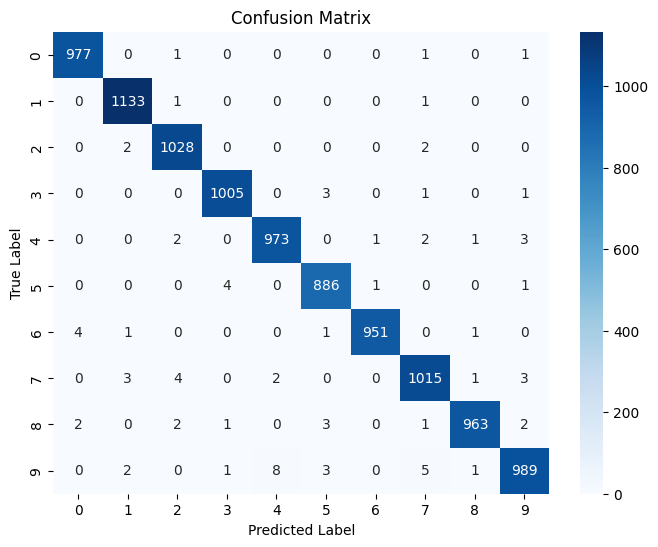

INFO :      fit progress: (500, 0.0004182687185704708, {'accuracy': 0.9906}, 49230.70284992799)
INFO :      configure_evaluate: strategy sampled 200 clients (out of 200)
INFO :      aggregate_evaluate: received 200 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 500 round(s) in 49242.99s
INFO :      	History (loss, distributed):
INFO :      		round 1: (2.2994239085223573, {'accuracy': 0.09244392948771})
INFO :      		round 2: (2.2947840486191997, {'accuracy': 0.10320284697508897})
INFO :      		round 3: (2.3216599635826105, {'accuracy': 0.11520317801870396})
INFO :      		round 4: (2.187569117532269, {'accuracy': 0.29214599023421334})
INFO :      		round 5: (1.9641027127257011, {'accuracy': 0.5036000993130845})
INFO :      		round 6: (1.7167980991273706, {'accuracy': 0.5156004303566994})
INFO :      		round 7: (1.497358288364054, {'accuracy': 0.49201357278821484})
INFO :      		round 8: (1.2041166239692254, {'accuracy': 0.5813953488372093})
INFO :    

(ClientAppActor pid=2132861) Round 500, Client 2: 攻擊者
Total Training Time: 49277.14 seconds


In [11]:
# 讓 Flower 運行完整的 FL 訓練
start_time = time.time()  # 記錄開始時間

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

end_time = time.time()  # 記錄結束時間
total_time = end_time - start_time  # 計算總時間

print(f"Total Training Time: {total_time:.2f} seconds")  # 顯示總時間

### Loss 和 Accuracy 折線圖

/tmp/ipykernel_2130715/2669147964.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


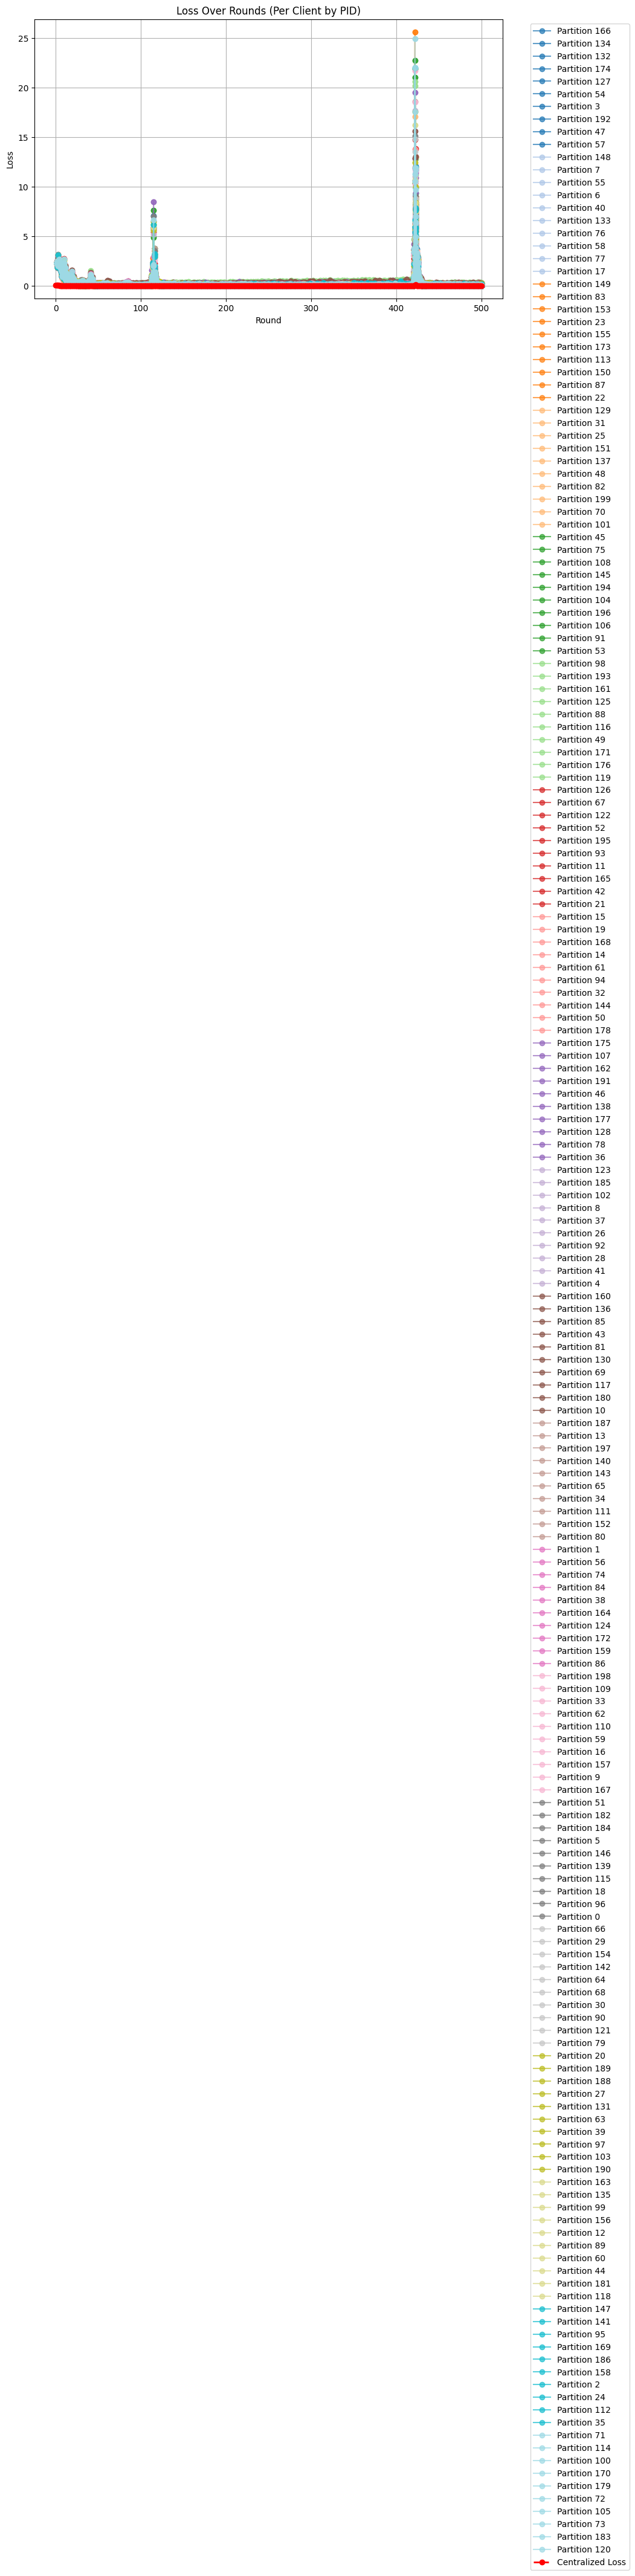

/tmp/ipykernel_2130715/2669147964.py:78: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


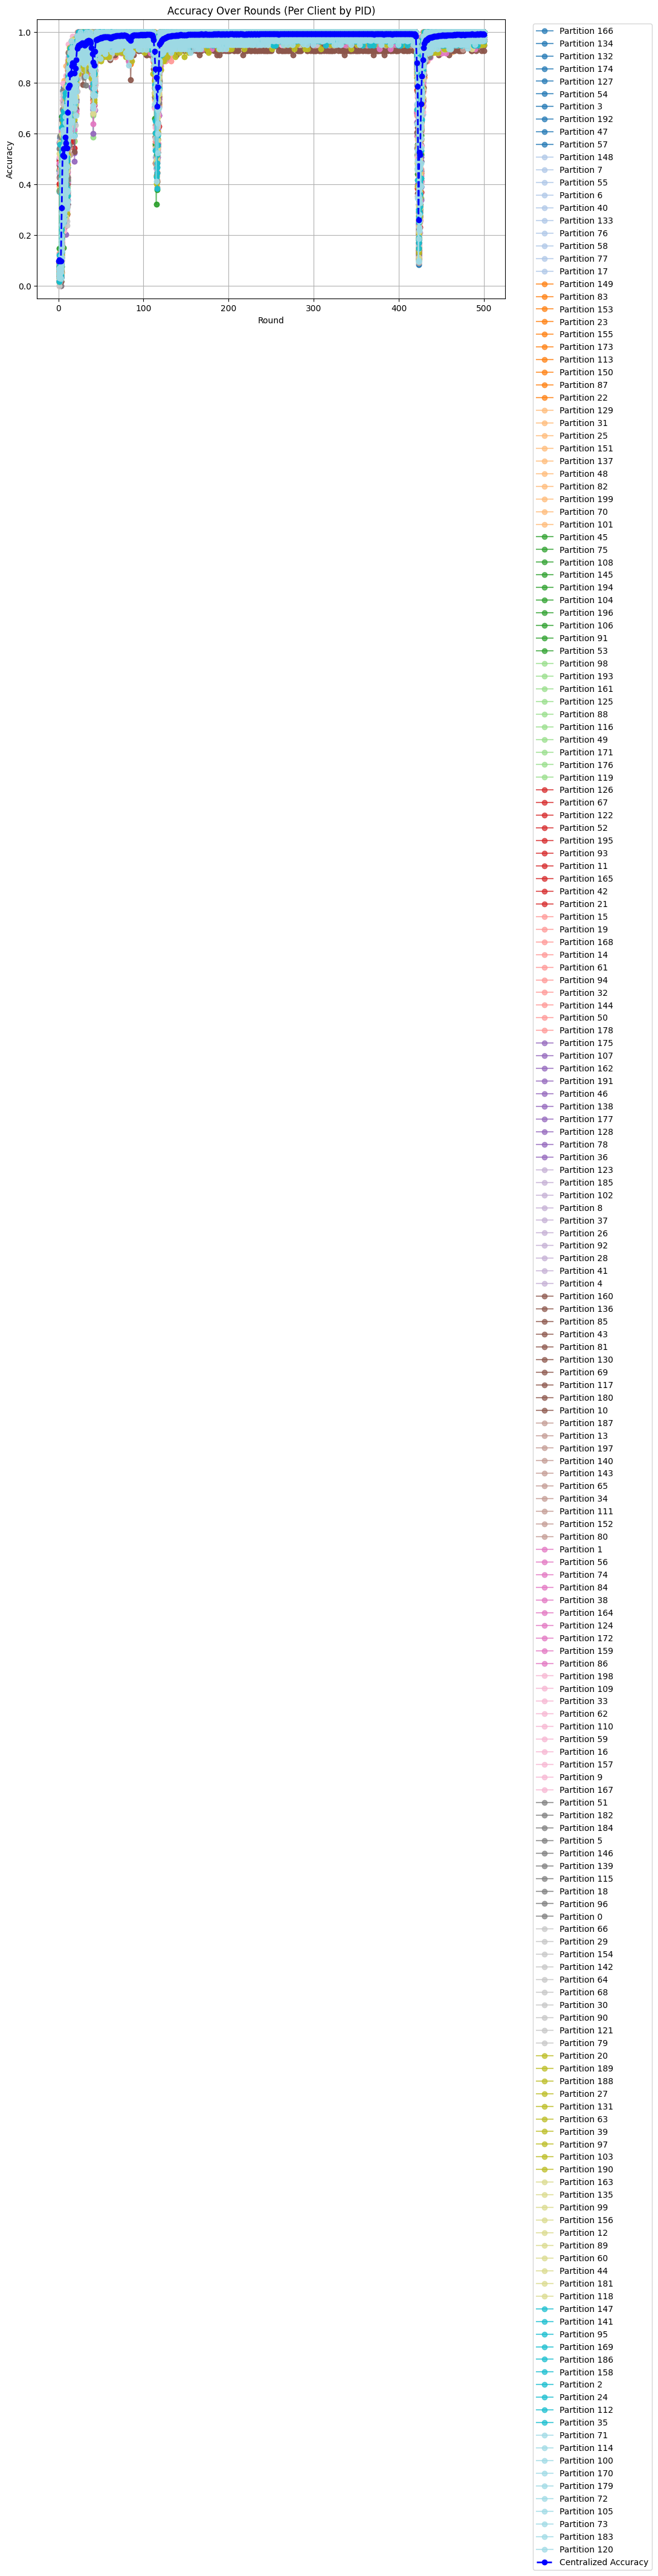

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 提取每個 client（按 pid）的 loss 和 accuracy 數據
client_losses = {}  # {pid: [(round, loss), ...]}
client_accuracies = {}  # {pid: [(round, acc), ...]}

for round_num, pid, loss in history.losses_distributed:
    if pid not in client_losses:
        client_losses[pid] = []
    client_losses[pid].append((round_num, loss))

for round_num, pid, acc in history.metrics_distributed.get('accuracy', []):
    if pid not in client_accuracies:
        client_accuracies[pid] = []
    client_accuracies[pid].append((round_num, acc))

# 為圖表生成隨機顏色
colors = plt.cm.tab20(np.linspace(0, 1, max(len(client_losses), len(client_accuracies))))

# 繪製每個 client 的 Loss 圖
plt.figure(figsize=(10, 6))
for idx, (pid, losses) in enumerate(client_losses.items()):
    rounds = [r for r, _ in sorted(losses)]
    loss_values = [l for _, l in sorted(losses)]
    plt.plot(rounds, loss_values, marker='o', color=colors[idx], label=f'Partition {pid}', alpha=0.7)

# 繪製 centralized 和 distributed loss
rounds_loss = [t[0] for t in history.losses_centralized]
loss_values_centralized = [t[1] for t in history.losses_centralized]

distributed_loss_by_round = {}
for round_num, _, loss in history.losses_distributed:
    if round_num not in distributed_loss_by_round:
        distributed_loss_by_round[round_num] = []
    distributed_loss_by_round[round_num].append(loss)
rounds_loss_distributed = sorted(distributed_loss_by_round.keys())
loss_values_distributed = [np.mean(distributed_loss_by_round[r]) for r in rounds_loss_distributed]

plt.plot(rounds_loss, loss_values_centralized, marker='o', color='red', label='Centralized Loss', linewidth=2, linestyle='--')
# plt.plot(rounds_loss_distributed, loss_values_distributed, marker='o', color='orange', label='Distributed Loss', linewidth=2, linestyle='--')

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss Over Rounds (Per Client by PID)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 繪製每個 client 的 Accuracy 圖
plt.figure(figsize=(10, 6))
for idx, (pid, accuracies) in enumerate(client_accuracies.items()):
    rounds = [r for r, _ in sorted(accuracies)]
    acc_values = [a for _, a in sorted(accuracies)]
    plt.plot(rounds, acc_values, marker='o', color=colors[idx], label=f'Partition {pid}', alpha=0.7)

# 繪製 centralized 和 distributed accuracy
acc_rounds = [t[0] for t in history.metrics_centralized.get('accuracy', [])]
acc_values_centralized = [t[1] for t in history.metrics_centralized.get('accuracy', [])]

distributed_acc_by_round = {} 
for round_num, _, acc in history.metrics_distributed.get('accuracy', []):
    if round_num not in distributed_acc_by_round:
        distributed_acc_by_round[round_num] = []
    distributed_acc_by_round[round_num].append(acc)
acc_rounds_md = sorted(distributed_acc_by_round.keys())
acc_values_md = [np.mean(distributed_acc_by_round[r]) for r in acc_rounds_md]

plt.plot(acc_rounds, acc_values_centralized, marker='o', color='blue', label='Centralized Accuracy', linewidth=2, linestyle='--')
# plt.plot(acc_rounds_md, acc_values_md, marker='o', color='green', label='Distributed Accuracy', linewidth=2, linestyle='--')

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Rounds (Per Client by PID)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2130715/3393646123.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


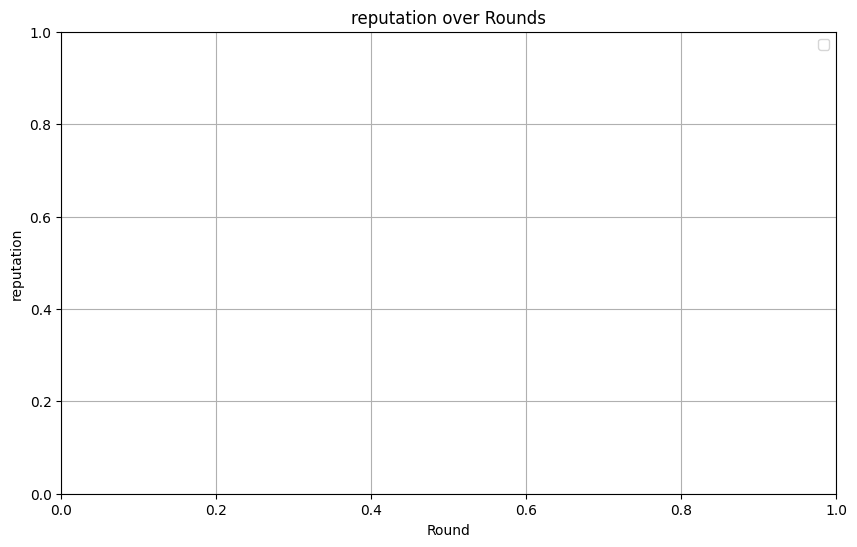

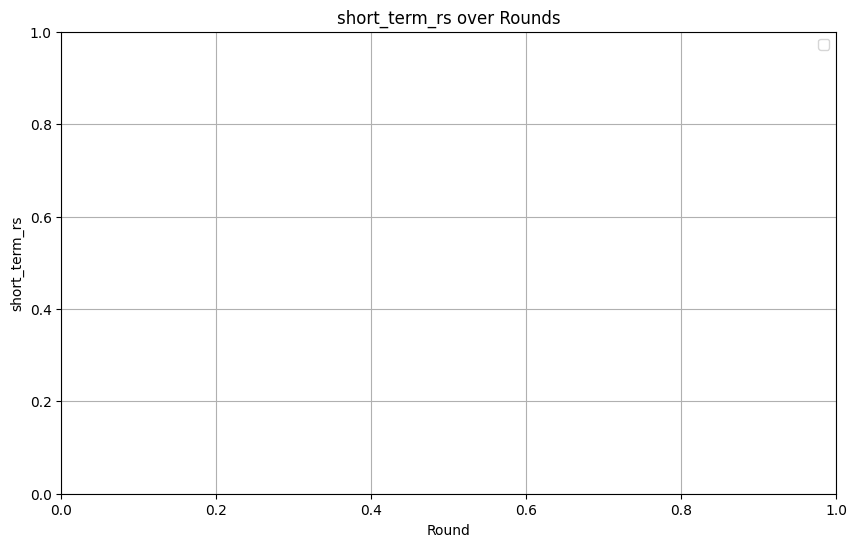

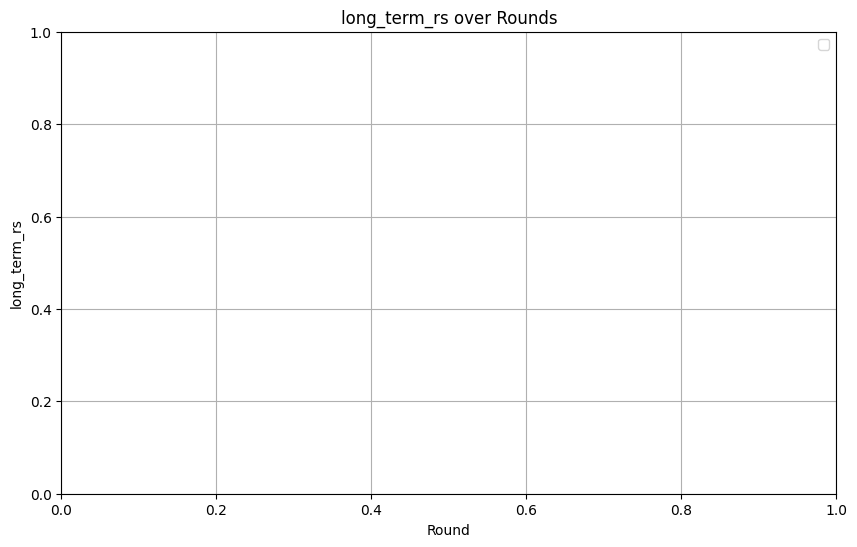

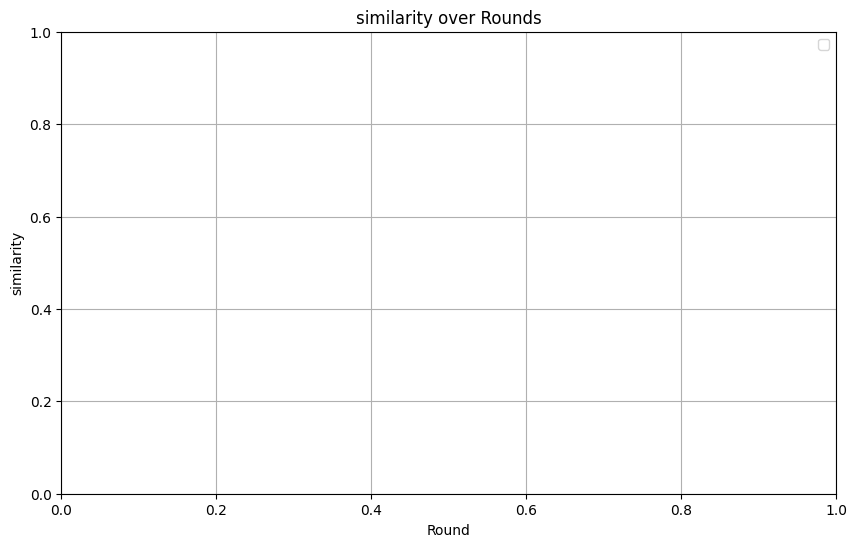

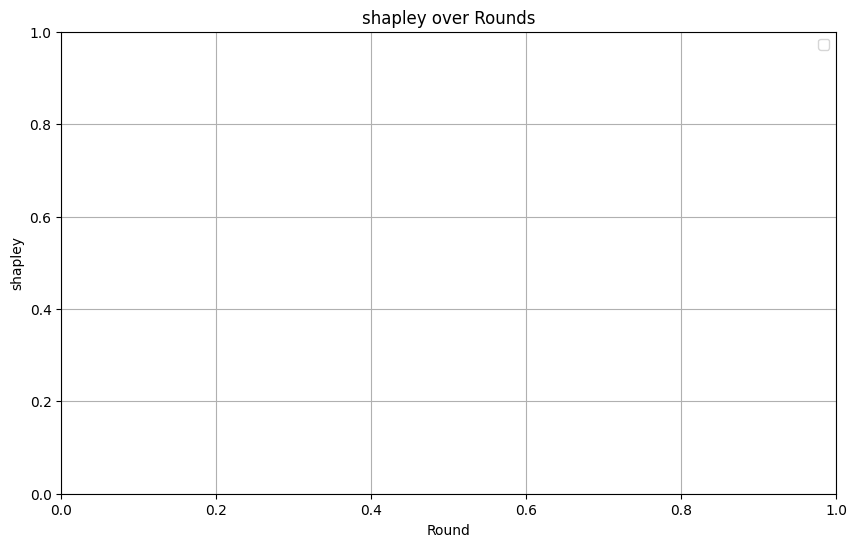

In [13]:
# ========= 訓練結束後繪圖 =========

# 假設 NUM_ROUNDS 為全局訓練輪數
rounds = list(range(1, NUM_ROUNDS + 1))
metrics_to_plot = ['reputation', 'short_term_rs', 'long_term_rs', 'similarity', 'shapley']

# 從策略中提取 metric_history
metric_history = strategy.metric_history

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    for partition_id, metrics_dict in metric_history.items():
        # if partition_id == -1:
        #     continue
        values = metrics_dict[metric]
        # 若某 client 的紀錄少於 NUM_ROUNDS (代表部分 round 沒有更新)，則補上最後一次的值
        if len(values) < NUM_ROUNDS:
            last_val = values[-1] if values else 0.0
            values = values + [last_val] * (NUM_ROUNDS - len(values))
        plt.plot(rounds, values, marker='o', label=f'Partition {partition_id}')
    plt.xlabel('Round')
    plt.ylabel(metric)
    plt.title(f'{metric} over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


In [14]:
# history.metrics_centralized
best_epoch, best_accuracy = max(history.metrics_centralized['accuracy'], key=lambda x: x[1])

print(f"Best Epoch: {best_epoch}, Accuracy: {best_accuracy:.4f}")

Best Epoch: 249, Accuracy: 0.9941


In [15]:
import numpy as np

# 1. 從 history.losses_distributed 中整理出：{ round_num: [loss_client1, loss_client2, ...], ... }
accuracies_by_round = {}
for round_num, pid, loss in history.metrics_distributed.get('accuracy', []):
    if round_num not in accuracies_by_round:
        accuracies_by_round[round_num] = []
    accuracies_by_round[round_num].append(loss)

# 2. 按 round 排序，計算每一輪的 client_loss 標準差（母體標準差 ddof=0）
rounds = sorted(accuracies_by_round.keys())
fairness_std_per_round = []
for r in rounds:
    client_accuracies_this_round = accuracies_by_round[r]
    if len(client_accuracies_this_round) > 1:
        std_val = float(np.std(client_accuracies_this_round, ddof=0))
    else:
        std_val = 0.0  # 如果只有一個 client 或無資料，就設為 0
    fairness_std_per_round.append(std_val)


avg_fairness_std = float(np.mean(fairness_std_per_round))
# print("500 輪公平性標準差平均值：", avg_fairness_std)
# fairness_std_per_round

# 確定只考慮前500輪（若總輪次少於500，則全部都考慮）
num_rounds = min(500, len(fairness_std_per_round))
subset = fairness_std_per_round[:num_rounds]

# 取最小值
min_std = min(subset)

print(f"前 {num_rounds} 輪中，公平性標準差的最小值為：{min_std}")

前 500 輪中，公平性標準差的最小值為：0.00992862547536858


In [16]:
# import torch
# import numpy as np
# from typing import List, Tuple, Dict
# from collections import OrderedDict
# from math import log, isnan
# from torch.utils.data import DataLoader
# import torch.nn as nn

# from flwr.client import NumPyClient

# from utils.train_test import test, lookahead_UPA_train, lookahead_TPA_train, train, local_evaluate
# from utils.others import get_parameters, set_parameters
# from utils.time import timed
# from utils.weights_utils import weights_substraction, norm

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class FlowerClient(NumPyClient):
#     def __init__(self, partition_id, net, trainloader, valloader, attack_type: str = None):
#         self.partition_id = partition_id
#         self.net = net
#         self.trainloader = trainloader
#         self.valloader = valloader
#         self.device = DEVICE
#         self.optimizer = torch.optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)  # Adjusted lr
#         self.attack_type = attack_type

#     def get_parameters(self, config):
#         return [param.cpu().numpy() for param in self.net.state_dict().values()]

#     def get_parameters_dict(self, config):
#         """Helper to return parameters as an OrderedDict for weights_substraction."""
#         return OrderedDict([(name, param) for name, param in self.net.state_dict().items()])

#     def fit(self, parameters, config):
#         try:
#             if self.attack_type == "UPA":
#                 grad, current_loss = lookahead_UPA_train(self.net, self.trainloader, parameters, config, self.partition_id, verbose=False)
#             elif self.attack_type == "TPA":
#                 grad, current_loss = lookahead_TPA_train(self.net, self.trainloader, parameters, config, self.partition_id, verbose=False)
#             else:
#                 grad, current_loss = train(self.net, self.trainloader, parameters, config, self.partition_id, verbose=False)
            
#             # 計算確定性係數
#             try:
#                 certainty, weight = cal_certainty(self.net, parameters, grad, self.trainloader, self.device, self.optimizer)
#             except Exception as inner_e:
#                 import traceback
#                 print(f"客戶端 {self.partition_id} 計算更新時出錯: {inner_e}")
#                 print(traceback.format_exc())
#                 certainty = 1.0
#                 weight = len(self.trainloader.dataset)
            
#             torch.cuda.empty_cache() if torch.cuda.is_available() else None  # 清理 GPU 記憶體
#             # 確保返回正確的三元組格式
#             return self.get_parameters(config), weight, {"certainty": float(certainty), "partition_id": self.partition_id}
        
#         except Exception as e:
#             import traceback
#             print(f"客戶端 {self.partition_id} 訓練錯誤: {e}")
#             print(traceback.format_exc())
#             # 出錯時仍返回正確格式
#             return self.get_parameters(config), len(self.trainloader.dataset), {"certainty": 1.0, "partition_id": self.partition_id}

#     def evaluate(self, parameters, config):
#         try:
#             avg_loss, accuracy = local_evaluate(parameters, self.net, self.device, self.valloader, self.partition_id)
#             torch.cuda.empty_cache() if torch.cuda.is_available() else None  # 清理 GPU 記憶體
#             return float(avg_loss), len(self.valloader.dataset), {
#                 "client_accuracy": float(accuracy),
#                 "client_loss": float(avg_loss),
#                 "partition_id": self.partition_id
#             }
#         except Exception as e:
#             print(f"客戶端 {self.partition_id} 評估錯誤: {e}")
#             return 0.0, len(self.valloader.dataset), {
#                 "client_accuracy": 0.0,
#                 "partition_id": self.partition_id
#             }

# def cal_certainty(net, parameters, grad, trainloader, device, optimizer):
#     # 獲取全局參數和本地更新後參數
#     global_weights = OrderedDict()
#     for name, param in zip(net.state_dict().keys(), parameters):
#         global_weights[name] = torch.tensor(param, dtype=torch.float, device=device)
    
#     local_weights = OrderedDict()
#     for name, param in net.state_dict().items():
#         local_weights[name] = param.detach().clone().float()
    
#     # 計算更新 - 現在確保兩個參數都是 OrderedDict
#     update = weights_substraction(global_weights, local_weights)
    
#     # 計算範數
#     update_norm = norm(update) if update else 1.0
#     grad_norm = norm(grad) if grad else 1.0
    
#     # 避免除以零
#     if grad_norm > 0 and update_norm > 0:
#         norm_factor = update_norm / grad_norm
#         local_lr = optimizer.param_groups[0]['lr']
#         if norm_factor > 0 and local_lr > 0:
#             certainty = log(norm_factor / local_lr) + 1
#             # 確保確定性合理
#             certainty = 1.0 if isnan(certainty) else max(0.1, min(2.0, certainty))
#         else:
#             certainty = 1.0
#     else:
#         certainty = 1.0
    
#     # 樣本數作為權重
#     weight = len(trainloader.dataset)
    
#     return certainty, weight
